##### top

# This ntb processes and cleans all data for all tasks
This is part of the original *Reliability_split_halves.ipynb* but only the preprocessing steps.

Tasks:
* [CCMT - Cambridge car memory test](#CCMT)
    * [Prepare and process CCMT](#Prepare-and-process-CCMT)
    
* [CFMT - Cambridge face memory test](#CFMT)
    * [Prepare and process CFMT](#Prepare-and-process-CFMT)

* [Car matching](#Car-matching)
    * [Prepare and process car matching](#Prepare-and-process-car-matching)
    
* [Emotion matching](#Emotion-matching)
    * [Prepare and process Emotion matching](#Prepare-and-process-Emotion-matching)
    
* [Emotion labelling](#Emotion-labelling)
    * [Prepare and process Emotion labelling](#Prepare-and-process-Emotion-labelling)
    
* [FMP](#FMP)
    * [FMP standalone](#FMP-standalone)

* [GFMT](#GFMT)
    * [Prepare and process GFMT](#Prepare-and-process-GFMT)

* [MST](#MST)
    * [Prepare and process MST](#Prepare-and-process-MST)
        
* [PIM](#PIM)
    * [Prepare and process PIM](#Prepare-and-process-PIM)
    
* [PGNG](#PGNG) 
    * [Prepare and process PGNG](#Prepare-and-process-PGNG)
    
* [RISE](#RISE)
    * [Prepare and process RISE](#Prepare-and-process-RISE)
    
* [SCAP](#SCAP)
    * [Prepare and process SCAP](#Prepare-and-process-SCAP)
  
* [n back](#n-back)
    * [Prepare and process n back](#Prepare-and-process-n-back)
            
* [VET birds](#VET-birds)
    * [Prepare and process VET-birds](#Prepare-and-process-VET-birds)
        
* [VET leaves](#VET-leaves)
    * [Prepare and process VET-leaves](#Prepare-and-process-VET-leaves)
    
* [VET planes](#VET-planes)
    * [Prepare and process VET-planes](#Prepare-and-process-VET-planes)
  
    
For running the split halves analysis, see [FMP](#FMP) part for all the details.

All the results are saved into separate csv files so that one can plot and do statistics on the reliability without the need of running all this again.


    
---
NOTE (README):
--

**The logic** of this ntb is that first, there is the preprocessing and cleaning of the data. That is specific per task and cannot be easily rewritten. It is derived either from mine preprocessing scripts or from Catherine's. All of them were validated and checked and compared to what she had in R. The data is preprocessed separately for the standalone and the original version and saved to `csv` files. **It is designed that one always runs preprocessing per task, then restarts the kernel and runs the next** although it is possible to run all (the variable names are different). Meaning preprocessing of each and single task is run separately after the kernel is restarted. 


Exclusions and flagging
--

We have decided to flag and remove from data following this algorithm:

1. No exclusion happens if participant's score is greater than $\mu-0.5\sigma$ even if this participant is flagged several times. The only exception is for bot (too narrow RT), that is flagged even for high accuracy.
2. Flags are given if:
    1. RT outlier -> the person is 2 (or 1.5) SD faster than the group.
    1. Too narrow RT -> it is likely a script/robot. Cut too long RT (task specific), then flag people whose SD of RT is below 2 SD of the task/group.
    1. Sequence length -> if they press too many times the same key (either do SD from group or SD from max length of such a sequence in the experiment or over some number that can rarely happen at chance --> done as 2 SD from mean of max length across participants).
    1. Low accuracy on sanity checks (3 SD below the average) -- only for tasks where we have it.
        1. CFMT stage one -- if 3 wrong trials - look at them closely one by one, if more, exclude
        1. FMP perception -- chance/low accuracy exclude, maybe also emotion recognition?
        1. PGNG block 1 -- 2 SD below check one by one, less than 3 SD below exclude
        1. n-back level 1 -- 2 SD below check one by one, less than 3 SD below exclude
        1. VET tasks -- there are 3 catch trials, exclude anyone who has more than 1 miss
    


In [1]:
import os, sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

user = "jan"

if user == "jan":
    csv_raw_data_path = "../Data/raw_CSV"
    csv_raw_pilot_data_path = "../Data/raw_CSV/piloting"
    path_demo = '../Data/demographic_data/'

    csv_clean_data_path = "../Data/cleaned_CSV" 
#     path_results = "../Data/results" 
    
    # Importing module for functions
    functions_modul =  "./functions"
    sys.path.insert(0, functions_modul)
    
# import all processing and plotting functions
from reliability_functions import check_double_access, flag_participants
from data_processing_functions import fill_in_userID
    
# for VET tasks
catch_trials_dic = {
    'leaves':[
        '29_trial_sect3_cor3_durNA_fdbkNA.jpg',
        '46_trial_sect3_cor1_durNA_fdbkNA.jpg',
        '54_trial_sect3_cor2_durNA_fdbkNA.jpg',],
    'planes':[
        '26_trial_sect3_cor1_durNA_fdbkNA.jpg',
        '41_trial_sect3_cor2_durNA_fdbkNA.jpg',
        '54_trial_sect3_cor2_durNA_fdbkNA.jpg',],
    'birds':[
        '26_trial_sect3_cor1_durNA_fdbkNA.jpg',
        '41_trial_sect3_cor3_durNA_fdbkNA.jpg',
        '54_trial_sect3_cor2_durNA_fdbkNA.jpg',],
}
    
    
# find the highest ID that we still have all the data and consents for
highest_ID = max(pd.read_csv(os.path.join(path_demo, 'demographics_all_subjects.csv'), 
                             usecols=['userID'])["userID"].str.split('_').str[-1].astype(int))

In [2]:
sorted(os.listdir(csv_raw_data_path))

['CCMT_data.csv',
 'CCMT_standalone_data.csv',
 'CFMT_Aus_standalone_data.csv',
 'CFMT_F_standalone_data.csv',
 'CFMT_data.csv',
 'FMP_standalone_data.csv',
 'GFMT_data.csv',
 'GFMT_long_standalone_data.csv',
 'MST_data.csv',
 'MST_set2_data.csv',
 'MST_v3_standalone_data.csv',
 'PGNG_data.csv',
 'PGNG_no_SS_data.csv',
 'PGNG_xyz_standalone_data.csv',
 'PIM_RISE_standalone_data.csv',
 'PIM_solo_standalone_data.csv',
 'RISE_CFMT_AOS_RPM_OSVIQ_data.csv',
 'RISE_test_data.csv',
 'SCAP_data.csv',
 'SCAP_standalone_data.csv',
 'VET_IQ_data.csv',
 'car_matching_data.csv',
 'car_matching_standalone_data.csv',
 'complex_mem_task_data.csv',
 'emotion_labeling_data.csv',
 'emotion_labeling_standalone_data.csv',
 'emotion_matching_data.csv',
 'emotion_matching_standalone_data.csv',
 'navon_data.csv',
 'nback_standalone_day1_data.csv',
 'nback_standalone_day2_data.csv',
 'piloting']

removed subjects for no demog

{
'CCMT': ['s_292'],
'car_matching': ['s_258', 's_269'],
'emotion_matching': ['s_258', 's_269'],
'emotion_labelling': ['s_292']+['s_258'],
'PIM': ['s_265', 's_271', 's_278', 's_291', 's_292'],
'PGNG': ['s_282'],
'RISE': []+['s_284'], # that was me testing
'SCAP': ['s_277'],
'Navon': ['s_282'],

}

## CCMT
[top](#top)

### Prepare and process CCMT
[top](#top)

#### Set 1

In [3]:
# concat both full data and pilot data
df_ccmt_raw = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'CCMT_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "timestamp", "x",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"}),
    # add also pilot data
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'CCMT_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "timestamp", "x",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"})
])

# check if someone accessed twice
check_double_access(df_ccmt_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_ccmt_raw)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_ccmt_raw.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data to be able to get people who have all trials

# remove the nans in sender id
df_ccmt_raw = df_ccmt_raw[~df_ccmt_raw["sender_id"].isna()]

# add stage
df_ccmt_raw['stage'] = ''

# fill it
# stage 1
df_ccmt_raw.loc[df_ccmt_raw["sender"] == 'Stage 1 Test Car', "stage"] = '1'

# stage 2
df_ccmt_raw.loc[(df_ccmt_raw["sender_id"].str.startswith('10')) & (df_ccmt_raw["sender"] == 'Cars'), "stage"] = '2'

# stage 3
df_ccmt_raw.loc[(df_ccmt_raw["sender_id"].str.startswith('12')) & (df_ccmt_raw["sender"] == 'Cars'), "stage"] = '3'

# select only the real trials -- have stage
# df_ccmt_raw = df_ccmt_raw.loc[df_ccmt_raw["stage"]!='',["observation", "userID", "correct", "stage"]]
df_ccmt_raw = df_ccmt_raw.loc[df_ccmt_raw["stage"] != ''] 

# TODO - check
# drop the people who don't have a full dataset
not_full_participants = df_ccmt_raw["observation"].value_counts()[df_ccmt_raw["observation"].value_counts() < 72].keys()
df_ccmt_raw = df_ccmt_raw[~df_ccmt_raw["observation"].isin(not_full_participants)]



#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_ccmt_raw["userID"].value_counts()[df_ccmt_raw["userID"].value_counts() != 72].keys()

if not double_visits.empty:
    relevant_observation = df_ccmt_raw.loc[df_ccmt_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_ccmt_raw = df_ccmt_raw[~df_ccmt_raw["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again if someone accessed twice
check_double_access(df_ccmt_raw)


# do flag analysis
flagged_ptc, suspects = flag_participants(df_ccmt_raw, RT_thr=10000)
# select only relevant
df_ccmt_raw = df_ccmt_raw[["observation", "userID", "correct", "RT", "stage"]]

# sort the df to easily find changes in csv file when updated
df_ccmt_raw.sort_values(by=["userID"], inplace=True)


There are 258 participants (observations) and 250 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 258 participants (observations) and 250 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 245 participants (observations) and 245 unique IDs.

userID
s_116    382.786403
s_165    451.966818
Name: RT, dtype: float64

--> Flagging 2 subjects for too narrow RT (bots/scripts).

In the task, there are 9 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 5 and mean of max per subject is 5.11 +/- 1.76.
userID
s_19    9
Name: response, dtype: int64

--> Flagging 1 subjects for too long consecutive answers.

In total flagging 3 participants:
('s_116', 's_165', 's_19')


std:
          correct           RT
userID                       
s_116   0.463875   382.786403
s_165   0.500391   451.966818
s_19    0.487520  7926.812643 

mean:



,correct,RT
userID,,
s_116,0.694444,2329.121083
s_165,0.555556,2175.124222
s_19,0.375000,2631.183056


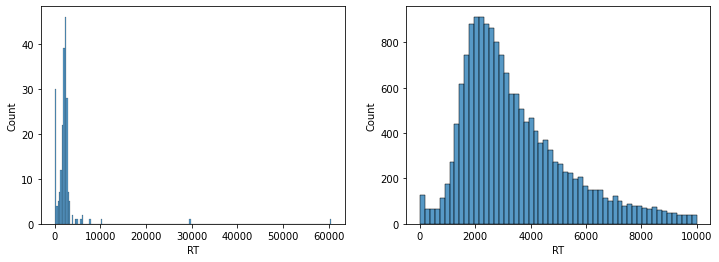

In [4]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_ccmt_raw.loc[df_ccmt_raw["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
sns.histplot(df_ccmt_raw.loc[df_ccmt_raw["RT"]<10000,"RT"], ax=axs[1])

plt.plot()

print('std:\n',df_ccmt_raw[df_ccmt_raw["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
df_ccmt_raw[df_ccmt_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()

In [5]:
print('group:\n', df_ccmt_raw.groupby(['stage']).mean())
df_ccmt_raw[df_ccmt_raw["userID"].isin(flagged_ptc)].groupby(['userID', 'stage']).mean()

group:
         correct           RT
stage                       
1      0.844218  3689.006698
2      0.595782  4926.254414
3      0.652381  3896.383214


correct           RT
userID stage                       
s_116  1      0.777778  2328.458389
       2      0.600000  2374.796900
       3      0.750000  2272.523333
s_165  1      0.722222  2175.103222
       2      0.433333  2303.087000
       3      0.583333  2015.186500
s_19   1      0.333333  4672.878889
       2      0.433333  3192.606000
       3      0.333333   398.132500

In [6]:
print('group:\n', df_ccmt_raw.groupby(['stage']).mean())
df_ccmt_raw[df_ccmt_raw["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID', 'stage']).mean()

group:
         correct           RT
stage                       
1      0.844218  3689.006698
2      0.595782  4926.254414
3      0.652381  3896.383214


correct           RT
userID stage                       
s_136  1      0.555556  3393.196778
       2      0.400000  2723.663767
       3      0.375000  2489.715417
s_160  1      0.333333  1890.077889
       2      0.300000  1912.108100
       3      0.583333  1467.579875
s_175  1      0.444444  2824.607556
       2      0.300000   198.693733
       3      0.416667   164.345833
s_197  1      0.500000  1310.055389
       2      0.266667   737.372333
       3      0.375000  1070.886042
s_224  1      0.777778  2150.464222
       2      0.300000  1351.096067
       3      0.333333  2528.590083
s_228  1      0.277778   850.547111
       2      0.466667   234.297400
       3      0.500000   123.090708
s_36   1      0.666667  1490.134944
       2      0.233333  1058.518800
       3      0.250000   905.732125
s_73   1      0.666667  1983.115778
       2      0.200000  2359.052433
       3      0.416667  1940.880750

In [7]:
df_ccmt_raw[df_ccmt_raw['userID']=='s_36']

,observation,userID,correct,RT,stage
52727,d2869,s_36,0.0,867.967,3
52724,d2869,s_36,0.0,7737.979,3
52719,d2869,s_36,0.0,628.265,2
52716,d2869,s_36,1.0,323.324,2
52713,d2869,s_36,1.0,423.128,2
...,...,...,...,...,...
52507,d2869,s_36,1.0,1987.720,1
52790,d2869,s_36,1.0,629.398,3
52510,d2869,s_36,0.0,1970.255,1
52787,d2869,s_36,0.0,343.510,3


In [8]:
print(f"""Removing {len(df_ccmt_raw.loc[df_ccmt_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_ccmt_raw.loc[df_ccmt_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_ccmt_raw = df_ccmt_raw.loc[df_ccmt_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = ['s_19']

df_ccmt_raw = df_ccmt_raw[~df_ccmt_raw['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_ccmt_raw.userID.unique().size} participants.")
################
# save
df_ccmt_raw.to_csv(os.path.join(csv_clean_data_path, "CCMT-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'CCMT',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "CCMT-flagged_ptc.csv"), index=False)

Removing 1 subjects with not all data/consents
      ['s_292']

Saving 243 participants.


#### Set 2 (Feb 2022)

In [9]:
# load the new data
df_ccmt_raw_rep = pd.read_csv(os.path.join(csv_raw_data_path, 'CCMT_standalone_data.csv'),
                                 usecols=["user_id", "sender_id", "sender", "observation", "correct", 
                                          "timestamp", "x",
                                          "response", "correct_response",
                                          "duration"
                                         ]
                                 ).rename(columns={"user_id":"userID", "duration":"RT"})

# check if someone accessed twice
check_double_access(df_ccmt_raw_rep)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_ccmt_raw_rep)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_ccmt_raw_rep.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data to be able to get people who have all trials

# remove the nans in sender id
df_ccmt_raw_rep = df_ccmt_raw_rep[~df_ccmt_raw_rep["sender_id"].isna()]

# add stage
df_ccmt_raw_rep['stage'] = ''

# fill it
# stage 1
df_ccmt_raw_rep.loc[df_ccmt_raw_rep["sender"] == 'Stage 1 Test Car', "stage"] = '1'

# stage 2
df_ccmt_raw_rep.loc[(df_ccmt_raw_rep["sender_id"].str.startswith('10')) & (df_ccmt_raw_rep["sender"] == 'Cars'), "stage"] = '2'

# stage 3
df_ccmt_raw_rep.loc[(df_ccmt_raw_rep["sender_id"].str.startswith('12')) & (df_ccmt_raw_rep["sender"] == 'Cars'), "stage"] = '3'

# select only the real trials -- have stage
# df_ccmt_raw_rep = df_ccmt_raw_rep.loc[df_ccmt_raw_rep["stage"]!='',["observation", "userID", "correct", "stage"]]
df_ccmt_raw_rep = df_ccmt_raw_rep.loc[df_ccmt_raw_rep["stage"] != ''] 

# TODO - check
# drop the people who don't have a full dataset
not_full_participants = df_ccmt_raw_rep["observation"].value_counts()[df_ccmt_raw_rep["observation"].value_counts() < 72].keys()
df_ccmt_raw_rep = df_ccmt_raw_rep[~df_ccmt_raw_rep["observation"].isin(not_full_participants)]



#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_ccmt_raw_rep["userID"].value_counts()[df_ccmt_raw_rep["userID"].value_counts() != 72].keys()

if not double_visits.empty:
    relevant_observation = df_ccmt_raw_rep.loc[df_ccmt_raw_rep["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_ccmt_raw_rep = df_ccmt_raw_rep[~df_ccmt_raw_rep["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again if someone accessed twice
check_double_access(df_ccmt_raw_rep)


# do flag analysis
flagged_ptc, suspects = flag_participants(df_ccmt_raw_rep, RT_thr=10000)
# select only relevant
df_ccmt_raw_rep = df_ccmt_raw_rep[["observation", "userID", "correct", "RT", "stage"]]

# sort the df to easily find changes in csv file when updated
df_ccmt_raw_rep.sort_values(by=["userID"], inplace=True)


There are 167 participants (observations) and 160 unique IDs! Check!

All is ok.
There are now 160 participants (observations) and 160 unique IDs.

Series([], Name: RT, dtype: float64)
In the task, there are 9 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 4 and mean of max per subject is 5.00 +/- 1.66.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 167 participants (observations) and 160 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


std:
 Empty DataFrame
Columns: [correct, RT]
Index: [] 

mean:



,correct,RT
userID,,


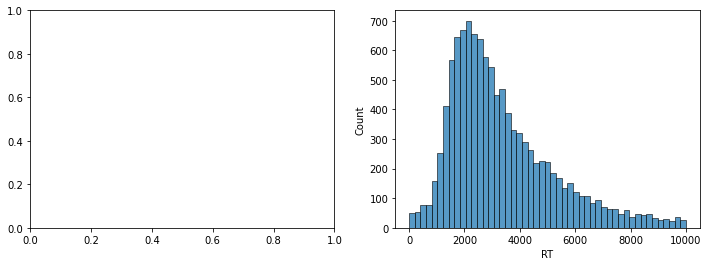

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_ccmt_raw_rep.loc[df_ccmt_raw_rep["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
sns.histplot(df_ccmt_raw_rep.loc[df_ccmt_raw_rep["RT"]<10000,"RT"], ax=axs[1])

plt.plot()

print('std:\n',df_ccmt_raw_rep[df_ccmt_raw_rep["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
df_ccmt_raw_rep[df_ccmt_raw_rep["userID"].isin(flagged_ptc)].groupby(['userID']).mean()

In [11]:
print('group:\n', df_ccmt_raw_rep.groupby(['stage']).mean())
df_ccmt_raw_rep[df_ccmt_raw_rep["userID"].isin(flagged_ptc)].groupby(['userID', 'stage']).mean()

group:
         correct           RT
stage                       
1      0.869792  3173.250053
2      0.633333  4305.808536
3      0.651302  3731.700299


,,correct,RT
userID,stage,,


In [12]:
print('group:\n', df_ccmt_raw_rep.groupby(['stage']).mean())
df_ccmt_raw_rep[df_ccmt_raw_rep["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID', 'stage']).mean()

group:
         correct           RT
stage                       
1      0.869792  3173.250053
2      0.633333  4305.808536
3      0.651302  3731.700299


correct            RT
userID stage                        
s_108  1      0.611111   4012.534278
       2      0.433333   5812.989900
       3      0.250000  14507.028208
s_118  1      0.500000   4209.874944
       2      0.366667   4852.412567
       3      0.291667   6370.234333
s_160  1      0.277778   2934.425111
       2      0.400000   2372.037333
       3      0.500000   2346.770667
s_171  1      0.555556   2891.115833
       2      0.300000   1907.664400
       3      0.333333   1059.849917
s_175  1      0.555556   2031.586556
       2      0.266667   1911.979067
       3      0.458333   1894.769625
s_197  1      0.666667   2090.448611
       2      0.333333    933.026533
       3      0.291667    715.805750
s_229  1      0.666667   2357.375000
       2      0.366667   1870.232467
       3      0.250000   2242.971792
s_73   1      0.777778   1453.259667
       2      0.400000   1218.969567
       3      0.291667    580.772000
s_92   1      0.611111   1996.090000
       2      0.433333   1736.567467
       3      0.375000   1612.568208

In [13]:
print(f"""Removing {len(df_ccmt_raw_rep.loc[df_ccmt_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_ccmt_raw_rep.loc[df_ccmt_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_ccmt_raw_rep = df_ccmt_raw_rep.loc[df_ccmt_raw_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_ccmt_raw_rep = df_ccmt_raw_rep[~df_ccmt_raw_rep['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_ccmt_raw_rep.userID.unique().size} participants.")
################
# save
df_ccmt_raw_rep.to_csv(os.path.join(csv_clean_data_path, "CCMT-cleaned_data_rep.csv"), index=False)

if flagged_ptc:
    pd.DataFrame({
        'task': ['CCMT_rep'],
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "CCMT-flagged_ptc_rep.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 160 participants.


[top](#top)

----

## CFMT
[top](#top)

### Prepare and process CFMT
[top](#top)

#### Set 1

In [2]:
# concat both full data and pilot data
df_cfmt_raw = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'CFMT_data.csv'),
                                 usecols=["user_id", "sender_id", "sender", "observation", "correct", 
                                          "timestamp", "x", 
                                          "response", "correct_response",
                                          "duration"
                                         ]
                                 ).rename(columns={"user_id":"userID", "duration":"RT"}),
# add also pilot data    
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'CFMT_data.csv'),
                                 usecols=["user_id", "sender_id", "sender", "observation", "correct", 
                                          "timestamp", "x", 
                                          "response", "correct_response",
                                          "duration"
                                         ]
                                 ).rename(columns={"user_id":"userID", "duration":"RT"})
])

# check if someone accessed twice
check_double_access(df_cfmt_raw)
    
# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_cfmt_raw)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_cfmt_raw.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data

# remove the nans in sender id
df_cfmt_raw = df_cfmt_raw[~df_cfmt_raw["sender_id"].isna()]

# add stage
df_cfmt_raw['stage'] = ''

# fill it
# stage 1
df_cfmt_raw.loc[df_cfmt_raw["sender"]=='Stage 1 Test Face',"stage"] = '1'

# stage 2
df_cfmt_raw.loc[(df_cfmt_raw["sender_id"].str.startswith('10')) & (df_cfmt_raw["sender"]=='Faces'), "stage"] = '2'

# stage 3
df_cfmt_raw.loc[(df_cfmt_raw["sender_id"].str.startswith('12')) & (df_cfmt_raw["sender"]=='Faces'), "stage"] = '3'


# select only the real trials -- have stage
# df_cfmt_raw = df_cfmt_raw.loc[df_cfmt_raw["stage"]!='',["observation", "userID", "correct", "stage"]]
df_cfmt_raw = df_cfmt_raw.loc[df_cfmt_raw["stage"]!='']

# TODO - check
# drop the people who don't have a full dataset
not_full_participants = df_cfmt_raw["observation"].value_counts()[df_cfmt_raw["observation"].value_counts() < 72].keys()
df_cfmt_raw = df_cfmt_raw[~df_cfmt_raw["observation"].isin(not_full_participants)]


#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_cfmt_raw["userID"].value_counts()[df_cfmt_raw["userID"].value_counts() != 72].keys()

if not double_visits.empty:
    relevant_observation = df_cfmt_raw.loc[df_cfmt_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_cfmt_raw = df_cfmt_raw[~df_cfmt_raw["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again if someone accessed twice
check_double_access(df_cfmt_raw)

### Quality checks
df_cfmt_raw["correct"] = df_cfmt_raw["correct"].astype(float)

# find people with low acc on the first level - border line
suspects_level1 = df_cfmt_raw[df_cfmt_raw["stage"]=='1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw.loc[df_cfmt_raw["stage"]=='1'].groupby(['userID']).mean()['correct']==15/18
].index.tolist()

# exclude all that have less
exclude_ptc_level1 = df_cfmt_raw[df_cfmt_raw["stage"]=='1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw.loc[df_cfmt_raw["stage"]=='1'].groupby(['userID']).mean()['correct']<15/18
].index.tolist()
print(f'There are {len(suspects_level1)} suspects with low acc on 1st level and {len(exclude_ptc_level1)} excluded.\n')

# exclude the low acc on level 1
df_cfmt_raw = df_cfmt_raw[~df_cfmt_raw['userID'].isin(exclude_ptc_level1)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_cfmt_raw)
print(f'- There are {len(set(suspects)&set(suspects_level1))} overlapping suspects.\n{set(suspects)&set(suspects_level1)}')
# select only relevant
df_cfmt_raw = df_cfmt_raw[["observation", "userID", "correct", "RT", "stage"]]

# sort the df to easily find changes in csv file when updated
df_cfmt_raw.sort_values(by=["userID"], inplace=True)


There are 255 participants (observations) and 243 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 255 participants (observations) and 243 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 243 participants (observations) and 243 unique IDs.

There are 6 suspects with low acc on 1st level and 9 excluded.

Series([], Name: RT, dtype: float64)
In the task, there are 8 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 4 and mean of max per subject is 4.12 +/- 0.64.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()
- There are 3 overlapping suspects.
{'s_200', 's_123', 's_55'}


In [3]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_cfmt_raw.loc[df_cfmt_raw["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_cfmt_raw.loc[df_cfmt_raw["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()

# print('std:\n',df_cfmt_raw[df_cfmt_raw["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
# df_cfmt_raw[df_cfmt_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [4]:
suspect_combined = list(set(suspects)|set(suspects_level1))

# print('std:\n',df_cfmt_raw[df_cfmt_raw["userID"].isin(suspect_combined)].groupby(['userID']).std(), '\n\nmean:\n')
print(df_cfmt_raw['correct'].mean())
print(df_cfmt_raw[df_cfmt_raw["userID"].isin(suspect_combined)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw.groupby(['stage'])['correct'].mean())
df_cfmt_raw[df_cfmt_raw["userID"].isin(suspect_combined)].groupby(['userID', 'stage']).mean()


0.7323717948717948
         correct           RT
userID                       
s_103   0.500000  1251.722569
s_123   0.486111  2903.960250
s_125   0.444444  1417.398208
s_136   0.500000  3311.257278
s_194   0.486111  2032.180556
s_197   0.500000  1256.920347
s_200   0.472222  2105.619722
s_22    0.527778  2877.633667
s_229   0.736111  1486.916681
s_55    0.486111  2110.522250
s_71    0.597222  3809.050236

Stages

stage
1    0.978395
2    0.704986
3    0.582087
Name: correct, dtype: float64


correct           RT
userID stage                       
s_103  1      0.888889  1789.866833
       2      0.400000  1288.724200
       3      0.333333   801.862333
s_123  1      0.833333  2149.456556
       2      0.433333  3488.612133
       3      0.291667  2739.023167
s_125  1      0.888889  1967.770500
       2      0.300000  1243.113067
       3      0.291667  1222.475417
s_136  1      0.944444  2781.890778
       2      0.433333  3399.447500
       3      0.250000  3598.044375
s_194  1      0.888889  1836.444444
       2      0.366667  2401.166667
       3      0.333333  1717.750000
s_197  1      0.888889  1619.144278
       2      0.400000  1176.224100
       3      0.333333  1086.122708
s_200  1      0.833333  2056.228889
       2      0.400000  2148.318000
       3      0.291667  2089.290000
s_22   1      0.833333  2674.673611
       2      0.533333  3233.120033
       3      0.291667  2585.495750
s_229  1      0.833333  1027.171389
       2      0.766667  1630.096100
       3      0.625000  1652.751375
s_55   1      0.833333  2529.738722
       2      0.333333  2711.532100
       3      0.416667  1044.847583
s_71   1      0.833333  3421.279111
       2      0.633333  4349.138767
       3      0.375000  3424.767917

In [5]:
print(df_cfmt_raw['correct'].mean())
print(df_cfmt_raw[df_cfmt_raw["userID"].isin(suspects_level1)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw.groupby(['stage'])['correct'].mean())
df_cfmt_raw[df_cfmt_raw["userID"].isin(suspects_level1)].groupby(['userID', 'stage']).mean()


0.7323717948717948
         correct           RT
userID                       
s_123   0.486111  2903.960250
s_200   0.472222  2105.619722
s_22    0.527778  2877.633667
s_229   0.736111  1486.916681
s_55    0.486111  2110.522250
s_71    0.597222  3809.050236

Stages

stage
1    0.978395
2    0.704986
3    0.582087
Name: correct, dtype: float64


correct           RT
userID stage                       
s_123  1      0.833333  2149.456556
       2      0.433333  3488.612133
       3      0.291667  2739.023167
s_200  1      0.833333  2056.228889
       2      0.400000  2148.318000
       3      0.291667  2089.290000
s_22   1      0.833333  2674.673611
       2      0.533333  3233.120033
       3      0.291667  2585.495750
s_229  1      0.833333  1027.171389
       2      0.766667  1630.096100
       3      0.625000  1652.751375
s_55   1      0.833333  2529.738722
       2      0.333333  2711.532100
       3      0.416667  1044.847583
s_71   1      0.833333  3421.279111
       2      0.633333  4349.138767
       3      0.375000  3424.767917

In [6]:
print(f"""Removing {len(df_cfmt_raw.loc[df_cfmt_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_cfmt_raw.loc[df_cfmt_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_cfmt_raw = df_cfmt_raw.loc[df_cfmt_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_cfmt_raw = df_cfmt_raw[~df_cfmt_raw['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_cfmt_raw.userID.unique().size} participants.")
################
# save
df_cfmt_raw.to_csv(os.path.join(csv_clean_data_path, "CFMT-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'CFMT',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "CFMT-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 234 participants.


In [7]:
df_cfmt_raw.userID.value_counts()[df_cfmt_raw.userID.value_counts()>72]#.keys()

Series([], Name: userID, dtype: int64)

#### Set 2 (Feb 2022)

##### Australia

In [8]:
# load data
df_cfmt_raw_Aus = pd.read_csv(os.path.join(csv_raw_data_path, 'CFMT_Aus_standalone_data.csv'),
                                 usecols=["user_id", "sender_id", "sender", "observation", "correct", 
                                          "timestamp", "x",
                                          "response", "correct_response",
                                          "duration"
                                         ]
                                 ).rename(columns={"user_id":"userID", "duration":"RT"})

# check if someone accessed twice
check_double_access(df_cfmt_raw_Aus)
    
# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_cfmt_raw_Aus)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_cfmt_raw_Aus.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data

# remove the nans in sender id
df_cfmt_raw_Aus = df_cfmt_raw_Aus[~df_cfmt_raw_Aus["sender_id"].isna()]

# add stage
df_cfmt_raw_Aus['stage'] = ''

# fill it
# stage 1
df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus["sender"]=='Stage 1 Test Face',"stage"] = '1'

# stage 2
df_cfmt_raw_Aus.loc[(df_cfmt_raw_Aus["sender_id"].str.startswith('10')) & (df_cfmt_raw_Aus["sender"]=='Faces'), "stage"] = '2'

# stage 3
df_cfmt_raw_Aus.loc[(df_cfmt_raw_Aus["sender_id"].str.startswith('12')) & (df_cfmt_raw_Aus["sender"]=='Faces'), "stage"] = '3'


# select only the real trials -- have stage
# df_cfmt_raw_Aus = df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus["stage"]!='',["observation", "userID", "correct", "stage"]]
df_cfmt_raw_Aus = df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus["stage"]!='']

# TODO - check
# drop the people who don't have a full dataset
not_full_participants = df_cfmt_raw_Aus["observation"].value_counts()[df_cfmt_raw_Aus["observation"].value_counts() < 72].keys()
df_cfmt_raw_Aus = df_cfmt_raw_Aus[~df_cfmt_raw_Aus["observation"].isin(not_full_participants)]



#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_cfmt_raw_Aus["userID"].value_counts()[df_cfmt_raw_Aus["userID"].value_counts() != 72].keys()

if not double_visits.empty:
    relevant_observation = df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_cfmt_raw_Aus = df_cfmt_raw_Aus[~df_cfmt_raw_Aus["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again if someone accessed twice
check_double_access(df_cfmt_raw_Aus)

### Quality checks
df_cfmt_raw_Aus["correct"] = df_cfmt_raw_Aus["correct"].astype(float)

# find people with low acc on the first level - border line
suspects_level1 = df_cfmt_raw_Aus[df_cfmt_raw_Aus["stage"]=='1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus["stage"]=='1'].groupby(['userID']).mean()['correct']==15/18
].index.tolist()

# exclude all that have less
exclude_ptc_level1 = df_cfmt_raw_Aus[df_cfmt_raw_Aus["stage"]=='1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus["stage"]=='1'].groupby(['userID']).mean()['correct']<15/18
].index.tolist()
print(f'There are {len(suspects_level1)} suspects with low acc on 1st level and {len(exclude_ptc_level1)} excluded.\n')

# exclude the low acc on level 1
df_cfmt_raw_Aus = df_cfmt_raw_Aus[~df_cfmt_raw_Aus['userID'].isin(exclude_ptc_level1)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_cfmt_raw_Aus)
print(f'- There are {len(set(suspects)&set(suspects_level1))} overlapping suspects.\n{set(suspects)&set(suspects_level1)}')
# select only relevant
df_cfmt_raw_Aus = df_cfmt_raw_Aus[["observation", "userID", "correct", "RT", "stage"]]

# sort the df to easily find changes in csv file when updated
df_cfmt_raw_Aus.sort_values(by=["userID"], inplace=True)


There are 102 participants (observations) and 101 unique IDs! Check!

All is ok.
There are now 101 participants (observations) and 101 unique IDs.

There are 3 suspects with low acc on 1st level and 7 excluded.

Series([], Name: RT, dtype: float64)
In the task, there are 7 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 5 and mean of max per subject is 4.14 +/- 1.86.
userID
s_120    8
Name: response, dtype: int64

--> Flagging 1 subjects for too long consecutive answers.

In total flagging 1 participants:
('s_120',)
- There are 1 overlapping suspects.
{'s_140'}


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 102 participants (observations) and 101 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


std:
          correct           RT
userID                       
s_120   0.502731  1310.396573 

mean:



,correct,RT
userID,,
s_120,0.472222,2746.084444


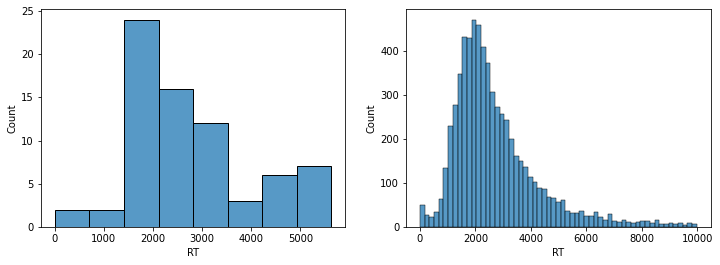

In [9]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
sns.histplot(df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus["RT"]<10000,"RT"], ax=axs[1])

plt.plot()

print('std:\n',df_cfmt_raw_Aus[df_cfmt_raw_Aus["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
df_cfmt_raw_Aus[df_cfmt_raw_Aus["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [10]:
suspect_combined = list(set(suspects)|set(suspects_level1))

# print('std:\n',df_cfmt_raw_Aus[df_cfmt_raw_Aus["userID"].isin(suspect_combined)].groupby(['userID']).std(), '\n\nmean:\n')
print(df_cfmt_raw_Aus['correct'].mean())
print(df_cfmt_raw_Aus[df_cfmt_raw_Aus["userID"].isin(suspect_combined)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw_Aus.groupby(['stage'])['correct'].mean())
df_cfmt_raw_Aus[df_cfmt_raw_Aus["userID"].isin(suspect_combined)].groupby(['userID', 'stage']).mean()

0.7303486997635934
         correct            RT
userID                        
s_120   0.472222   2746.084444
s_124   0.500000   1581.497417
s_134   0.722222  11935.650250
s_136   0.513889   2702.605069
s_140   0.458333   3706.963319
s_197   0.444444   1004.058417
s_232   0.444444   1349.502500
s_69    0.500000   4029.455278
s_86    0.472222    816.279861

Stages

stage
1    0.965721
2    0.753546
3    0.524823
Name: correct, dtype: float64


correct            RT
userID stage                        
s_120  1      0.888889   2802.808778
       2      0.333333   2946.060767
       3      0.333333   2453.570792
s_124  1      0.888889   1785.565778
       2      0.466667   1681.292200
       3      0.250000   1303.702667
s_134  1      0.833333   1226.152333
       2      0.866667  25527.204000
       3      0.458333   2978.331500
s_136  1      0.833333   2729.405389
       2      0.533333   2711.397933
       3      0.250000   2671.513750
s_140  1      0.833333   3886.137722
       2      0.433333   4065.509000
       3      0.208333   3124.400417
s_197  1      0.888889   1361.608278
       2      0.133333    922.626234
       3      0.500000    837.686250
s_232  1      0.888889   1714.549833
       2      0.300000   1275.891300
       3      0.291667   1167.731000
s_69   1      0.888889   2783.904444
       2      0.400000   5044.301333
       3      0.333333   3695.060833
s_86   1      0.888889   1831.191833
       2      0.433333    628.580833
       3      0.208333    289.719667

In [11]:
print(df_cfmt_raw_Aus['correct'].mean())
print(df_cfmt_raw_Aus[df_cfmt_raw_Aus["userID"].isin(suspects_level1)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw_Aus.groupby(['stage'])['correct'].mean())
df_cfmt_raw_Aus[df_cfmt_raw_Aus["userID"].isin(suspects_level1)].groupby(['userID', 'stage']).mean()

0.7303486997635934
         correct            RT
userID                        
s_134   0.722222  11935.650250
s_136   0.513889   2702.605069
s_140   0.458333   3706.963319

Stages

stage
1    0.965721
2    0.753546
3    0.524823
Name: correct, dtype: float64


correct            RT
userID stage                        
s_134  1      0.833333   1226.152333
       2      0.866667  25527.204000
       3      0.458333   2978.331500
s_136  1      0.833333   2729.405389
       2      0.533333   2711.397933
       3      0.250000   2671.513750
s_140  1      0.833333   3886.137722
       2      0.433333   4065.509000
       3      0.208333   3124.400417

In [12]:
print(f"""Removing {len(df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_cfmt_raw_Aus = df_cfmt_raw_Aus.loc[df_cfmt_raw_Aus['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_cfmt_raw_Aus = df_cfmt_raw_Aus[~df_cfmt_raw_Aus['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_cfmt_raw_Aus.userID.unique().size} participants.")
################
# save
df_cfmt_raw_Aus.to_csv(os.path.join(csv_clean_data_path, "CFMT_Aus-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'CFMT_Aus',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "CFMT_Aus-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 94 participants.


In [13]:
print(df_cfmt_raw_Aus.userID.value_counts()[df_cfmt_raw_Aus.userID.value_counts()>72])#.keys()
print(df_cfmt_raw_Aus.userID.value_counts()[df_cfmt_raw_Aus.userID.value_counts()<72])

Series([], Name: userID, dtype: int64)
Series([], Name: userID, dtype: int64)


##### Female version

In [14]:
# load data
df_cfmt_raw_F = pd.read_csv(os.path.join(csv_raw_data_path, 'CFMT_F_standalone_data.csv'),
                                 usecols=["user_id", "sender_id", "sender", "observation", "correct", 
                                          "timestamp", "x",
                                          "response", "correct_response",
                                          "duration"
                                         ]
                                 ).rename(columns={"user_id":"userID", "duration":"RT"})

# check if someone accessed twice
check_double_access(df_cfmt_raw_F)
    
# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_cfmt_raw_F)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_cfmt_raw_F.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data

# remove the nans in sender id
df_cfmt_raw_F = df_cfmt_raw_F[~df_cfmt_raw_F["sender_id"].isna()]

# add stage
df_cfmt_raw_F['stage'] = ''

# fill it
# stage 1
df_cfmt_raw_F.loc[df_cfmt_raw_F["sender"]=='Stage 1 Test Face',"stage"] = '1'

# stage 2
df_cfmt_raw_F.loc[(df_cfmt_raw_F["sender_id"].str.startswith('10')) & (df_cfmt_raw_F["sender"]=='Faces'), "stage"] = '2'

# stage 3
df_cfmt_raw_F.loc[(df_cfmt_raw_F["sender_id"].str.startswith('12')) & (df_cfmt_raw_F["sender"]=='Faces'), "stage"] = '3'


# select only the real trials -- have stage
# df_cfmt_raw_F = df_cfmt_raw_F.loc[df_cfmt_raw_F["stage"]!='',["observation", "userID", "correct", "stage"]]
df_cfmt_raw_F = df_cfmt_raw_F.loc[df_cfmt_raw_F["stage"]!='']

# TODO - check
# drop the people who don't have a full dataset
not_full_participants = df_cfmt_raw_F["observation"].value_counts()[df_cfmt_raw_F["observation"].value_counts() < 72].keys()
df_cfmt_raw_F = df_cfmt_raw_F[~df_cfmt_raw_F["observation"].isin(not_full_participants)]



#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_cfmt_raw_F["userID"].value_counts()[df_cfmt_raw_F["userID"].value_counts() != 72].keys()

if not double_visits.empty:
    relevant_observation = df_cfmt_raw_F.loc[df_cfmt_raw_F["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_cfmt_raw_F = df_cfmt_raw_F[~df_cfmt_raw_F["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again if someone accessed twice
check_double_access(df_cfmt_raw_F)

### Quality checks
df_cfmt_raw_F["correct"] = df_cfmt_raw_F["correct"].astype(float)

# find people with low acc on the first level - border line
suspects_level1 = df_cfmt_raw_F[df_cfmt_raw_F["stage"]=='1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw_F.loc[df_cfmt_raw_F["stage"]=='1'].groupby(['userID']).mean()['correct']==15/18
].index.tolist()

# exclude all that have less
exclude_ptc_level1 = df_cfmt_raw_F[df_cfmt_raw_F["stage"]=='1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw_F.loc[df_cfmt_raw_F["stage"]=='1'].groupby(['userID']).mean()['correct']<15/18
].index.tolist()
print(f'There are {len(suspects_level1)} suspects with low acc on 1st level and {len(exclude_ptc_level1)} excluded.\n')

# exclude the low acc on level 1
df_cfmt_raw_F = df_cfmt_raw_F[~df_cfmt_raw_F['userID'].isin(exclude_ptc_level1)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_cfmt_raw_F)
print(f'- There are {len(set(suspects)&set(suspects_level1))} overlapping suspects.\n{set(suspects)&set(suspects_level1)}')
# select only relevant
df_cfmt_raw_F = df_cfmt_raw_F[["observation", "userID", "correct", "RT", "stage"]]

# sort the df to easily find changes in csv file when updated
df_cfmt_raw_F.sort_values(by=["userID"], inplace=True)


There are 95 participants (observations) and 94 unique IDs! Check!

All is ok.
There are now 94 participants (observations) and 94 unique IDs.

There are 7 suspects with low acc on 1st level and 7 excluded.

Series([], Name: RT, dtype: float64)
In the task, there are 9 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 6 and mean of max per subject is 4.11 +/- 1.54.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()
- There are 3 overlapping suspects.
{'s_92', 's_197', 's_26'}


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 95 participants (observations) and 94 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


In [15]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_cfmt_raw_F.loc[df_cfmt_raw_F["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_cfmt_raw_F.loc[df_cfmt_raw_F["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()

# print('std:\n',df_cfmt_raw_F[df_cfmt_raw_F["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
# df_cfmt_raw_F[df_cfmt_raw_F["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [16]:
suspect_combined = list(set(suspects)|set(suspects_level1))

# print('std:\n',df_cfmt_raw_F[df_cfmt_raw_F["userID"].isin(suspect_combined)].groupby(['userID']).std(), '\n\nmean:\n')
print(df_cfmt_raw_F['correct'].mean())
print(df_cfmt_raw_F[df_cfmt_raw_F["userID"].isin(suspect_combined)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw_F.groupby(['stage'])['correct'].mean())
df_cfmt_raw_F[df_cfmt_raw_F["userID"].isin(suspect_combined)].groupby(['userID', 'stage']).mean()

0.8330140485312899
         correct           RT
userID                       
s_108   0.611111  2940.379194
s_122   0.638889  8507.116972
s_150   0.638889  1656.226083
s_197   0.458333  1155.087153
s_211   0.819444  2089.024722
s_214   0.638889  1798.731792
s_223   0.777778  2345.356556
s_242   0.680556  3613.612292
s_26    0.597222  1756.542764
s_28    0.638889  2254.456750
s_35    0.708333  3139.318278
s_45    0.458333   747.894736
s_92    0.569444  1392.013153

Stages

stage
1    0.966794
2    0.855172
3    0.704981
Name: correct, dtype: float64


correct           RT
userID stage                       
s_108  1      1.000000  2319.040111
       2      0.533333  3868.900467
       3      0.416667  2245.731917
s_122  1      0.944444  6684.468000
       2      0.533333  8804.284034
       3      0.541667  9502.644875
s_150  1      0.944444  2238.936778
       2      0.666667  1447.021833
       3      0.375000  1480.698375
s_197  1      0.833333  1655.689500
       2      0.366667  1037.944267
       3      0.291667   926.064000
s_211  1      0.833333  1965.213667
       2      0.900000  2239.107333
       3      0.708333  1994.279750
s_214  1      0.944444  1757.705000
       2      0.633333  2273.974567
       3      0.416667  1235.448417
s_223  1      0.833333  2066.108778
       2      0.900000  2338.533933
       3      0.583333  2563.320667
s_242  1      0.833333  2853.615833
       2      0.666667  3587.918067
       3      0.583333  4215.727417
s_26   1      0.833333  2300.629333
       2      0.566667  2024.870200
       3      0.458333  1013.068542
s_28   1      0.944444  2388.077833
       2      0.666667  2211.970167
       3      0.375000  2207.349167
s_35   1      0.833333  1856.819833
       2      0.833333  2877.595400
       3      0.458333  4428.345708
s_45   1      0.888889  1318.503333
       2      0.400000   578.365033
       3      0.208333   531.850417
s_92   1      0.833333  1417.588889
       2      0.600000  1500.729500
       3      0.333333  1236.935917

In [17]:
print(df_cfmt_raw_F['correct'].mean())
print(df_cfmt_raw_F[df_cfmt_raw_F["userID"].isin(suspects_level1)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw_F.groupby(['stage'])['correct'].mean())
df_cfmt_raw_F[df_cfmt_raw_F["userID"].isin(suspects_level1)].groupby(['userID', 'stage']).mean()

0.8330140485312899
         correct           RT
userID                       
s_197   0.458333  1155.087153
s_211   0.819444  2089.024722
s_223   0.777778  2345.356556
s_242   0.680556  3613.612292
s_26    0.597222  1756.542764
s_35    0.708333  3139.318278
s_92    0.569444  1392.013153

Stages

stage
1    0.966794
2    0.855172
3    0.704981
Name: correct, dtype: float64


correct           RT
userID stage                       
s_197  1      0.833333  1655.689500
       2      0.366667  1037.944267
       3      0.291667   926.064000
s_211  1      0.833333  1965.213667
       2      0.900000  2239.107333
       3      0.708333  1994.279750
s_223  1      0.833333  2066.108778
       2      0.900000  2338.533933
       3      0.583333  2563.320667
s_242  1      0.833333  2853.615833
       2      0.666667  3587.918067
       3      0.583333  4215.727417
s_26   1      0.833333  2300.629333
       2      0.566667  2024.870200
       3      0.458333  1013.068542
s_35   1      0.833333  1856.819833
       2      0.833333  2877.595400
       3      0.458333  4428.345708
s_92   1      0.833333  1417.588889
       2      0.600000  1500.729500
       3      0.333333  1236.935917

In [18]:
print(f"""Removing {len(df_cfmt_raw_F.loc[df_cfmt_raw_F['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_cfmt_raw_F.loc[df_cfmt_raw_F['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_cfmt_raw_F = df_cfmt_raw_F.loc[df_cfmt_raw_F['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = ['s_223', 's_211']

df_cfmt_raw_F = df_cfmt_raw_F[~df_cfmt_raw_F['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_cfmt_raw_F.userID.unique().size} participants.")
################
# save
df_cfmt_raw_F.to_csv(os.path.join(csv_clean_data_path, "CFMT_F-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'CFMT_F',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "CFMT_F-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 85 participants.


In [19]:
print(df_cfmt_raw_F.userID.value_counts()[df_cfmt_raw_F.userID.value_counts()>72])#.keys()
print(df_cfmt_raw_F.userID.value_counts()[df_cfmt_raw_F.userID.value_counts()<72])

Series([], Name: userID, dtype: int64)
Series([], Name: userID, dtype: int64)


#### Set 3 (November 2022)
[top](#top)

##### Australia

In [20]:
# load all the data and tasks but take only relevant columns
df_raw = pd.read_csv(os.path.join(csv_raw_data_path, 'RISE_CFMT_AOS_RPM_OSVIQ_data.csv'),
                     usecols=["user_id", "sender_id", "sender", "observation", "correct",
                              "timestamp", "x",
                              "response", "correct_response",
                              "duration"
                              ]
                     ).rename(columns={"user_id": "userID", "duration": "RT"})


# check if someone accessed twice
check_double_access(df_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_raw)


# for this subject, take only c3e66
# 60e2dd15559e58d166dd3395 - ad2b1 : didn't finish AOS (definitely didn't do OSVIQ) - completed again, obs : c3e66
df_raw = df_raw[~df_raw['observation'].isin(['ad2b1'])]

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()
# take only one row
df_first_visit = df_first_visit[df_first_visit["x"]=="Continue"]
# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

########### Cleaning
# take only CFMT Aus and select only real trials
# df_cfmt_raw_Aus2 = df_raw.loc[(df_raw["sender_id"].str.startswith("2_", na=False))]
# this is a stricter selector that would help with large data. Previously, this was done using the stage, this is also ok
df_cfmt_raw_Aus2 = df_raw.loc[(df_raw["sender_id"].str.startswith("2_", na=False)) & (df_raw["sender"].isin(["Stage 1 Test Face", "Faces"]))]

# # remove the nans in sender id - there should not be any
# df_cfmt_raw_Aus2 = df_cfmt_raw_Aus2[~df_cfmt_raw_Aus2["sender_id"].isna()]

# add stage
df_cfmt_raw_Aus2['stage'] = ''

# fill it
# stage 1
df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2["sender"] == 'Stage 1 Test Face', "stage"] = '1'

# stage 2
df_cfmt_raw_Aus2.loc[(df_cfmt_raw_Aus2["sender_id"].str.startswith('2_9')) & (df_cfmt_raw_Aus2["sender"] == 'Faces'), "stage"] = '2'

# stage 3
df_cfmt_raw_Aus2.loc[(df_cfmt_raw_Aus2["sender_id"].str.startswith('2_11')) & (df_cfmt_raw_Aus2["sender"] == 'Faces'), "stage"] = '3'

# select only the real trials -- have stage, NOTE - should be already cleaned
# df_cfmt_raw_Aus2 = df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2["stage"]!='',["observation", "userID", "correct", "stage"]]
df_cfmt_raw_Aus2 = df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2["stage"] != '']

# drop the people who don't have a full dataset
not_full_participants = df_cfmt_raw_Aus2["observation"].value_counts()[df_cfmt_raw_Aus2["observation"].value_counts() < 72].keys()
df_cfmt_raw_Aus2 = df_cfmt_raw_Aus2[~df_cfmt_raw_Aus2["observation"].isin(not_full_participants)]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_cfmt_raw_Aus2["userID"].value_counts()[df_cfmt_raw_Aus2["userID"].value_counts() != 72].keys()

if not double_visits.empty:
    relevant_observation = df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_cfmt_raw_Aus2 = df_cfmt_raw_Aus2[~df_cfmt_raw_Aus2["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_cfmt_raw_Aus2)

### Quality checks
# convert values to bool
df_cfmt_raw_Aus2['correct'] = df_cfmt_raw_Aus2['correct'].map({'FALSE':0, 'TRUE':1})
# df_cfmt_raw_Aus2["correct"] = df_cfmt_raw_Aus2["correct"].astype(float)

# find people with low acc on the first level - border line
suspects_level1 = df_cfmt_raw_Aus2[df_cfmt_raw_Aus2["stage"] == '1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2["stage"] == '1'].groupby(['userID']).mean()['correct'] == 15 / 18
    ].index.tolist()

# exclude all that have less
exclude_ptc_level1 = df_cfmt_raw_Aus2[df_cfmt_raw_Aus2["stage"] == '1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2["stage"] == '1'].groupby(['userID']).mean()['correct'] < 15 / 18
    ].index.tolist()
print(f'There are {len(suspects_level1)} suspects with low acc on 1st level and {len(exclude_ptc_level1)} excluded.\n')

# exclude the low acc on level 1
df_cfmt_raw_Aus2 = df_cfmt_raw_Aus2[~df_cfmt_raw_Aus2['userID'].isin(exclude_ptc_level1)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_cfmt_raw_Aus2)
print(f'- There are {len(set(suspects) & set(suspects_level1))} overlapping suspects.\n{set(suspects)&set(suspects_level1)}')
# select only relevant
df_cfmt_raw_Aus2 = df_cfmt_raw_Aus2[["observation", "userID", "correct", "RT", "stage"]]

# sort the df to easily find changes in csv file when updated
df_cfmt_raw_Aus2.sort_values(by=["userID", "stage"], inplace=True)

There are 137 participants (observations) and 126 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 137 participants (observations) and 126 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_11034/872762827.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cfmt_raw_Aus2['stage'] = ''
/Users/jan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

All is ok.
There are now 121 participants (observations) and 121 unique IDs.

There are 3 suspects with low acc on 1st level and 3 excluded.

Series([], Name: RT, dtype: float64)
In the task, there are 5 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 5 and mean of max per subject is 3.00 +/- 0.71.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()
- There are 1 overlapping suspects.
{'s_140'}


In [21]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()

In [22]:
# print('std:\n',df_cfmt_raw_Aus2[df_cfmt_raw_Aus2["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
# df_cfmt_raw_Aus2[df_cfmt_raw_Aus2["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [23]:
suspect_combined = list(set(suspects)|set(suspects_level1))

# print('std:\n',df_cfmt_raw_Aus2[df_cfmt_raw_Aus2["userID"].isin(suspect_combined)].groupby(['userID']).std(), '\n\nmean:\n')
print(df_cfmt_raw_Aus2['correct'].mean())
print(df_cfmt_raw_Aus2[df_cfmt_raw_Aus2["userID"].isin(suspect_combined)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw_Aus2.groupby(['stage'])['correct'].mean())
df_cfmt_raw_Aus2[df_cfmt_raw_Aus2["userID"].isin(suspect_combined)].groupby(['userID', 'stage']).mean()


0.7614171374764596
         correct           RT
userID                       
s_125   0.472222  2350.808694
s_140   0.513889  3052.876861
s_160   0.833333  2780.014222
s_167   0.500000   869.968889
s_232   0.513889  4326.336722
s_28    0.611111  2374.771750
s_56    0.513889  2162.973653

Stages

stage
1    0.970810
2    0.790960
3    0.567444
Name: correct, dtype: float64


correct           RT
userID stage                       
s_125  1      1.000000  1913.603889
       2      0.233333  3698.703767
       3      0.375000   993.843458
s_140  1      0.833333  3159.346833
       2      0.433333  3330.855767
       3      0.375000  2625.550750
s_160  1      0.833333  2135.776556
       2      0.866667  2709.290333
       3      0.791667  3351.597333
s_167  1      0.944444  1370.505444
       2      0.400000   913.839800
       3      0.291667   439.727833
s_232  1      0.944444  3686.592167
       2      0.400000  5842.840500
       3      0.333333  2910.515417
s_28   1      0.833333  2255.292778
       2      0.566667  2498.953433
       3      0.500000  2309.153875
s_56   1      0.888889  1736.179889
       2      0.500000  2614.981900
       3      0.250000  1918.058667

In [24]:
print(df_cfmt_raw_Aus2['correct'].mean())
print(df_cfmt_raw_Aus2[df_cfmt_raw_Aus2["userID"].isin(suspects_level1)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw_Aus2.groupby(['stage'])['correct'].mean())
df_cfmt_raw_Aus2[df_cfmt_raw_Aus2["userID"].isin(suspects_level1)].groupby(['userID', 'stage']).mean()


0.7614171374764596
         correct           RT
userID                       
s_140   0.513889  3052.876861
s_160   0.833333  2780.014222
s_28    0.611111  2374.771750

Stages

stage
1    0.970810
2    0.790960
3    0.567444
Name: correct, dtype: float64


correct           RT
userID stage                       
s_140  1      0.833333  3159.346833
       2      0.433333  3330.855767
       3      0.375000  2625.550750
s_160  1      0.833333  2135.776556
       2      0.866667  2709.290333
       3      0.791667  3351.597333
s_28   1      0.833333  2255.292778
       2      0.566667  2498.953433
       3      0.500000  2309.153875

In [25]:
print(f"""Removing {len(df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_cfmt_raw_Aus2 = df_cfmt_raw_Aus2.loc[df_cfmt_raw_Aus2['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = ['s_160']

df_cfmt_raw_Aus2 = df_cfmt_raw_Aus2[~df_cfmt_raw_Aus2['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_cfmt_raw_Aus2.userID.unique().size} participants.")
################
# save
df_cfmt_raw_Aus2.to_csv(os.path.join(csv_clean_data_path, "CFMT_Aus2-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'CFMT_Aus2',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "CFMT_Aus2-flagged_ptc.csv"), index=False)

print('\nCheck trials')
print(df_cfmt_raw_Aus2.userID.value_counts()[df_cfmt_raw_Aus2.userID.value_counts()>72])#.keys()
print(df_cfmt_raw_Aus2.userID.value_counts()[df_cfmt_raw_Aus2.userID.value_counts()<72])

Removing 0 subjects with not all data/consents
      []

Saving 117 participants.

Check trials
Series([], Name: userID, dtype: int64)
Series([], Name: userID, dtype: int64)


##### Female version

In [26]:
# load all the data and tasks but take only relevant columns
df_raw = pd.read_csv(os.path.join(csv_raw_data_path, 'RISE_CFMT_AOS_RPM_OSVIQ_data.csv'),
                     usecols=["user_id", "sender_id", "sender", "observation", "correct",
                              "timestamp", "x",
                              "response", "correct_response",
                              "duration"
                              ]
                     ).rename(columns={"user_id": "userID", "duration": "RT"})


# check if someone accessed twice
check_double_access(df_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_raw)


# for this subject, take only c3e66
# 60e2dd15559e58d166dd3395 - ad2b1 : didn't finish AOS (definitely didn't do OSVIQ) - completed again, obs : c3e66
df_raw = df_raw[~df_raw['observation'].isin(['ad2b1'])]

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()
# take only one row
df_first_visit = df_first_visit[df_first_visit["x"]=="Continue"]
# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

########### Cleaning
# take only CFMT Female and select only real trials
# df_cfmt_raw_F2 = df_raw.loc[(df_raw["sender_id"].str.startswith("2_", na=False))]
# this is a stricter selector that would help with large data. Previously, this was done using the stage, this is also ok
df_cfmt_raw_F2 = df_raw.loc[(df_raw["sender_id"].str.startswith("4_", na=False)) & (df_raw["sender"].isin(["Stage 1 Test Face", "Faces"]))]

# # remove the nans in sender id - there should not be any
# df_cfmt_raw_F2 = df_cfmt_raw_F2[~df_cfmt_raw_F2["sender_id"].isna()]

# add stage
df_cfmt_raw_F2['stage'] = ''

# fill it
# stage 1
df_cfmt_raw_F2.loc[df_cfmt_raw_F2["sender"] == 'Stage 1 Test Face', "stage"] = '1'

# stage 2
df_cfmt_raw_F2.loc[(df_cfmt_raw_F2["sender_id"].str.startswith('4_5')) & (df_cfmt_raw_F2["sender"] == 'Faces'), "stage"] = '2'

# stage 3
df_cfmt_raw_F2.loc[(df_cfmt_raw_F2["sender_id"].str.startswith('4_7')) & (df_cfmt_raw_F2["sender"] == 'Faces'), "stage"] = '3'

# select only the real trials -- have stage, NOTE - should be already cleaned
# df_cfmt_raw_F2 = df_cfmt_raw_F2.loc[df_cfmt_raw_F2["stage"]!='',["observation", "userID", "correct", "stage"]]
df_cfmt_raw_F2 = df_cfmt_raw_F2.loc[df_cfmt_raw_F2["stage"] != '']

# drop the people who don't have a full dataset
not_full_participants = df_cfmt_raw_F2["observation"].value_counts()[df_cfmt_raw_F2["observation"].value_counts() < 72].keys()
df_cfmt_raw_F2 = df_cfmt_raw_F2[~df_cfmt_raw_F2["observation"].isin(not_full_participants)]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_cfmt_raw_F2["userID"].value_counts()[df_cfmt_raw_F2["userID"].value_counts() != 72].keys()

if not double_visits.empty:
    relevant_observation = df_cfmt_raw_F2.loc[df_cfmt_raw_F2["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_cfmt_raw_F2 = df_cfmt_raw_F2[~df_cfmt_raw_F2["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_cfmt_raw_F2)

### Quality checks
# convert values to bool
df_cfmt_raw_F2['correct'] = df_cfmt_raw_F2['correct'].map({'FALSE':0, 'TRUE':1})
# df_cfmt_raw_F2["correct"] = df_cfmt_raw_F2["correct"].astype(float)

# find people with low acc on the first level - border line
suspects_level1 = df_cfmt_raw_F2[df_cfmt_raw_F2["stage"] == '1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw_F2.loc[df_cfmt_raw_F2["stage"] == '1'].groupby(['userID']).mean()['correct'] == 15 / 18
    ].index.tolist()

# exclude all that have less
exclude_ptc_level1 = df_cfmt_raw_F2[df_cfmt_raw_F2["stage"] == '1'].groupby(['userID']).mean()['correct'][
    df_cfmt_raw_F2.loc[df_cfmt_raw_F2["stage"] == '1'].groupby(['userID']).mean()['correct'] < 15 / 18
    ].index.tolist()
print(f'There are {len(suspects_level1)} suspects with low acc on 1st level and {len(exclude_ptc_level1)} excluded.\n')

# exclude the low acc on level 1
df_cfmt_raw_F2 = df_cfmt_raw_F2[~df_cfmt_raw_F2['userID'].isin(exclude_ptc_level1)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_cfmt_raw_F2)
print(f'- There are {len(set(suspects) & set(suspects_level1))} overlapping suspects.\n{set(suspects)&set(suspects_level1)}')
# select only relevant
df_cfmt_raw_F2 = df_cfmt_raw_F2[["observation", "userID", "correct", "RT", "stage"]]

# sort the df to easily find changes in csv file when updated
df_cfmt_raw_F2.sort_values(by=["userID", "stage"], inplace=True)


There are 137 participants (observations) and 126 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 137 participants (observations) and 126 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_11034/1455436495.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cfmt_raw_F2['stage'] = ''
/Users/jan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

All is ok.
There are now 120 participants (observations) and 120 unique IDs.

There are 5 suspects with low acc on 1st level and 9 excluded.

Series([], Name: RT, dtype: float64)
In the task, there are 9 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 6 and mean of max per subject is 3.56 +/- 1.01.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()
- There are 1 overlapping suspects.
{'s_156'}


In [27]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_cfmt_raw_F2.loc[df_cfmt_raw_F2["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_cfmt_raw_F2.loc[df_cfmt_raw_F2["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()


In [28]:
# print('std:\n',df_cfmt_raw_F2[df_cfmt_raw_F2["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
# df_cfmt_raw_F2[df_cfmt_raw_F2["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [29]:
suspect_combined = list(set(suspects)|set(suspects_level1))

# print('std:\n',df_cfmt_raw_F2[df_cfmt_raw_F2["userID"].isin(suspect_combined)].groupby(['userID']).std(), '\n\nmean:\n')
print(df_cfmt_raw_F2['correct'].mean())
print(df_cfmt_raw_F2[df_cfmt_raw_F2["userID"].isin(suspect_combined)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw_F2.groupby(['stage'])['correct'].mean())
df_cfmt_raw_F2[df_cfmt_raw_F2["userID"].isin(suspect_combined)].groupby(['userID', 'stage']).mean()


0.8519769769769769
         correct           RT
userID                       
s_125   0.638889  1913.784125
s_127   0.680556  2023.678694
s_130   0.430556   822.053958
s_132   0.666667  1590.707403
s_140   0.611111  2733.624139
s_156   0.569444  3279.996861
s_167   0.513889   473.196514
s_191   0.513889  4836.871139
s_197   0.541667  1107.028167
s_200   0.763889  2152.246389
s_211   0.680556  2239.422417
s_45    0.583333   899.314430
s_62    0.680556  3100.144500

Stages

stage
1    0.963463
2    0.860961
3    0.757132
Name: correct, dtype: float64


correct           RT
userID stage                       
s_125  1      1.000000  2322.309056
       2      0.800000  2410.070767
       3      0.166667   987.032125
s_127  1      0.833333  2233.350722
       2      0.633333  2208.898833
       3      0.625000  1634.899500
s_130  1      0.888889  1855.687111
       2      0.333333   277.503300
       3      0.208333   727.517417
s_132  1      0.888889  1753.185611
       2      0.633333  1596.746267
       3      0.541667  1461.300167
s_140  1      0.888889  3249.785944
       2      0.633333  2591.760600
       3      0.375000  2523.832208
s_156  1      0.833333  2312.308500
       2      0.533333  4140.864700
       3      0.416667  2929.678333
s_167  1      0.944444  1474.846278
       2      0.400000   138.154767
       3      0.333333   140.761375
s_191  1      1.000000  1840.199278
       2      0.300000  6329.041133
       3      0.416667  5219.162542
s_197  1      0.944444  1587.071111
       2      0.400000   979.129533
       3      0.416667   906.869250
s_200  1      0.833333  1748.673333
       2      0.800000  2237.766667
       3      0.666667  2348.025833
s_211  1      0.833333  2604.677167
       2      0.666667  2246.995933
       3      0.583333  1956.014458
s_45   1      1.000000  1276.414111
       2      0.566667  1069.937967
       3      0.291667   403.210250
s_62   1      0.833333  3312.933222
       2      0.700000  3241.518900
       3      0.541667  2763.834958

In [30]:
print(df_cfmt_raw_F2['correct'].mean())
print(df_cfmt_raw_F2[df_cfmt_raw_F2["userID"].isin(suspects_level1)].groupby(['userID']).mean())
print('\nStages\n')
print(df_cfmt_raw_F2.groupby(['stage'])['correct'].mean())
df_cfmt_raw_F2[df_cfmt_raw_F2["userID"].isin(suspects_level1)].groupby(['userID', 'stage']).mean()


0.8519769769769769
         correct           RT
userID                       
s_127   0.680556  2023.678694
s_156   0.569444  3279.996861
s_200   0.763889  2152.246389
s_211   0.680556  2239.422417
s_62    0.680556  3100.144500

Stages

stage
1    0.963463
2    0.860961
3    0.757132
Name: correct, dtype: float64


correct           RT
userID stage                       
s_127  1      0.833333  2233.350722
       2      0.633333  2208.898833
       3      0.625000  1634.899500
s_156  1      0.833333  2312.308500
       2      0.533333  4140.864700
       3      0.416667  2929.678333
s_200  1      0.833333  1748.673333
       2      0.800000  2237.766667
       3      0.666667  2348.025833
s_211  1      0.833333  2604.677167
       2      0.666667  2246.995933
       3      0.583333  1956.014458
s_62   1      0.833333  3312.933222
       2      0.700000  3241.518900
       3      0.541667  2763.834958

In [31]:
print(f"""Removing {len(df_cfmt_raw_F2.loc[df_cfmt_raw_F2['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_cfmt_raw_F2.loc[df_cfmt_raw_F2['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_cfmt_raw_F2 = df_cfmt_raw_F2.loc[df_cfmt_raw_F2['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = ['s_200']

df_cfmt_raw_F2 = df_cfmt_raw_F2[~df_cfmt_raw_F2['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_cfmt_raw_F2.userID.unique().size} participants.")
################
# save
df_cfmt_raw_F2.to_csv(os.path.join(csv_clean_data_path, "CFMT_F2-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'CFMT_F2',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "CFMT_F2-flagged_ptc.csv"), index=False)

print('\nCheck trials')
print(df_cfmt_raw_F2.userID.value_counts()[df_cfmt_raw_F2.userID.value_counts()>72])#.keys()
print(df_cfmt_raw_F2.userID.value_counts()[df_cfmt_raw_F2.userID.value_counts()<72])

Removing 0 subjects with not all data/consents
      []

Saving 110 participants.

Check trials
Series([], Name: userID, dtype: int64)
Series([], Name: userID, dtype: int64)


----

## Car matching
[top](#top)

### Prepare and process car matching
[top](#top)

#### Set 1

In [2]:
# concat both full data and pilot data
df_car_matching_raw = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'car_matching_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "timestamp", "x",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"}),
    # add also pilot data
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'car_matching_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "timestamp", "x",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"})
])

# check if someone accessed twice
check_double_access(df_car_matching_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_car_matching_raw)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_car_matching_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

################
# Clean the data to be able to get people who have all trials

df_car_matching_raw = df_car_matching_raw[~df_car_matching_raw["sender_id"].isna()]

# all the real trials are denoted with 2_3 and it's just the car
df_car_matching_raw = df_car_matching_raw[(df_car_matching_raw["sender_id"].str.startswith("2_3")) & \
                                          ((df_car_matching_raw["sender"] == "Match Screen no car") | (
                                                      df_car_matching_raw["sender"] == "Match Screen"))]

# drop all the nans which will merge the answers from late trials and fresh trials
df_car_matching_raw = df_car_matching_raw[~df_car_matching_raw["correct"].isna()]

# TODO - check
# drop the people who don't have a full dataset
not_full_participants = df_car_matching_raw["observation"].value_counts()[
    df_car_matching_raw["observation"].value_counts() < 40].keys()
df_car_matching_raw = df_car_matching_raw[~df_car_matching_raw["observation"].isin(not_full_participants)]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_car_matching_raw["userID"].value_counts()[df_car_matching_raw["userID"].value_counts() != 40].keys()

if not double_visits.empty:
    relevant_observation = df_car_matching_raw.loc[
        df_car_matching_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(
        subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_car_matching_raw = df_car_matching_raw[
        ~df_car_matching_raw["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_car_matching_raw)

# do flag analysis
flagged_ptc, suspects = flag_participants(df_car_matching_raw, RT_thr=10000)
# select only relevant
df_car_matching_raw = df_car_matching_raw[["observation", "userID", "correct", "RT"]]

# sort the df to easily find changes in csv file when updated
df_car_matching_raw.sort_values(by=["userID"], inplace=True)


There are 272 participants (observations) and 253 unique IDs! Check!

All is ok.
There are now 252 participants (observations) and 252 unique IDs.

Series([], Name: RT, dtype: float64)
In the task, there are 21 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 3 and mean of max per subject is 3.76 +/- 0.94.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 272 participants (observations) and 253 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


In [3]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_car_matching_raw.loc[df_car_matching_raw["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_car_matching_raw.loc[df_car_matching_raw["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()

# print('std:\n',df_car_matching_raw[df_car_matching_raw["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
# df_car_matching_raw[df_car_matching_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [4]:
print('\n', df_car_matching_raw.mean())
df_car_matching_raw[df_car_matching_raw["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()



 correct       0.750496
RT         1171.746839
dtype: float64


,correct,RT
userID,,
s_108,0.400,1298.228100
s_113,0.525,1109.653350
s_121,0.425,1194.655500
s_131,0.500,1215.515000
s_150,0.525,1263.560175
s_151,0.525,1094.748525
s_160,0.500,1263.087550
s_179,0.525,1240.302575
s_182,0.475,1074.463425


In [5]:
print(f"""Removing {len(df_car_matching_raw.loc[df_car_matching_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_car_matching_raw.loc[df_car_matching_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_car_matching_raw = df_car_matching_raw.loc[df_car_matching_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_car_matching_raw = df_car_matching_raw[~df_car_matching_raw['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_car_matching_raw.userID.unique().size} participants.")
################
# save
df_car_matching_raw.to_csv(os.path.join(csv_clean_data_path, "car_matching-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'car_matching',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "car_matching-flagged_ptc.csv"), index=False)

Removing 2 subjects with not all data/consents
      ['s_258' 's_269']

Saving 250 participants.


In [6]:
df_car_matching_raw.userID.value_counts()[df_car_matching_raw.userID.value_counts()>40]#.keys()

Series([], Name: userID, dtype: int64)

#### Set 2 (Feb 2022)

In [7]:
## LOAD repetition data

df_car_matching_raw_rep = pd.read_csv(os.path.join(csv_raw_data_path, 'car_matching_standalone_data.csv'),
                                 usecols=["user_id", "sender_id", "sender", "observation", "correct", 
                                          "timestamp", "x",
                                          "response", "correct_response",
                                          "duration"
                                         ]
                                 ).rename(columns={"user_id":"userID", "duration":"RT"})


# check if someone accessed twice
check_double_access(df_car_matching_raw_rep)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_car_matching_raw_rep)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_car_matching_raw_rep.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

################
# Clean the data to be able to get people who have all trials

df_car_matching_raw_rep = df_car_matching_raw_rep[~df_car_matching_raw_rep["sender_id"].isna()]

# all the real trials are denoted with 2_3 and it's just the car
df_car_matching_raw_rep = df_car_matching_raw_rep[(df_car_matching_raw_rep["sender_id"].str.startswith("2_3")) & \
                                          ((df_car_matching_raw_rep["sender"] == "Match Screen no car") | (
                                                      df_car_matching_raw_rep["sender"] == "Match Screen"))]

# drop all the nans which will merge the answers from late trials and fresh trials
df_car_matching_raw_rep = df_car_matching_raw_rep[~df_car_matching_raw_rep["correct"].isna()]

# TODO - check
# drop the people who don't have a full dataset
not_full_participants = df_car_matching_raw_rep["observation"].value_counts()[
    df_car_matching_raw_rep["observation"].value_counts() < 40].keys()
df_car_matching_raw_rep = df_car_matching_raw_rep[~df_car_matching_raw_rep["observation"].isin(not_full_participants)]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_car_matching_raw_rep["userID"].value_counts()[df_car_matching_raw_rep["userID"].value_counts() != 40].keys()

if not double_visits.empty:
    relevant_observation = df_car_matching_raw_rep.loc[
        df_car_matching_raw_rep["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(
        subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_car_matching_raw_rep = df_car_matching_raw_rep[
        ~df_car_matching_raw_rep["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_car_matching_raw_rep)

# do flag analysis
flagged_ptc, suspects = flag_participants(df_car_matching_raw_rep, RT_thr=10000)
# select only relevant
df_car_matching_raw_rep = df_car_matching_raw_rep[["observation", "userID", "correct", "RT"]]

# sort the df to easily find changes in csv file when updated
df_car_matching_raw_rep.sort_values(by=["userID"], inplace=True)


There are 187 participants (observations) and 175 unique IDs! Check!

All is ok.
There are now 175 participants (observations) and 175 unique IDs.

Series([], Name: RT, dtype: float64)
In the task, there are 13 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 5 and mean of max per subject is 3.54 +/- 1.05.
userID
s_83    6
Name: response, dtype: int64

--> Flagging 1 subjects for too long consecutive answers.

In total flagging 1 participants:
('s_83',)


/Users/jan/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (5,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 187 participants (observations) and 175 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


In [8]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_car_matching_raw_rep.loc[df_car_matching_raw_rep["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_car_matching_raw_rep.loc[df_car_matching_raw_rep["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()

# print('std:\n',df_car_matching_raw_rep[df_car_matching_raw_rep["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
# df_car_matching_raw_rep[df_car_matching_raw_rep["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [9]:
print('\n', df_car_matching_raw_rep.mean())
df_car_matching_raw_rep[df_car_matching_raw_rep["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()



 correct       0.791714
RT         1084.630135
dtype: float64


,correct,RT
userID,,
s_108,0.475,1012.744650
s_11,0.575,1117.410750
s_123,0.425,630.065825
s_166,0.500,1437.662549
s_182,0.550,1099.040250
s_191,0.550,1152.014825
s_195,0.475,1200.658000
s_217,0.575,894.412775
s_235,0.425,1094.883925


In [10]:
print(f"""Removing {len(df_car_matching_raw_rep.loc[df_car_matching_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_car_matching_raw_rep.loc[df_car_matching_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_car_matching_raw_rep = df_car_matching_raw_rep.loc[df_car_matching_raw_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_car_matching_raw_rep = df_car_matching_raw_rep[~df_car_matching_raw_rep['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_car_matching_raw_rep.userID.unique().size} participants.")
################
# save
df_car_matching_raw_rep.to_csv(os.path.join(csv_clean_data_path, "car_matching-cleaned_data_rep.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'car_matching_rep',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "car_matching_rep-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 175 participants.


In [11]:
df_car_matching_raw_rep.userID.value_counts()[df_car_matching_raw_rep.userID.value_counts()>40]#.keys()

Series([], Name: userID, dtype: int64)

## Emotion matching
[top](#top)

### Prepare and process Emotion matching
[top](#top)

#### Set 1

In [2]:
## LOAD both pilot and data

# concat both full data and pilot data
df_emotion_matching_raw = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'emotion_matching_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "ended_on",
                         "timestamp", "x",
                         "face1", "face2", "face3",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"}),
    # add also pilot data
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'emotion_matching_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "ended_on",
                         "timestamp", "x",
                         "face1", "face2", "face3",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"})
])

# check if someone accessed twice
check_double_access(df_emotion_matching_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_emotion_matching_raw)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_emotion_matching_raw.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

################
# Clean the data to be able to get people who have all trials

df_emotion_matching_raw = df_emotion_matching_raw[~df_emotion_matching_raw["sender_id"].isna()]

# all the real trials are denoted with 5_ or 7_ (two blocks), NOTE - repetition (standalone, full form) has blocks 5_0 and 5_1, not 7_
df_emotion_matching_raw = df_emotion_matching_raw[(df_emotion_matching_raw["sender_id"].str.startswith("5_")) |
                                                  (df_emotion_matching_raw["sender_id"].str.startswith("7_"))]
df_emotion_matching_raw = df_emotion_matching_raw.loc[df_emotion_matching_raw["sender"].str.contains("ace response")]

# this order is necessary because otherwise the missed trial cleaning fails
# drop the observations that don't have a full dataset - here we still have 2 lines per trial per subject, so twice as many trials needed
not_full_participants = df_emotion_matching_raw["observation"].value_counts()[df_emotion_matching_raw["observation"].value_counts()<2*65].keys()
df_emotion_matching_raw = df_emotion_matching_raw[~df_emotion_matching_raw["observation"].isin(not_full_participants)]

# find where there are missed trials -- compare odd and even rows and where they equal, that's a miss
# since the answer is either in the first or in the second and if there is no answer, they will be the same
# those two lines do the same, just the second is more precise but longer and less readable
# missed_series = df_emotion_matching_raw["ended_on"][::2].reset_index(drop=True) == df_emotion_matching_raw["ended_on"][1::2].reset_index(drop=True)
missed_series2 = df_emotion_matching_raw.loc[df_emotion_matching_raw["sender"]=="No face response","ended_on"].reset_index(drop=True) == df_emotion_matching_raw.loc[df_emotion_matching_raw["sender"]=="Face response","ended_on"].reset_index(drop=True)
df_emotion_matching_raw[::2].loc[missed_series2.values,"correct"] = "missed"

# drop all the nans which will merge the answers from late trials and fresh trials
df_emotion_matching_raw = df_emotion_matching_raw[~df_emotion_matching_raw["correct"].isna()]
# and convert the missed trials to nans
df_emotion_matching_raw.loc[df_emotion_matching_raw["correct"]=="missed", "correct"] = np.nan


#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_emotion_matching_raw["userID"].value_counts()[df_emotion_matching_raw["userID"].value_counts() != 65].keys()

if not double_visits.empty:
    relevant_observation = df_emotion_matching_raw.loc[df_emotion_matching_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_emotion_matching_raw = df_emotion_matching_raw[~df_emotion_matching_raw["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again if someone accessed twice
check_double_access(df_emotion_matching_raw)


# do flag analysis
flagged_ptc, suspects = flag_participants(df_emotion_matching_raw)
# select only relevant
df_emotion_matching_raw = df_emotion_matching_raw[["observation", "userID", "face1", "face2", "face3", "correct", "RT"]]

# sort the df to easily find changes in csv file when updated
df_emotion_matching_raw.sort_values(by=["userID"], inplace=True)


There are 267 participants (observations) and 252 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 267 participants (observations) and 252 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 252 participants (observations) and 252 unique IDs.

userID
s_117    335.837756
s_124    333.063645
s_172    274.642920
s_204    307.592395
s_228    300.415132
s_42     226.843217
s_70     314.700370
Name: RT, dtype: float64

--> Flagging 7 subjects for too narrow RT (bots/scripts).

In the task, there are 4 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 4 and mean of max per subject is 3.50 +/- 1.00.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 7 participants:
('s_117', 's_124', 's_172', 's_204', 's_228', 's_42', 's_70')


/Users/jan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)


,correct,RT
userID,,
s_117,0.661538,1128.186154
s_124,0.600000,1179.598523
s_172,0.492308,1417.958754
s_204,0.676923,1685.903769
s_228,0.584615,858.282092
s_42,0.615385,1812.817015
s_70,0.646154,1690.930831


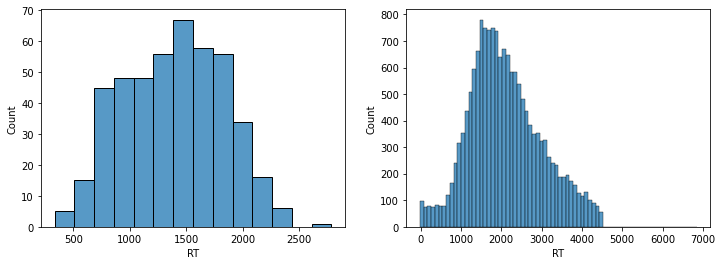

In [3]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_emotion_matching_raw.loc[df_emotion_matching_raw["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
sns.histplot(df_emotion_matching_raw.loc[df_emotion_matching_raw["RT"]<10000,"RT"], ax=axs[1])

plt.plot()

df_emotion_matching_raw[df_emotion_matching_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [4]:
print('\n', df_emotion_matching_raw.mean())
df_emotion_matching_raw[df_emotion_matching_raw["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()



 correct       0.660720
RT         2108.958497
dtype: float64


,correct,RT
userID,,
s_146,0.384615,1106.732769
s_19,0.344262,831.949846
s_76,0.415385,1384.355308
s_93,0.369231,2077.684769


s_146
s_19
s_93
s_76


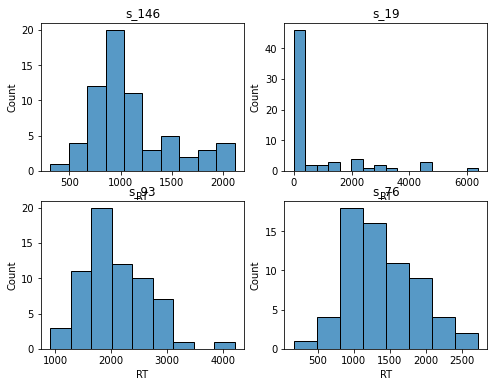

In [5]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
for pt, ax in zip(set(suspects)-set(flagged_ptc), axs.flatten()):
    sns.histplot(data=df_emotion_matching_raw[df_emotion_matching_raw['userID']==pt], x='RT', ax=ax)
    ax.set_title(pt)
    print(pt)



In [6]:
print(f"""Removing {len(df_emotion_matching_raw.loc[df_emotion_matching_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_emotion_matching_raw.loc[df_emotion_matching_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_emotion_matching_raw = df_emotion_matching_raw.loc[df_emotion_matching_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


#
exclude_ptc = ['s_19']

df_emotion_matching_raw = df_emotion_matching_raw[~df_emotion_matching_raw['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_emotion_matching_raw.userID.unique().size} participants.")
################
# save
df_emotion_matching_raw.to_csv(os.path.join(csv_clean_data_path, "emotion_matching-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'emotion_matching',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "emotion_matching-flagged_ptc.csv"), index=False)
    

Removing 2 subjects with not all data/consents
      ['s_258' 's_269']

Saving 249 participants.


In [7]:
df_emotion_matching_raw.userID.value_counts()[df_emotion_matching_raw.userID.value_counts()>(33+32)]#.keys()

Series([], Name: userID, dtype: int64)

In [8]:
df_emotion_matching_raw.userID.value_counts()[df_emotion_matching_raw.userID.value_counts()<(33+32)]#.keys()

Series([], Name: userID, dtype: int64)

#### Set 2 (Feb 2022)

Note that there are now 100 trials, not 65 as previously

In [9]:
## LOAD both pilot and data

df_emotion_matching_raw_rep = pd.read_csv(os.path.join(csv_raw_data_path, 'emotion_matching_standalone_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "ended_on",
                         "timestamp", "x",
                         "face1", "face2", "face3",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"})

# check if someone accessed twice
check_double_access(df_emotion_matching_raw_rep)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_emotion_matching_raw_rep)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_emotion_matching_raw_rep.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

################
# Clean the data to be able to get people who have all trials

df_emotion_matching_raw_rep = df_emotion_matching_raw_rep[~df_emotion_matching_raw_rep["sender_id"].isna()]

# all the real trials are denoted with 5_ or 7_ (two blocks), NOTE - repetition (standalone, full form) has blocks 5_0 and 5_1, not 7_
df_emotion_matching_raw_rep = df_emotion_matching_raw_rep[(df_emotion_matching_raw_rep["sender_id"].str.startswith("5_")) |
                                                  (df_emotion_matching_raw_rep["sender_id"].str.startswith("7_"))]
df_emotion_matching_raw_rep = df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep["sender"].str.contains("ace response")]

# this order is necessary because otherwise the missed trial cleaning fails
# drop the observations that don't have a full dataset - here we still have 2 lines per trial per subject, so twice as many trials needed
not_full_participants = df_emotion_matching_raw_rep["observation"].value_counts()[df_emotion_matching_raw_rep["observation"].value_counts()<2*100].keys()
df_emotion_matching_raw_rep = df_emotion_matching_raw_rep[~df_emotion_matching_raw_rep["observation"].isin(not_full_participants)]

# find where there are missed trials -- compare odd and even rows and where they equal, that's a miss
# since the answer is either in the first or in the second and if there is no answer, they will be the same
# those two lines do the same, just the second is more precise but longer and less readable
# missed_series = df_emotion_matching_raw_rep["ended_on"][::2].reset_index(drop=True) == df_emotion_matching_raw_rep["ended_on"][1::2].reset_index(drop=True)
missed_series2 = df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep["sender"]=="No face response","ended_on"].reset_index(drop=True) == df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep["sender"]=="Face response","ended_on"].reset_index(drop=True)
df_emotion_matching_raw_rep[::2].loc[missed_series2.values,"correct"] = "missed"

# drop all the nans which will merge the answers from late trials and fresh trials
df_emotion_matching_raw_rep = df_emotion_matching_raw_rep[~df_emotion_matching_raw_rep["correct"].isna()]
# and convert the missed trials to nans
df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep["correct"]=="missed", "correct"] = np.nan


#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_emotion_matching_raw_rep["userID"].value_counts()[df_emotion_matching_raw_rep["userID"].value_counts() != 100].keys()

if not double_visits.empty:
    relevant_observation = df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_emotion_matching_raw_rep = df_emotion_matching_raw_rep[~df_emotion_matching_raw_rep["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again if someone accessed twice
check_double_access(df_emotion_matching_raw_rep)


# do flag analysis
flagged_ptc, suspects = flag_participants(df_emotion_matching_raw_rep)
# select only relevant
df_emotion_matching_raw_rep = df_emotion_matching_raw_rep[["observation", "userID", "face1", "face2", "face3", "correct", "RT"]]

# sort the df to easily find changes in csv file when updated
df_emotion_matching_raw_rep.sort_values(by=["userID"], inplace=True)


There are 193 participants (observations) and 166 unique IDs! Check!

All is ok.
There are now 163 participants (observations) and 163 unique IDs.



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 193 participants (observations) and 166 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/Users/jan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


userID
s_117    323.940074
s_178    341.539271
s_92     309.375133
Name: RT, dtype: float64

--> Flagging 3 subjects for too narrow RT (bots/scripts).

In the task, there are 5 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 6 and mean of max per subject is 4.60 +/- 1.82.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 3 participants:
('s_117', 's_178', 's_92')


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)


,correct,RT
userID,,
s_117,0.64,970.36735
s_178,0.71,1541.80839
s_92,0.61,1113.38271


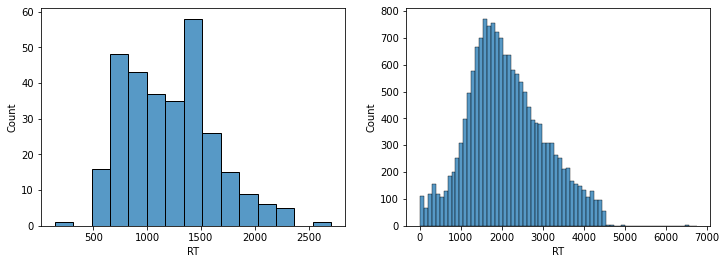

In [10]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
sns.histplot(df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep["RT"]<10000,"RT"], ax=axs[1])

plt.plot()

df_emotion_matching_raw_rep[df_emotion_matching_raw_rep["userID"].isin(flagged_ptc)].groupby(['userID']).mean()

In [11]:
print('\n', df_emotion_matching_raw_rep.mean())
df_emotion_matching_raw_rep[df_emotion_matching_raw_rep["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()



 correct       0.707266
RT         2119.340035
dtype: float64


,correct,RT
userID,,
s_127,0.470000,655.29624
s_130,0.290000,2345.74319
s_134,0.460000,2448.70850
s_171,0.438776,1268.83517
s_232,0.460000,1726.94310


s_232
s_130
s_171
s_127


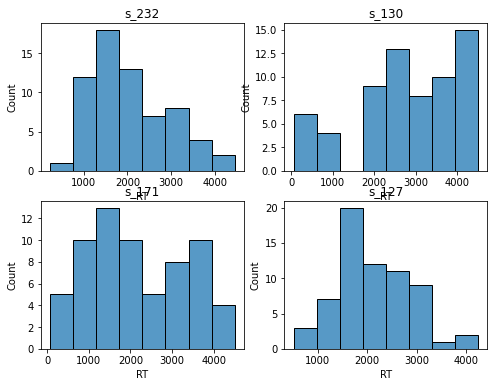

In [12]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
for pt, ax in zip(set(suspects)-set(flagged_ptc), axs.flatten()):
    sns.histplot(data=df_emotion_matching_raw[df_emotion_matching_raw['userID']==pt], x='RT', ax=ax)
    ax.set_title(pt)
    print(pt)



In [13]:
print(f"""Removing {len(df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_emotion_matching_raw_rep = df_emotion_matching_raw_rep.loc[df_emotion_matching_raw_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_emotion_matching_raw_rep = df_emotion_matching_raw_rep[~df_emotion_matching_raw_rep['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_emotion_matching_raw_rep.userID.unique().size} participants.")
################
# save
df_emotion_matching_raw_rep.to_csv(os.path.join(csv_clean_data_path, "emotion_matching_rep-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'emotion_matching_rep',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "emotion_matching_rep-flagged_ptc.csv"), index=False)


Removing 0 subjects with not all data/consents
      []

Saving 163 participants.


In [14]:
df_emotion_matching_raw_rep.userID.value_counts()[df_emotion_matching_raw_rep.userID.value_counts()>(100)]#.keys()

Series([], Name: userID, dtype: int64)

## Emotion labelling
[top](#top)

### Prepare and process Emotion labelling
[top](#top)

#### Set 1

In [2]:
## LOAD both pilot and data

# concat both full data and pilot data
df_emotion_labelling_raw = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'emotion_labeling_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "ended_on",
                         "timestamp", "x",
                         "target",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"}),
    # add also pilot data
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'emotion_labeling_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "ended_on",
                         "timestamp", "x",
                         "target",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"})
])

# check if someone accessed twice
check_double_access(df_emotion_labelling_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_emotion_labelling_raw)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_emotion_labelling_raw.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

################
# Clean the data to be able to get people who have all trials

df_emotion_labelling_raw = df_emotion_labelling_raw[~df_emotion_labelling_raw["sender_id"].isna()]

# all the real trials are denoted with 5_
df_emotion_labelling_raw = df_emotion_labelling_raw[(df_emotion_labelling_raw["sender_id"].str.startswith("5_"))]
df_emotion_labelling_raw = df_emotion_labelling_raw.loc[df_emotion_labelling_raw["sender"].str.contains("Face")]

# this order is necessary because otherwise the missed trial cleaning fails
# drop the observations that don't have a full dataset - here we still have 2 lines per trial per subject, so twice as many trials needed
not_full_participants = df_emotion_labelling_raw["observation"].value_counts()[df_emotion_labelling_raw["observation"].value_counts()<2*48].keys()
df_emotion_labelling_raw = df_emotion_labelling_raw[~df_emotion_labelling_raw["observation"].isin(not_full_participants)]

# find where there are missed trials -- compare odd and even rows and where they equal, that's a miss
# since the answer is either in the first or in the second and if there is no answer, they will be the same
# those two lines do the same, just the second is more precise but longer and less readable
# missed_series = df_emotion_labelling_raw["ended_on"][::2].reset_index(drop=True) == df_emotion_labelling_raw["ended_on"][1::2].reset_index(drop=True)
missed_series2 = df_emotion_labelling_raw.loc[df_emotion_labelling_raw["sender"]=="Face Judgement","ended_on"].reset_index(drop=True) == df_emotion_labelling_raw.loc[df_emotion_labelling_raw["sender"]=="Face Response","ended_on"].reset_index(drop=True)
df_emotion_labelling_raw[::2].loc[missed_series2.values,"correct"] = "missed"

# drop all the nans which will merge the answers from late trials and fresh trials
df_emotion_labelling_raw = df_emotion_labelling_raw[~df_emotion_labelling_raw["correct"].isna()]
# and convert the missed trials to nans
df_emotion_labelling_raw.loc[df_emotion_labelling_raw["correct"]=="missed", "correct"] = np.nan


#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_emotion_labelling_raw["userID"].value_counts()[df_emotion_labelling_raw["userID"].value_counts() != 48].keys()

if not double_visits.empty:
    relevant_observation = df_emotion_labelling_raw.loc[df_emotion_labelling_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_emotion_labelling_raw = df_emotion_labelling_raw[~df_emotion_labelling_raw["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again if someone accessed twice
check_double_access(df_emotion_labelling_raw)


# do flag analysis
flagged_ptc, suspects = flag_participants(df_emotion_labelling_raw)
# select only relevant
df_emotion_labelling_raw = df_emotion_labelling_raw[["observation", "userID", "target", "correct", "RT"]]

# sort the df to easily find changes in csv file when updated
df_emotion_labelling_raw.sort_values(by=["userID"], inplace=True)


There are 256 participants (observations) and 246 unique IDs! Check!

All is ok.
There are now 244 participants (observations) and 244 unique IDs.

Series([], Name: RT, dtype: float64)
In the task, there are 7 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 2 and mean of max per subject is 4.43 +/- 2.51.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 256 participants (observations) and 246 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/Users/jan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [3]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_emotion_labelling_raw.loc[df_emotion_labelling_raw["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_emotion_labelling_raw.loc[df_emotion_labelling_raw["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()

# df_emotion_labelling_raw[df_emotion_labelling_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [4]:
print('\n', df_emotion_labelling_raw.mean())
df_emotion_labelling_raw[df_emotion_labelling_raw["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()



 correct       0.681951
RT         1130.603816
dtype: float64


,correct,RT
userID,,
s_124,0.354167,1105.213458
s_19,0.319149,980.933333
s_191,0.437500,1106.564312
s_201,0.291667,732.677125
s_228,0.212766,974.004438
s_236,0.268293,1885.575000
s_63,0.319149,1058.561667


s_236
s_124
s_228
s_191
s_201
s_63
s_19


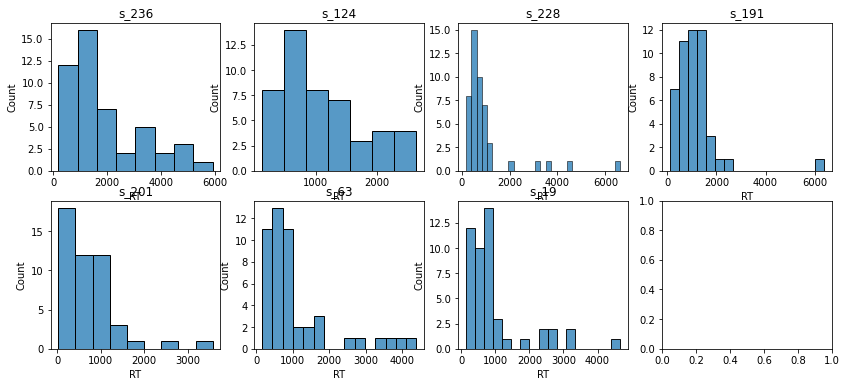

In [5]:
fig, axs = plt.subplots(2,4, figsize=(14,6))
for pt, ax in zip(set(suspects)-set(flagged_ptc), axs.flatten()):
    sns.histplot(data=df_emotion_labelling_raw[df_emotion_labelling_raw['userID']==pt], x='RT', ax=ax)
    ax.set_title(pt)
    print(pt)

In [6]:
a = list(set(suspects)-set(flagged_ptc))
df_emotion_labelling_raw[df_emotion_labelling_raw["userID"]==a[2]]

,observation,userID,target,correct,RT
31521,c67e7,s_228,AF20HAS.JPG,0.0,1087.534
31524,c67e7,s_228,AF13ANS.JPG,0.0,919.667
31528,c67e7,s_228,AF03HAS.JPG,0.0,178.615
31533,c67e7,s_228,AF04ANHL.JPG,0.0,1096.330
31536,c67e7,s_228,AF13HAHR.JPG,0.0,380.975
31540,c67e7,s_228,AM13DIHR.JPG,0.0,546.237
31544,c67e7,s_228,AM17AFHL.JPG,0.0,213.561
31548,c67e7,s_228,AM12SUHL.JPG,0.0,601.800
31552,c67e7,s_228,AM33HAS.JPG,0.0,789.967
31556,c67e7,s_228,AM01SUS.JPG,0.0,403.940


In [7]:
print(f"""Removing {len(df_emotion_labelling_raw.loc[df_emotion_labelling_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_emotion_labelling_raw.loc[df_emotion_labelling_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_emotion_labelling_raw = df_emotion_labelling_raw.loc[df_emotion_labelling_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


# s_201 - too many too short RT (<100 ms)
exclude_ptc = ['s_201']

df_emotion_labelling_raw = df_emotion_labelling_raw[~df_emotion_labelling_raw['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_emotion_labelling_raw.userID.unique().size} participants.")
################
# save
df_emotion_labelling_raw.to_csv(os.path.join(csv_clean_data_path, "emotion_labelling-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'emotion_labelling',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "emotion_labelling-flagged_ptc.csv"), index=False)
    

Removing 1 subjects with not all data/consents
      ['s_292']

Saving 242 participants.


In [8]:
df_emotion_labelling_raw.userID.value_counts()[df_emotion_labelling_raw.userID.value_counts()>(48)]#.keys()

Series([], Name: userID, dtype: int64)

In [9]:
df_emotion_labelling_raw.userID.value_counts()[df_emotion_labelling_raw.userID.value_counts()<(48)]#.keys()

Series([], Name: userID, dtype: int64)

#### Set 2 (Feb 2022)

Note that there are now 100 trials, not 48 as previously

In [10]:
## LOAD data

df_emotion_labelling_raw_rep = pd.read_csv(os.path.join(csv_raw_data_path, 'emotion_labeling_standalone_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "ended_on", "target",
                         "timestamp", "x",
                         "response", "correct_response",
                         "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"})


# check if someone accessed twice
check_double_access(df_emotion_labelling_raw_rep)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_emotion_labelling_raw_rep)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_emotion_labelling_raw_rep.loc[:,["observation", "userID", "timestamp","x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

################
# Clean the data to be able to get people who have all trials

df_emotion_labelling_raw_rep = df_emotion_labelling_raw_rep[~df_emotion_labelling_raw_rep["sender_id"].isna()]

# all the real trials are denoted with 5_
df_emotion_labelling_raw_rep = df_emotion_labelling_raw_rep[(df_emotion_labelling_raw_rep["sender_id"].str.startswith("5_"))]
df_emotion_labelling_raw_rep = df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep["sender"].str.contains("Face")]

# this order is necessary because otherwise the missed trial cleaning fails
# drop the observations that don't have a full dataset - here we still have 2 lines per trial per subject, so twice as many trials needed
not_full_participants = df_emotion_labelling_raw_rep["observation"].value_counts()[df_emotion_labelling_raw_rep["observation"].value_counts()<2*100].keys()
df_emotion_labelling_raw_rep = df_emotion_labelling_raw_rep[~df_emotion_labelling_raw_rep["observation"].isin(not_full_participants)]

# find where there are missed trials -- compare odd and even rows and where they equal, that's a miss
# since the answer is either in the first or in the second and if there is no answer, they will be the same
# those two lines do the same, just the second is more precise but longer and less readable
# missed_series = df_emotion_labelling_raw_rep["ended_on"][::2].reset_index(drop=True) == df_emotion_labelling_raw_rep["ended_on"][1::2].reset_index(drop=True)
missed_series2 = df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep["sender"]=="Face Judgement","ended_on"].reset_index(drop=True) == df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep["sender"]=="Face Response","ended_on"].reset_index(drop=True)
df_emotion_labelling_raw_rep[::2].loc[missed_series2.values,"correct"] = "missed"

# drop all the nans which will merge the answers from late trials and fresh trials
df_emotion_labelling_raw_rep = df_emotion_labelling_raw_rep[~df_emotion_labelling_raw_rep["correct"].isna()]
# and convert the missed trials to nans
df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep["correct"]=="missed", "correct"] = np.nan


#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_emotion_labelling_raw_rep["userID"].value_counts()[df_emotion_labelling_raw_rep["userID"].value_counts() != 100].keys()

if not double_visits.empty:
    relevant_observation = df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_emotion_labelling_raw_rep = df_emotion_labelling_raw_rep[~df_emotion_labelling_raw_rep["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again if someone accessed twice
check_double_access(df_emotion_labelling_raw_rep)


# do flag analysis
flagged_ptc, suspects = flag_participants(df_emotion_labelling_raw_rep)
# select only relevant
df_emotion_labelling_raw_rep = df_emotion_labelling_raw_rep[["observation", "userID", "target", "correct", "RT"]]

# sort the df to easily find changes in csv file when updated
df_emotion_labelling_raw_rep.sort_values(by=["userID"], inplace=True)


There are 194 participants (observations) and 173 unique IDs! Check!

All is ok.
There are now 173 participants (observations) and 173 unique IDs.

Series([], Name: RT, dtype: float64)
In the task, there are 4 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 3 and mean of max per subject is 4.00 +/- 1.63.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 194 participants (observations) and 173 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/Users/jan/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [11]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()

# df_emotion_labelling_raw_rep[df_emotion_labelling_raw_rep["userID"].isin(flagged_ptc)].groupby(['userID']).mean()


In [12]:
print('\n', df_emotion_labelling_raw_rep.mean())
df_emotion_labelling_raw_rep[df_emotion_labelling_raw_rep["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()



 correct      0.786162
RT         975.190859
dtype: float64


,correct,RT
userID,,
s_171,0.526882,725.30241
s_225,0.550000,777.74604
s_55,0.530612,1602.33893
s_76,0.520000,1099.85767


s_225
s_55
s_76
s_171


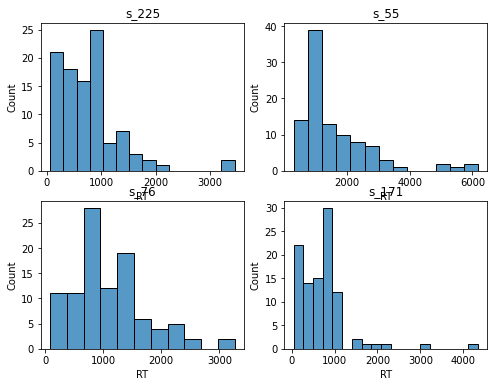

In [13]:
fig, axs = plt.subplots(2,2, figsize=(8,6))
for pt, ax in zip(set(suspects)-set(flagged_ptc), axs.flatten()):
    sns.histplot(data=df_emotion_labelling_raw_rep[df_emotion_labelling_raw_rep['userID']==pt], x='RT', ax=ax)
    ax.set_title(pt)
    print(pt)

In [14]:
# df_emotion_labelling_raw_rep[df_emotion_labelling_raw_rep['userID']=='601cded3e354de6a40b60637'].tail(40)

In [15]:
print(f"""Removing {len(df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_emotion_labelling_raw_rep = df_emotion_labelling_raw_rep.loc[df_emotion_labelling_raw_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

# 
exclude_ptc = []

df_emotion_labelling_raw_rep = df_emotion_labelling_raw_rep[~df_emotion_labelling_raw_rep['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_emotion_labelling_raw_rep.userID.unique().size} participants.")
################
# save
df_emotion_labelling_raw_rep.to_csv(os.path.join(csv_clean_data_path, "emotion_labelling_rep-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'emotion_labelling_rep',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "emotion_labelling_rep-flagged_ptc.csv"), index=False)
    

Removing 1 subjects with not all data/consents
      ['s_258']

Saving 172 participants.


In [16]:
df_emotion_labelling_raw_rep.userID.value_counts()[df_emotion_labelling_raw_rep.userID.value_counts()>(100)]#.keys()

Series([], Name: userID, dtype: int64)

In [17]:
df_emotion_labelling_raw_rep.userID.value_counts()[df_emotion_labelling_raw_rep.userID.value_counts()<(100)]#.keys()

Series([], Name: userID, dtype: int64)

## FMP
[top](#top)

Processing of this task is done in separate notebooks and the raw csv is there sort of twice (once processed).

* [FMP standalone version](#FMP-standalone)

In [2]:
# complex pilot
df_fmp = pd.read_csv(os.path.join(csv_raw_data_path, 'complex_FMP_pilot.csv'))
# convert boolean answers to floats to be able to do mean
df_fmp['correct_flt'] = df_fmp.correct_check.astype(float)
# Add gender
df_fmp["stim_gender"] = (df_fmp["stim1"].str.contains('_m4018')).map({False: 'F', True: 'M'})

try:
    df_fmp.drop("Unnamed: 0", inplace=True, axis=1)
except KeyError:
    print("no renaming, likely you have already updated version")    

In [3]:
flagged = []
suspect = []

f, s = flag_participants(df_fmp.rename(columns={"correctResponse":"correct_response"}), measure='correct_flt', RT_thr=3500)
if len(f):
    flagged.append(f)
    pd.DataFrame({
        'task': 'FMP',
        'flagged_participants': f,
    }).to_csv(os.path.join(csv_clean_data_path, "FMP-flagged_ptc.csv"), index=False)
if len(s):
    suspect.append(s)

    
print('\n\nSubtasks\n-----------\n')    
for tsk in ['perception', 'blank', 'faces']:
    f, s = flag_participants(df_fmp[df_fmp["task"]==tsk].rename(columns={"correctResponse":"correct_response"}), measure='correct_flt', RT_thr=3500)
    if len(f):
        flagged.append(f)
        pd.DataFrame({
            'task': f'FMP_{tsk}',
            'flagged_participants': f,
        }).to_csv(os.path.join(csv_clean_data_path, f"FMP_{tsk}-flagged_ptc.csv"), index=False)
    if len(s):
        suspect.append(s)   
        
# make it flat
flagged_ptc = [i for s in flagged for i in s]
suspect_ptc = [i for s in suspect for i in s]



if flagged_ptc:
    pd.DataFrame({
        'task': 'FMP',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "FMP_all-flagged_ptc.csv"), index=False)

userID
s_178    276.349122
s_189    270.798637
s_229    269.069748
s_42     169.225113
Name: RT, dtype: float64

--> Flagging 4 subjects for too narrow RT (bots/scripts).

In the task, there are 2 suspects.

--> Flagging 1 subjects for RT.

Max naturally occurring answers is 7 and mean of max per subject is 8.00 +/- 0.00.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 5 participants:
('s_178', 's_189', 's_228', 's_229', 's_42')


Subtasks
-----------

userID
s_106    254.484469
s_165    230.256069
s_170    242.330274
s_171    251.355815
s_189    222.706278
s_229    208.123881
s_42     148.624192
Name: RT, dtype: float64

--> Flagging 7 subjects for too narrow RT (bots/scripts).

In the task, there are 11 suspects.

--> Flagging 1 subjects for RT.

Max naturally occurring answers is 7 and mean of max per subject is 7.36 +/- 3.93.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too lon

/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Code/./functions/reliability_functions.py:841: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)
/Users/jan/Documents/PhD/papers/Reliability_law/reliability_github/Code/./functions/reliability_functions.py:841: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)
/Users/jan/Documents/PhD/papers/Reliability_law/reli

In [4]:
# df_fmp.loc[(df_fmp["userID"].isin(flagged_ptc))].groupby(['userID','task'])[['RT', 'correct_flt']].mean()

for i,tsk in enumerate(['perception', 'blank', 'faces']):
    print(tsk)
    print(df_fmp.loc[(df_fmp["userID"].isin(flagged[i+1]))&(df_fmp["task"]==tsk)].groupby(['userID'])[['RT', 'correct_flt']].mean())
    print()

df_fmp.loc[(df_fmp["userID"].isin(flagged[0]))].groupby(['userID'])[['RT', 'correct_flt']].mean()

perception
                 RT  correct_flt
userID                          
s_106   1209.837627     0.983051
s_165    965.889917     0.966667
s_170    975.950333     0.766667
s_171   1016.630650     0.766667
s_189   1033.449533     0.933333
s_228    381.363983     0.465517
s_229    950.140067     0.850000
s_42     885.025100     0.783333

blank
                 RT  correct_flt
userID                          
s_16    1228.166250     0.700000
s_170   1163.031333     0.666667
s_189    971.585067     0.833333
s_228    511.827817     0.483333
s_230   1304.651017     0.783333
s_32    1894.812136     0.525424
s_42     796.909900     0.800000

faces
                 RT  correct_flt
userID                          
s_195   1247.940667     0.600000
s_232    863.380883     0.600000
s_237   1515.229800     0.566667
s_42    1002.928167     0.883333
s_70    1422.235283     0.766667



,RT,correct_flt
userID,,
s_178,1287.652631,0.938547
s_189,1075.032611,0.850000
s_228,403.637781,0.471910
s_229,1010.076911,0.794444
s_42,894.954389,0.822222


In [5]:
df_fmp.loc[(df_fmp["userID"]=='s_228')].mean()

block              6.000000
RT               403.637781
observation             inf
All Raters        81.516667
order              6.000000
correct_check      0.471910
difficulty         2.000000
levels            30.000000
correct_flt        0.471910
dtype: float64

In [6]:
print(df_fmp.correct_flt.mean())
print(df_fmp.correct_flt.std())
print(df_fmp.correct_flt.mean()-df_fmp.correct_flt.std())

0.7588981109017771
0.42775743905629854
0.3311406718454785


In [7]:
# exclude some participants
exclude_ptc = ['s_228']
df_fmp = df_fmp[~df_fmp['userID'].isin(exclude_ptc)]

# take only what we really need (df_fmp_cut)
df_fmp = df_fmp[["userID", "task", "difficulty", "correct_flt"]].copy()


print(f"""Removing {len(df_fmp.loc[df_fmp['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_fmp.loc[df_fmp['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_fmp = df_fmp.loc[df_fmp['userID'].str.split('_').str[-1].astype(int)<=highest_ID]
    

# sort the df to easily find changes in csv file when updated
df_fmp.sort_values(by=["userID"], inplace=True)

print(f"\nSaving {df_fmp.userID.unique().size} participants.")

# save
df_fmp.to_csv(os.path.join(csv_clean_data_path, "FMP-cleaned_data.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 223 participants.


## FMP standalone
[top](#top)

[FMP](#FMP)

In [8]:
# define manually num of trials
n_trials_per_form = 180

# # define tracker of num of trials per task
# n_trials_dict = {}
# # define tracker for num_subjects
# n_subj_dict = {}


df_fmp_cut_stand = pd.read_csv(os.path.join(csv_clean_data_path, 'complex_FMP_pilot_standalone.csv'))
flagged = []
suspect = []

f, s = flag_participants(df_fmp_cut_stand.rename(columns={"correctResponse":"correct_response"}), measure='correct_flt', RT_thr=3500)
if len(f):
    flagged.append(f)
    pd.DataFrame({
        'task': 'FMP',
        'flagged_participants': f,
    }).to_csv(os.path.join(csv_clean_data_path, "FMP_stand-flagged_ptc.csv"), index=False)
if len(s):
    suspect.append(s)

    
print('\n\nSubtasks\n-----------\n')    
for tsk in ['perception', 'blank', 'faces']:
    f, s = flag_participants(df_fmp_cut_stand[df_fmp_cut_stand["task"]==tsk].rename(columns={"correctResponse":"correct_response"}), measure='correct_flt', RT_thr=3500)
    if len(f):
        flagged.append(f)
        pd.DataFrame({
            'task': f'FMP_{tsk}',
            'flagged_participants': f,
        }).to_csv(os.path.join(csv_clean_data_path, f"FMP_stand_{tsk}-flagged_ptc.csv"), index=False)
    if len(s):
        suspect.append(s)   
        
# make it flat
flagged_ptc = [i for s in flagged for i in s]
suspect_ptc = [i for s in suspect for i in s]


if flagged_ptc:
    pd.DataFrame({
        'task': 'FMP_stand',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "FMP_stand_all-flagged_ptc.csv"), index=False)  

df_fmp_cut_stand = None
# take only what we really need
df_fmp_cut_stand = pd.read_csv(os.path.join(csv_clean_data_path, 'complex_FMP_pilot_standalone.csv'), 
                         usecols=["userID", "task", "difficulty", "correct_flt", "RT"])


# sort the df to easily find changes in csv file when updated
df_fmp_cut_stand.sort_values(by=["userID"], inplace=True)

df_fmp_cut_stand


userID
s_208    233.128114
s_230    241.624459
s_79     274.098344
Name: RT, dtype: float64

--> Flagging 3 subjects for too narrow RT (bots/scripts).

In the task, there are 0 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 8 and mean of max per subject is nan +/- nan.
Series([], Name: response, dtype: float64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 3 participants:
('s_208', 's_230', 's_79')


Subtasks
-----------

userID
s_182    192.926745
s_208    244.276259
s_227    209.246594
s_230    245.426282
s_73     231.895278
Name: RT, dtype: float64

--> Flagging 5 subjects for too narrow RT (bots/scripts).

In the task, there are 3 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 3 and mean of max per subject is 9.67 +/- 5.03.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 5 participants:
('s_182', 's_208', 's_227'

/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)
/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)
/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliabi

,RT,userID,task,difficulty,correct_flt
2070,1537.487,s_101,blank,1,1.0
2044,1630.496,s_101,blank,2,1.0
2043,2038.449,s_101,blank,2,1.0
2042,2117.954,s_101,blank,1,1.0
2041,1721.872,s_101,blank,1,1.0
...,...,...,...,...,...
4257,1747.023,s_99,blank,3,1.0
4256,2396.293,s_99,blank,2,1.0
4255,2789.011,s_99,blank,3,0.0
4253,2423.021,s_99,blank,1,0.0


In [9]:
suspect_ptc

['s_112', 's_143', 's_200', 's_11', 's_120', 's_23', 's_124']

In [10]:
df_fmp_cut_stand.loc[(df_fmp_cut_stand["userID"].isin(suspect_ptc))].groupby(['userID','task']).correct_flt.mean()

userID  task      
s_11    blank         0.491525
        faces         0.509434
        perception    0.785714
s_112   blank         0.672727
        faces         0.589286
        perception    0.535714
s_120   blank         0.425926
        faces         0.517857
        perception    0.730769
s_124   blank         0.614035
        faces         0.382353
        perception    0.759259
s_143   blank         0.711864
        faces         0.766667
        perception    0.661017
s_200   blank         0.516667
        faces         0.482759
        perception    0.649123
s_23    blank         0.457627
        faces         0.533333
        perception    0.745763
Name: correct_flt, dtype: float64

> Is this some prosopagnosia? What is going on?

```python
df_fmp_cut_stand[df_fmp_cut_stand['userID']=='s_143'].groupby(['task', 'difficulty']).mean()
```

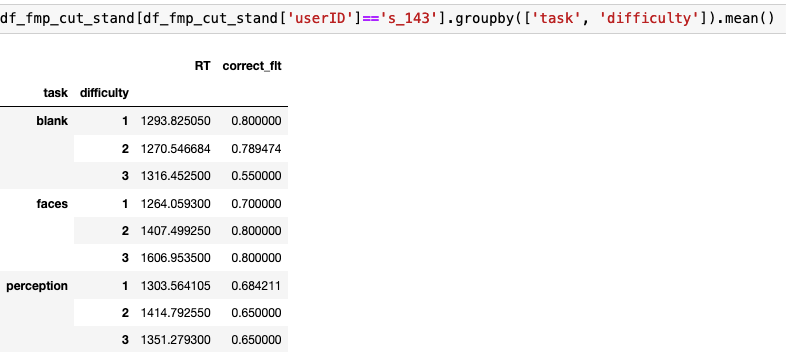

In [11]:
df_fmp_cut_stand[df_fmp_cut_stand['userID']=='s_143'].groupby(['task', 'difficulty']).mean()

RT  correct_flt
task       difficulty                          
blank      1           1293.825050     0.800000
           2           1270.546684     0.789474
           3           1316.452500     0.550000
faces      1           1264.059300     0.700000
           2           1407.499250     0.800000
           3           1606.953500     0.800000
perception 1           1303.564105     0.684211
           2           1414.792550     0.650000
           3           1351.279300     0.650000

In [12]:
# df_fmp_cut_stand.loc[(df_fmp_cut_stand["userID"].isin(flagged_ptc))].groupby(['userID','task'])[['RT', 'correct_flt']].mean()

# CAUTION!! this iteration depends on the # of suspects in the original/subtasks, check always

for i,tsk in enumerate(['perception', 'blank', 'faces']):
    print(tsk)
    print(df_fmp_cut_stand.loc[(df_fmp_cut_stand["userID"].isin(flagged[i]))&(df_fmp_cut_stand["task"]==tsk)].groupby(['userID'])[['RT', 'correct_flt']].mean())
    print()

df_fmp_cut_stand.loc[(df_fmp_cut_stand["userID"].isin(flagged[0]))].groupby(['userID'])[['RT', 'correct_flt']].mean()

perception
                 RT  correct_flt
userID                          
s_208   1128.536271     0.932203
s_230   1446.558051     0.915254
s_79    1447.053367     0.800000

blank
                 RT  correct_flt
userID                          
s_182   1264.519186     0.694915
s_208   1209.420000     0.666667
s_227    994.048617     0.550000
s_230   1436.383633     0.833333
s_73    1175.077400     0.633333

faces
                 RT  correct_flt
userID                          
s_167   1094.841450     0.616667
s_178   1663.310900     0.816667
s_96    1367.169133     0.583333



,RT,correct_flt
userID,,
s_208,1172.474637,0.754190
s_230,1464.022453,0.787709
s_79,1465.747367,0.761111


In [13]:
# exclude some participants
exclude_ptc = ['s_112']
df_fmp_cut_stand = df_fmp_cut_stand[~df_fmp_cut_stand['userID'].isin(exclude_ptc)].sort_values(by=['userID'])


print(f"""Removing {len(df_fmp_cut_stand.loc[df_fmp_cut_stand['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_fmp_cut_stand.loc[df_fmp_cut_stand['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_fmp_cut_stand = df_fmp_cut_stand.loc[df_fmp_cut_stand['userID'].str.split('_').str[-1].astype(int)<=highest_ID]
    

# sort the df to easily find changes in csv file when updated
df_fmp_cut_stand.sort_values(by=["userID"], inplace=True)

print(f"\nSaving {df_fmp_cut_stand.userID.unique().size} participants.")

# save
df_fmp_cut_stand.to_csv(os.path.join(csv_clean_data_path, "FMP-cleaned_data_rep.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 128 participants.


---

## GFMT
[top](#top)

### Prepare and process GFMT
[top](#top)

#### Set 1

In [2]:
# try loading block if the version has been updated, if not, load without
try:
    df_GFMT_raw = pd.read_csv(os.path.join(csv_raw_data_path, "GFMT_data.csv"),
                              usecols=["observation", "userID", "timestamp", "correct", "block", "x", "FaceStim",
                                       "response", "correct_response","duration"
                                      ]
                                 ).rename(columns={"duration":"RT"})
except ValueError:
    df_GFMT_raw = pd.read_csv(os.path.join(csv_raw_data_path, "GFMT_data.csv"),
                              usecols=["observation", "userID", "timestamp", "correct", "sender_id", "x", "FaceStim",
                                       "response", "correct_response","duration"
                                      ]
                                 ).rename(columns={"duration":"RT"})

# load also the pilot version
try:
    pilot = pd.read_csv(os.path.join(csv_raw_data_path, "piloting", "GFMT_data.csv"),
                        usecols=["observation", "userID", "timestamp", "correct", "block", "x", "FaceStim",
                                       "response", "correct_response","duration"
                                      ]
                                 ).rename(columns={"duration":"RT"})
except ValueError:
    pilot = pd.read_csv(os.path.join(csv_raw_data_path, "piloting", "GFMT_data.csv"),
                        usecols=["observation", "userID", "timestamp", "correct", "sender_id", "x", "FaceStim",
                                       "response", "correct_response","duration"
                                      ]
                                 ).rename(columns={"duration":"RT"})

# concatenate them
df_GFMT_raw = pd.concat([df_GFMT_raw, pilot])
pilot = None

# df.rename(columns={"user_id":"userID"}, inplace=True)    

# select only completed experiments, 4 practise, 40 real trials
completed_idx = df_GFMT_raw[df_GFMT_raw["correct"].notnull()].observation.value_counts().loc[lambda x: x == (4 + 40)].index

# and then the completed
df_GFMT_raw = df_GFMT_raw[df_GFMT_raw["observation"].isin(completed_idx)]



# check if someone accessed twice
check_double_access(df_GFMT_raw)
    
# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_GFMT_raw)


#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_GFMT_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=['userID', "timestamp"], inplace=True, ascending=True)

# drop duplicates based on the user, get the observation values
first_user_entry = df_first_visit.drop_duplicates(subset=["userID"]).observation.values

# update the df
df_GFMT_raw = df_GFMT_raw[df_GFMT_raw["observation"].isin(first_user_entry)]

# check again if someone accessed twice
check_double_access(df_GFMT_raw)

################
# Clean the data


# select only real trials
if "block" in df_GFMT_raw.keys():
    df_GFMT_raw = df_GFMT_raw.loc[(df_GFMT_raw["block"] == "experiment") & (df_GFMT_raw.correct.notnull())]
else:
    df_GFMT_raw = df_GFMT_raw.loc[(df_GFMT_raw["sender_id"].str.startswith("5", na=False)) & (df_GFMT_raw.correct.notnull())]

    
# do flag analysis
flagged_ptc, suspects = flag_participants(df_GFMT_raw)
# select only relevant
df_GFMT_raw = df_GFMT_raw[["observation", "userID", "block", "correct", "RT", "FaceStim"]]

# sort the df to easily find changes in csv file when updated
df_GFMT_raw.sort_values(by=["userID"], inplace=True)



All is ok.
There are now 241 participants (observations) and 241 unique IDs.

All is ok.
There are now 241 participants (observations) and 241 unique IDs.

Series([], Name: RT, dtype: float64)
In the task, there are 16 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 5 and mean of max per subject is 5.81 +/- 2.32.
userID
s_208    12
Name: response, dtype: int64

--> Flagging 1 subjects for too long consecutive answers.

In total flagging 1 participants:
('s_208',)


std:
          correct          RT
userID                      
s_208   0.503831  1028.46281 

mean:



,correct,RT
userID,,
s_208,0.55,1831.01735


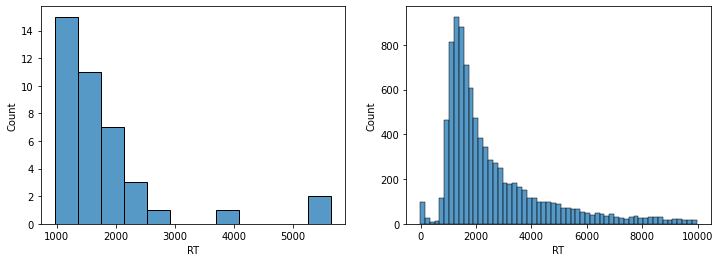

In [3]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_GFMT_raw.loc[df_GFMT_raw["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
sns.histplot(df_GFMT_raw.loc[df_GFMT_raw["RT"]<10000,"RT"], ax=axs[1])

plt.plot()

print('std:\n',df_GFMT_raw[df_GFMT_raw["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
df_GFMT_raw[df_GFMT_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()

In [4]:
print('\n', df_GFMT_raw.mean())
# df_GFMT_raw[df_GFMT_raw["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()
df_GFMT_raw[df_GFMT_raw["userID"].isin(suspects)].groupby(['userID']).mean()


 correct       0.770954
RT         3215.238948
dtype: float64


,correct,RT
userID,,
s_113,0.525,1452.207325
s_140,0.475,3606.154975
s_150,0.550,3359.120125
s_167,0.500,1527.568350
s_170,0.550,1297.825500
s_175,0.550,2033.812825
s_19,0.525,84.145500
s_200,0.550,2006.952500
s_208,0.550,1831.017350


In [5]:
df_GFMT_raw[df_GFMT_raw['userID']==suspects[6]]

# s_19 has negative RT - CHECK!

,observation,userID,block,correct,RT,FaceStim
20143,7ee80,s_19,experiment,0.0,53.90,075_DV_C2.jpg
20080,7ee80,s_19,experiment,0.0,48.28,081_C2_DV.jpg
20077,7ee80,s_19,experiment,0.0,236.34,049_218_L.jpg
20074,7ee80,s_19,experiment,1.0,-11.34,102_224_R.jpg
20071,7ee80,s_19,experiment,1.0,38.12,170_DV_C2.jpg
20068,7ee80,s_19,experiment,0.0,24.52,020_C2_DV.jpg
20065,7ee80,s_19,experiment,0.0,-5.12,091_283_R.jpg
20062,7ee80,s_19,experiment,0.0,13.34,115_C2_DV.jpg
20059,7ee80,s_19,experiment,0.0,98.66,261_254_L.jpg
20056,7ee80,s_19,experiment,0.0,56.44,282_108_R.jpg


In [6]:
print(f"""Removing {len(df_GFMT_raw.loc[df_GFMT_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_GFMT_raw.loc[df_GFMT_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_GFMT_raw = df_GFMT_raw.loc[df_GFMT_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


# S_228, s_19, very quick RT, low acc (chance)
# S_208 flagged, low acc (chance)
exclude_ptc = ['s_228', 's_19', 's_208']

df_GFMT_raw = df_GFMT_raw[~df_GFMT_raw['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_GFMT_raw.userID.unique().size} participants.")

################
# save
df_GFMT_raw.to_csv(os.path.join(csv_clean_data_path, "GFMT-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'GFMT',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "GFMT-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 238 participants.


In [7]:
df_GFMT_raw.userID.value_counts()[df_GFMT_raw.userID.value_counts()>40]#.keys()

Series([], Name: userID, dtype: int64)

#### Set 2 (Feb 2022)

In [8]:
# load new data
df_GFMT_raw_rep = pd.read_csv(os.path.join(csv_raw_data_path, "GFMT_long_standalone_data.csv"),
                              usecols=["observation", "user_id", "timestamp", "correct", "block", "x", "face_stim",
                                       "response", "correct_response","duration"
                                      ]
                                 ).rename(columns={"duration":"RT", "user_id":"userID", "face_stim":"FaceStim"})

# select only completed experiments, 4 practise, 168 real trials
completed_idx = df_GFMT_raw_rep[df_GFMT_raw_rep["correct"].notnull()].observation.value_counts().loc[lambda x: x == (4 + 168)].index

# and then the completed
df_GFMT_raw_rep = df_GFMT_raw_rep[df_GFMT_raw_rep["observation"].isin(completed_idx)]


# check if someone accessed twice
check_double_access(df_GFMT_raw_rep)
    
# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_GFMT_raw_rep)


#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_GFMT_raw_rep.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=['userID', "timestamp"], inplace=True, ascending=True)

# drop duplicates based on the user, get the observation values
first_user_entry = df_first_visit.drop_duplicates(subset=["userID"]).observation.values

# update the df
df_GFMT_raw_rep = df_GFMT_raw_rep[df_GFMT_raw_rep["observation"].isin(first_user_entry)]

# check again if someone accessed twice
check_double_access(df_GFMT_raw_rep)

################
# Clean the data


# select only real trials
if "block" in df_GFMT_raw_rep.keys():
    df_GFMT_raw_rep = df_GFMT_raw_rep.loc[(df_GFMT_raw_rep["block"] == "experiment") & (df_GFMT_raw_rep.correct.notnull())]
    print("using block")
else:
    df_GFMT_raw_rep = df_GFMT_raw_rep.loc[(df_GFMT_raw_rep["sender_id"].str.startswith("5", na=False)) & (df_GFMT_raw_rep.correct.notnull())]

    
    
# do flag analysis
flagged_ptc, suspects = flag_participants(df_GFMT_raw_rep)
# select only relevant
df_GFMT_raw_rep = df_GFMT_raw_rep[["observation", "userID", "block", "correct", "RT", "FaceStim"]]

# sort the df to easily find changes in csv file when updated
df_GFMT_raw_rep.sort_values(by=["userID"], inplace=True)



There are 168 participants (observations) and 163 unique IDs! Check!

All is ok.
There are now 163 participants (observations) and 163 unique IDs.

using block
Series([], Name: RT, dtype: float64)
In the task, there are 7 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 6 and mean of max per subject is 15.29 +/- 9.03.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 168 participants (observations) and 163 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


In [9]:
print('\n', df_GFMT_raw.mean())
# df_GFMT_raw[df_GFMT_raw["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()
df_GFMT_raw[df_GFMT_raw["userID"].isin(suspects)].groupby(['userID']).mean()


 correct       0.774055
RT         3247.129228
dtype: float64


,correct,RT
userID,,
s_118,0.625,3297.915950
s_124,0.650,815.739600
s_127,0.875,1405.107100
s_171,0.725,2013.734725
s_35,0.700,1511.658775
s_86,0.725,3289.786250


In [10]:
print(f"""Removing {len(df_GFMT_raw_rep.loc[df_GFMT_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_GFMT_raw_rep.loc[df_GFMT_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_GFMT_raw_rep = df_GFMT_raw_rep.loc[df_GFMT_raw_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_GFMT_raw_rep = df_GFMT_raw_rep[~df_GFMT_raw_rep['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_GFMT_raw_rep.userID.unique().size} participants.")    
################
# save
df_GFMT_raw_rep.to_csv(os.path.join(csv_clean_data_path, "GFMT-cleaned_data_rep.csv"), index=False)

if flagged_ptc:
    pd.DataFrame({
        'task': 'GFMT_rep',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "GFMT-flagged_ptc_rep.csv"), index=False)

df_GFMT_raw_rep.userID.value_counts()[df_GFMT_raw_rep.userID.value_counts()!=168]#.keys()

Removing 0 subjects with not all data/consents
      []

Saving 163 participants.


Series([], Name: userID, dtype: int64)

## MST
[top](#top)

### Prepare and process MST
[top](#top)

There are again two files which are not the same. The first run was not successful and many people just let it run. Those people were then invited again, so only their second data should be counted. I am accounting for it by first loading the second data and then only loading all the first which are not yet loaded.

---
LDI (lure discrimination index) = prob of giving a similar response to a lure - prob of similar response to foils 

REC (corrected recognition) = hits (old to target) - FA (old to foil)

#### Set 1 (original)

In [2]:
# concat both full data and pilot data, first set
df_mst_set1 = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'MST_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "trial_type",
                         "repetition", "stimulus_number", "response",
                         "timestamp", "x",
                         "response", "correct_response","duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"}),
    # add also pilot data
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'MST_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "trial_type",
                         "repetition", "stimulus_number", "response",
                         "timestamp", "x",
                         "response", "correct_response","duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"})
])

# load the second set
df_mst_set2 = pd.read_csv(os.path.join(csv_raw_data_path, 'MST_set2_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "trial_type",
                         "repetition", "stimulus_number", "response",
                         "timestamp", "x",
                         "response", "correct_response","duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"})

# fill in userID everywhere based on observation, see FMP processing for more
temp = df_mst_set1.loc[df_mst_set1.observation.isin(df_mst_set1.observation.unique()), ["observation",
                                                                                        "userID"]].drop_duplicates().dropna()
fill_userID = temp.set_index("observation").T.to_dict('records')[0]
df_mst_set1.userID = df_mst_set1["userID"].fillna(df_mst_set1["observation"].map(fill_userID))
temp = None

# fill in userID everywhere based on observation, see FMP processing for more
temp = df_mst_set2.loc[df_mst_set2.observation.isin(df_mst_set2.observation.unique()), ["observation",
                                                                                        "userID"]].drop_duplicates().dropna()
fill_userID = temp.set_index("observation").T.to_dict('records')[0]
df_mst_set2.userID = df_mst_set2["userID"].fillna(df_mst_set2["observation"].map(fill_userID))
temp = None

# merge them so that we only keep the set 2 if the people are in both
df_mst_raw = pd.concat([df_mst_set2, df_mst_set1[~df_mst_set1["userID"].isin(df_mst_set2["userID"].unique())]])

# check if someone accessed twice
check_double_access(df_mst_raw)


#################
# Deal with people accessing multiple times - take only the first visit
# 320 trials

# add max num trials based on the sender_id
df_max_trials = df_mst_raw[["observation", "sender_id"]].copy()
df_max_trials["middle_id"] = (df_max_trials["sender_id"].str.split("_").str[1]).astype(float)
# don't forget that numbering starts at 0 and add 1
num_trials_observation = (df_max_trials.groupby("observation").middle_id.max()+1).to_dict()

# x is there just to select only the lines with the first timestamp
df_first_visit = df_mst_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# map the numbers
df_first_visit["num_trials"] = df_first_visit["observation"].map(num_trials_observation)

# sort by user and date, sort from earliest, take only the max at the moment, TODO maybe filter out who doesn't have 320
df_first_visit.sort_values(by=["userID", "num_trials", "timestamp"], inplace=True, ascending=[True, False, True])

# drop duplicates based on the user, get the observation values
first_user_entry = df_first_visit.drop_duplicates(subset=['userID']).observation.values

# update the df
df_mst_raw = df_mst_raw[df_mst_raw["observation"].isin(first_user_entry)]
# save them
# pd.DataFrame({"observation":first_user_entry}).to_csv(os.path.join(csv_clean_data_path,"MST_observations_first_entry.csv"), index=False)

# check again if someone accessed twice
check_double_access(df_mst_raw)


################
# Clean the data

df_mst_raw = df_mst_raw[~df_mst_raw["sender_id"].isna()]

# df_mst_raw = df_mst_raw[df_mst_raw["sender_id"].str.startswith("3_")]
# take only the stimulus
df_mst_raw = df_mst_raw.loc[df_mst_raw["sender"]=="Stimulus"]

# convert to boolean
df_mst_raw["correct"] =df_mst_raw["correct"].astype(bool)

# remove the one guy who we didn't want
df_mst_raw = df_mst_raw[df_mst_raw["userID"]!='5fa879d9f68b9371d90c3aa3']


# drop people who do not have full dataset
df_mst_raw = df_mst_raw[df_mst_raw['userID'].isin(
    df_mst_raw.userID.value_counts()[df_mst_raw.userID.value_counts()==320].keys())]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_mst_raw, RT_thr=5000)
# select only relevant
df_mst_raw = df_mst_raw[['observation', 'userID', 'RT', 'stimulus_number', 'trial_type', 'repetition', 'correct', 'response']]

# sort the df to easily find changes in csv file when updated
df_mst_raw.sort_values(by=["userID"], inplace=True)



There are 387 participants (observations) and 243 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 387 participants (observations) and 243 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 243 participants (observations) and 243 unique IDs.

userID
s_112    3.230757
s_174    3.506950
Name: RT, dtype: float64

--> Flagging 2 subjects for too narrow RT (bots/scripts).

In the task, there are 10 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 9 and mean of max per subject is 14.60 +/- 13.13.
userID
s_100    49
Name: response, dtype: int64

--> Flagging 1 subjects for too long consecutive answers.

In total flagging 3 participants:
('s_100', 's_112', 's_174')


In [3]:
print(df_mst_raw[["RT", "correct"]].mean())
df_mst_raw.loc[df_mst_raw["userID"].isin(suspects)].groupby(['userID']).mean()[["RT", "correct"]]

RT         1350.306455
correct       0.783112
dtype: float64


,RT,correct
userID,,
s_100,2044.378228,0.381250
s_125,1578.558119,0.553125
s_171,1329.831206,0.506250
s_19,2274.215875,0.490625
s_190,598.042500,0.553125
s_214,138.307447,0.418750
s_228,342.042078,0.356250
s_27,1255.159178,0.518750
s_35,1240.844044,0.537500


In [4]:
print(f"""Removing {len(df_mst_raw.loc[df_mst_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_mst_raw.loc[df_mst_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_mst_raw = df_mst_raw.loc[df_mst_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


# remove flagged participants 
exclude_ptc = ['s_100', 's_112', 's_174', 's_228']


df_mst_raw = df_mst_raw[~df_mst_raw['userID'].isin(exclude_ptc)]

# save
df_mst_raw.to_csv(os.path.join(csv_clean_data_path,'MST-cleaned_data.csv'), index=False)

print(f'\nSaving {df_mst_raw.userID.unique().size} participants.')

if flagged_ptc:
    pd.DataFrame({
        'task': 'MST',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "MST-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 231 participants.


In [5]:
df_mst_raw.userID.value_counts()[df_mst_raw.userID.value_counts()<320]#.keys()

Series([], Name: userID, dtype: int64)

#### Set 2 (Feb 2022) 

But it's labelled as 3 in Catherine's data since we used the form 2 already before for some of subjects to account for low quality of their data.

In [6]:
# concat both full data and pilot data, first set
df_mst_set_rep = pd.read_csv(os.path.join(csv_raw_data_path, 'MST_v3_standalone_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "trial_type",
                         "repetition", "stimulus_number", "response",
                         "timestamp", "x",
                         "response", "correct_response","duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration":"RT"})
    

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_mst_set_rep)

# check if someone accessed twice
check_double_access(df_mst_set_rep)


#################
# Deal with people accessing multiple times - take only the first visit
# 320 trials

# add max num trials based on the sender_id
df_max_trials = df_mst_set_rep[["observation", "sender_id"]].copy()
df_max_trials["middle_id"] = (df_max_trials["sender_id"].str.split("_").str[1]).astype(float)
# don't forget that numbering starts at 0 and add 1
num_trials_observation = (df_max_trials.groupby("observation").middle_id.max()+1).to_dict()

# x is there just to select only the lines with the first timestamp
df_first_visit = df_mst_set_rep.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# map the numbers
df_first_visit["num_trials"] = df_first_visit["observation"].map(num_trials_observation)

# sort by user and date, sort from earliest, take only the max at the moment, TODO maybe filter out who doesn't have 320
df_first_visit.sort_values(by=["userID", "num_trials", "timestamp"], inplace=True, ascending=[True, False, True])

# drop duplicates based on the user, get the observation values
first_user_entry = df_first_visit.drop_duplicates(subset=['userID']).observation.values

# update the df
df_mst_set_rep = df_mst_set_rep[df_mst_set_rep["observation"].isin(first_user_entry)]
# save them
# pd.DataFrame({"observation":first_user_entry}).to_csv(os.path.join(csv_clean_data_path,"MST_observations_first_entry.csv"), index=False)



# check again if someone accessed twice
check_double_access(df_mst_set_rep)


################
# Clean the data

df_mst_set_rep = df_mst_set_rep[~df_mst_set_rep["sender_id"].isna()]

# df_mst_set_rep = df_mst_set_rep[df_mst_set_rep["sender_id"].str.startswith("3_")]
# take only the stimulus
df_mst_set_rep = df_mst_set_rep.loc[df_mst_set_rep["sender"]=="Stimulus"]

# convert to boolean
df_mst_set_rep["correct"] =df_mst_set_rep["correct"].astype(bool)

# drop people who do not have full dataset
df_mst_raw = df_mst_raw[df_mst_raw['userID'].isin(
    df_mst_raw.userID.value_counts()[df_mst_raw.userID.value_counts()==320].keys())]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_mst_set_rep, RT_thr=2100)
# select only relevant
df_mst_set_rep = df_mst_set_rep[['observation', 'userID', 'RT', 'stimulus_number', 'trial_type', 'repetition', 'correct', 'response']]

# sort the df to easily find changes in csv file when updated
df_mst_set_rep.sort_values(by=["userID"], inplace=True)


There are 112 participants (observations) and 105 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 112 participants (observations) and 105 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 105 participants (observations) and 105 unique IDs.

userID
s_120    0.450883
s_13     0.162164
s_136    0.476722
s_138    0.402949
s_221    6.221041
s_239    4.453277
s_257    1.111348
s_26     1.360228
s_42     0.472784
s_44     0.489928
s_88     1.543506
Name: RT, dtype: float64

--> Flagging 11 subjects for too narrow RT (bots/scripts).

In the task, there are 5 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 9 and mean of max per subject is 9.20 +/- 1.79.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 11 participants:
('s_120', 's_13', 's_136', 's_138', 's_221', 's_239', 's_257', 's_26', 's_42', 's_44', 's_88')


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)


In [7]:
df_mst_set_rep.loc[df_mst_set_rep["userID"].isin(suspects)].groupby(['userID']).mean()[["RT", "correct"]]

,RT,correct
userID,,
s_112,1295.943906,0.378125
s_171,1071.505725,0.553125
s_197,954.706953,0.621875
s_27,1202.031466,0.618750
s_45,715.143075,0.440625


In [11]:
# # s_112 looks genuinely bad
# df_mst_set_rep[df_mst_set_rep['userID']=='s_112'].head(50)

In [8]:
df_mst_set_rep.loc[df_mst_set_rep["userID"].isin(flagged_ptc)].groupby(['userID']).mean()[["RT", "correct"]]

,RT,correct
userID,,
s_120,1984.674447,1.0
s_13,1984.149422,1.0
s_136,1982.057687,1.0
s_138,1983.913225,1.0
s_221,1983.384903,1.0
s_239,1983.264391,1.0
s_257,1984.015500,1.0
s_26,1985.621903,1.0
s_42,1983.564903,1.0


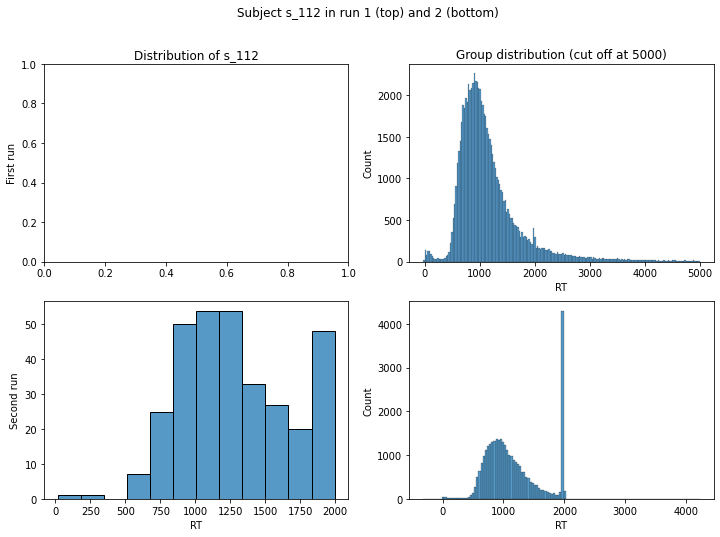

In [10]:
fig, axs = plt.subplots(2,2, figsize = (12,8))
sns.histplot(df_mst_raw.loc[df_mst_raw["userID"]=='s_112'].RT, ax=axs[0,0])
sns.histplot(data=df_mst_raw[df_mst_raw["RT"]<5000].reset_index(drop=True), x="RT", ax=axs[0,1])

sns.histplot(df_mst_set_rep.loc[df_mst_set_rep["userID"]=='s_112'].RT, ax=axs[1,0])
sns.histplot(data=df_mst_set_rep[df_mst_set_rep["RT"]<5000].reset_index(drop=True), x="RT", ax=axs[1,1])

axs[0,0].set_title('Distribution of s_112')
axs[0,1].set_title('Group distribution (cut off at 5000)')

axs[0,0].set_ylabel('First run')
axs[1,0].set_ylabel('Second run')

plt.suptitle(f'Subject s_112 in run 1 (top) and 2 (bottom)\n')
plt.show()

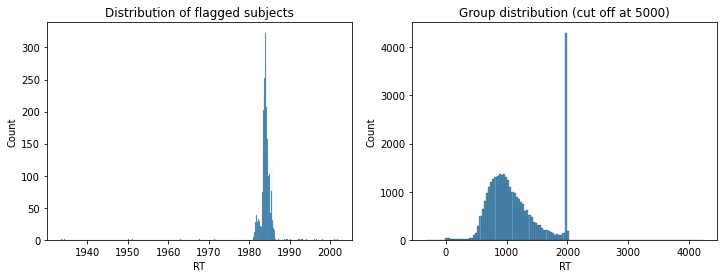

In [11]:
fig, axs = plt.subplots(1,2, figsize = (12,4))
sns.histplot(df_mst_set_rep.loc[df_mst_set_rep["userID"].isin(flagged_ptc)].RT, ax=axs[0])
sns.histplot(data=df_mst_set_rep[df_mst_set_rep["RT"]<5000].reset_index(drop=True), x="RT", ax=axs[1])

axs[0].set_title('Distribution of flagged subjects')
axs[1].set_title('Group distribution (cut off at 5000)')

plt.show()

<AxesSubplot: xlabel='RT', ylabel='Count'>

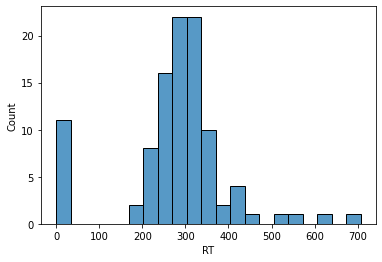

In [12]:
sns.histplot(df_mst_set_rep.groupby(['userID']).RT.std())

In [14]:
print(f"""Removing {len(df_mst_set_rep.loc[df_mst_set_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_mst_set_rep.loc[df_mst_set_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_mst_set_rep = df_mst_set_rep.loc[df_mst_set_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


# remove flagged participants 
exclude_ptc = flagged_ptc + []


df_mst_set_rep = df_mst_set_rep[~df_mst_set_rep['userID'].isin(exclude_ptc)]


# save
df_mst_set_rep.to_csv(os.path.join(csv_clean_data_path,'MST-cleaned_data_rep.csv'), index=False)

print(f'\nSaving {df_mst_set_rep.userID.unique().size} participants.')

if flagged_ptc:
    pd.DataFrame({
        'task': 'MST_rep',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "MST-flagged_ptc_rep.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 91 participants.


---

## PIM
[top](#top)

### Prepare and process PIM
[top](#top)

#### Set 1

In [2]:
# concat both full data and pilot data
df_pim_raw = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'complex_mem_task_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "seen",
                         "response", "timestamp", "x",
                         "vice", "hobby", "code_name", "country", "file", "still_img",
                         "response", "correct_response", "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"}),
    # add also pilot data
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'complex_mem_task_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct", "seen",
                         "response", "timestamp", "x",
                         "vice", "hobby", "code_name", "country", "file", "still_img",
                         "response", "correct_response", "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"})
])

# check if someone accessed twice
check_double_access(df_pim_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_pim_raw)

# drop test user
df_pim_raw = df_pim_raw[df_pim_raw["userID"] != 's_283']

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_pim_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()
# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

########### Cleaning
# select only real trials
df_pim_raw = df_pim_raw[df_pim_raw["sender_id"].str.startswith("3_", na=False)]

### drop the people who don't have a full dataset

# select MC trials to clean the data from not full subjects
tmp_user_count = df_pim_raw.loc[
    (df_pim_raw["sender"] == "Video") | (df_pim_raw["sender"] == "Recognition Questions"), "observation"].value_counts()
# get observations of people who have less than 24 trials in MC (one are their answers, the other is the coded=correct answer)
not_full_observations_MC = set(tmp_user_count[tmp_user_count < 2 * 24].keys())
# select rec trials to clean the data
tmp_user_count = df_pim_raw.loc[
    (df_pim_raw["sender"] == "Recognize") | (df_pim_raw["sender"] == "Confidence"), "observation"].value_counts()
# get observations of people who have less than 24 trials in rec (24 lures+24 targets, twice -> recog+confidence)
not_full_observations_rec = set(tmp_user_count[tmp_user_count < 2 * 48].keys())

# if the not-full lists are the same, just clean everything
if not_full_observations_MC == not_full_observations_rec:
    df_pim_raw = df_pim_raw[~df_pim_raw['observation'].isin(not_full_observations_MC)]
else:
    # if not, clean just the overlap, TODO - now it cleanes all the observations anyway but maybe we want to preserve the completed
    df_pim_raw = df_pim_raw[~df_pim_raw['observation'].isin(not_full_observations_MC | not_full_observations_rec)]
    warnings.warn(f'There were subjects (observations) in either MC or recognition that completed one but not the other.')

not_full_observations_MC, not_full_observations_rec, tmp_user_count = None, None, None

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)
# here we deal with full datasets only (above we cleaned all non-completed observations), so if user has not 1 set,
# it will be a multiple of a full set

# select MC trials to clean the data from not full subjects, helper line
tmp_user_count = df_pim_raw.loc[
    (df_pim_raw["sender"] == "Video") | (df_pim_raw["sender"] == "Recognition Questions"), "userID"].value_counts()
# find if someone has two full datasets
double_visits = tmp_user_count[tmp_user_count != 2 * 24].keys()

if not double_visits.empty:
    relevant_observation = df_pim_raw.loc[df_pim_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_pim_raw = df_pim_raw[~df_pim_raw["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_pim_raw)

# Do only recognition at the moment

# get correct answers for MC
# df_MC = df_pim_raw.loc[(df_pim_raw["sender"]=="Video")|(df_pim_raw["sender"]=="Recognition Questions"),
#                ["userID", "observation", "sender", "file", "still_img", "vice", "hobby", "code_name", "country"]].copy()

# to be able to find a correct answer, we first need to find it. The answers relate to each other through the filename
# so we will sort it by this name and then compare the two series
df_MC_correct = df_pim_raw.loc[(df_pim_raw["sender"] == "Video"),
                               ["userID", "observation", "still_img", "vice", "hobby", "code_name", "country"]
].sort_values(by=["userID", "still_img"]).copy()
df_MC_answer = df_pim_raw.loc[(df_pim_raw["sender"] == "Recognition Questions"),
                              ["userID", "observation", "file", "vice", "hobby", "code_name", "country"]
].sort_values(by=["userID", "file"]).copy()

# rename not matching expressions
df_MC_correct.replace({
    "Competitive dancing": "dancing",
    "Stand up comedy": "comedy",
    "Runs marathons": "marathons",
    "Plays in orchestra": "orchestra",
    "Always chewing gum": "chewing gum",
    "Always late": "late",
    "Compulsive gambler": "gambler",
    "Curses a lot": "curses",
    "Doesn't listen": "doesnt listen",
    "Incredibly shy": "shy",
    "Interrupts frequently": "interrupts",
    "Spits a lot": "spits",
    "Very lazy": "lazy",
}, inplace=True)


assert set(df_MC_correct.userID) == set(df_MC_answer.userID)

# reset index to be able to compare
df_MC_correct.reset_index(drop=True, inplace=True)
df_MC_answer.reset_index(drop=True, inplace=True)

# clean up the text -- make it lowercase
df_MC_answer = df_MC_answer.applymap(lambda s: s.lower() if type(s) == str else s)
df_MC_correct = df_MC_correct.applymap(lambda s: s.lower() if type(s) == str else s)

# replace _ in names
df_MC_answer["hobby"] = df_MC_answer["hobby"].str.replace('_', ' ')
df_MC_answer["vice"] = df_MC_answer["vice"].str.replace('_', ' ')

# check
assert set(df_MC_answer.hobby.values) == set(df_MC_correct.hobby.values)
assert set(df_MC_answer.vice.values) == set(df_MC_correct.vice.values)
assert sorted(df_MC_correct.hobby.unique()) == sorted(df_MC_answer.hobby.unique())
assert sorted(df_MC_correct.vice.unique()) == sorted(df_MC_answer.vice.unique())

# put it all in one df
df_MC = pd.DataFrame({
    "userID": df_MC_answer["userID"],
    "hobby": df_MC_answer["hobby"] == df_MC_correct["hobby"],
    "vice": df_MC_answer["vice"] == df_MC_correct["vice"],
    "country": df_MC_answer["country"] == df_MC_correct["country"],
    "code_name": df_MC_answer["code_name"] == df_MC_correct["code_name"],
}).sort_values(by=['userID']).reset_index(
    drop=True)  # .to_csv(os.path.join(csv_clean_data_path,'PIM_MC-cleaned_data.csv'), index=False)

There are 366 participants (observations) and 293 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 366 participants (observations) and 293 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 254 participants (observations) and 254 unique IDs.



/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_32428/3953534381.py:60: UserWarning: There were subjects (observations) in either MC or recognition that completed one but not the other.
  warnings.warn(f'There were subjects (observations) in either MC or recognition that completed one but not the other.')


I am not sure if this is sufficient but it gives an idea of what's going on. For MC, many of the criterions fail -- there is no real RT, no catch trials nor a sequence. So it doesn't make much sense to run it on it.

In [3]:
# do flag analysis
flagged_ptc, suspects = flag_participants(df_pim_raw, RT_thr=10000)

# this one is not a fake
if 's_295' in flagged_ptc:
    flagged_ptc.remove('s_295')

# ################
# # save
# if flagged_ptc:
#     pd.DataFrame({
#         'task': 'PIM',
#         'flagged_participants': flagged_ptc,
#     }).to_csv(os.path.join(csv_clean_data_path, "PIM-flagged_ptc.csv"), index=False)

userID
s_109    1453.466469
s_123    1430.067648
s_73     1392.716497
Name: RT, dtype: float64

--> Flagging 3 subjects for too narrow RT (bots/scripts).

In the task, there are 14 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 3 and mean of max per subject is 26.00 +/- 0.00.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 3 participants:
('s_109', 's_123', 's_73')


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)


In [4]:
df_MC[df_MC["userID"].isin(flagged_ptc)].groupby(['userID']).mean()

,hobby,vice,country,code_name
userID,,,,
s_109,0.708333,0.708333,0.750000,1.000000
s_123,0.708333,0.875000,0.791667,0.708333
s_73,0.708333,0.750000,0.666667,0.666667


In [5]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_pim_raw.loc[df_pim_raw["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_pim_raw.loc[df_pim_raw["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()

# df_pim_raw[df_pim_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()

In [6]:
# df_PGNG_raw.userID.value_counts()[df_PGNG_raw.userID.value_counts()<24]

In [7]:
print(f"""Removing {len(df_MC.loc[df_MC['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_MC.loc[df_MC['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_MC = df_MC.loc[df_MC['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

# save
df_MC.to_csv(os.path.join(csv_clean_data_path, 'PIM_MC-cleaned_data.csv'), index=False)

print(f"Saving {df_MC.userID.unique().size} participants in MC part.")

print(f"""Removing {len(df_pim_raw.loc[df_pim_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_pim_raw.loc[df_pim_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_pim_raw = df_pim_raw.loc[df_pim_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

# select picture recog
df_pim_raw.loc[(df_pim_raw["sender"] == "Recognize") | (df_pim_raw["sender"] == "Confidence"),
               ["userID", "observation", "sender", "correct", "response", "seen"]].sort_values(by=['userID']).to_csv(
    os.path.join(csv_clean_data_path, 'PIM_recog-cleaned_data.csv'), index=False)

print(f"Saving {df_pim_raw.userID.unique().size} participants in recognition part.")

Removing 5 subjects with not all data/consents
      ['s_265' 's_271' 's_278' 's_291' 's_292']
Saving 249 participants in MC part.
Removing 5 subjects with not all data/consents
      ['s_265' 's_278' 's_271' 's_292' 's_291']
Saving 249 participants in recognition part.


#### Set 2
[top](#top)

In [8]:
# those people had some issues in the first PIM-RISE version (slow loading, tests, ...) so exclude them
remove_observations = ["08108", "1d6a9", "2307c", "6c304", "6fb70", "7cb6b", "86f0a", "92d83", "9793b", "c1115",
                       "e1d98", "24a9c", "439fe", "61773", "64045", "9b3f1", "d00d7", "32503", "4d890", "58eb5",
                       "98bb5", "ee25e", "b0278", "ed38f", "00737", "572a6"]

# load RISE+PIM data
df_pim_raw_rep = pd.read_csv(os.path.join(csv_raw_data_path, 'PIM_RISE_standalone_data.csv'),
                             usecols=["user_id", "sender_id", "sender", "observation", "correct", "seen",
                                      "response", "timestamp", "x",
                                      "vice", "hobby", "code_name", "country", "file", "still_img",
                                      "response", "correct_response", "duration"
                                      ]
                             ).rename(columns={"user_id": "userID", "duration": "RT"})

# exclude the failed observations
df_pim_raw_rep = df_pim_raw_rep[~df_pim_raw_rep['observation'].isin(remove_observations)]

# check if someone accessed twice
check_double_access(df_pim_raw_rep)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_pim_raw_rep)


#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_pim_raw_rep.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# # sort by user and date, sort from earliest
# df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


########### Cleaning
# select only real trials, there is RISE so take only what belongs to PIM
df_pim_raw_rep = df_pim_raw_rep[df_pim_raw_rep["sender_id"].str.startswith("3_3_", na=False)]

### drop the people who don't have a full dataset

# select MC trials to clean the data from not full subjects
tmp_user_count = df_pim_raw_rep.loc[(df_pim_raw_rep["sender"]=="Video")|(df_pim_raw_rep["sender"]=="Recognition Questions"), "observation"].value_counts()
# get observations of people who have less than 24 trials in MC (one are their answers, the other is the coded=correct answer)
not_full_observations_MC = set(tmp_user_count[tmp_user_count < 2 * 24].keys())
# select rec trials to clean the data
tmp_user_count = df_pim_raw_rep.loc[(df_pim_raw_rep["sender"]=="Recognize") | (df_pim_raw_rep["sender"]=="Confidence"), "observation"].value_counts()
# get observations of people who have less than 24 trials in rec (24 lures+24 targets, twice -> recog+confidence)
not_full_observations_rec = set(tmp_user_count[tmp_user_count < 2 * 48].keys())

# if the not-full lists are the same, just clean everything
if not_full_observations_MC == not_full_observations_rec:
    df_pim_raw_rep = df_pim_raw_rep[~df_pim_raw_rep['observation'].isin(not_full_observations_MC)]
else:
    # if not, clean just the overlap, TODO - now it cleanes all the observations anyway but maybe we want to preserve the completed
    df_pim_raw_rep = df_pim_raw_rep[~df_pim_raw_rep['observation'].isin(not_full_observations_MC | not_full_observations_rec)]
    warnings.warn(f'There were subjects in either MC or recognition that completed one but not the other.')

not_full_observations_MC, not_full_observations_rec, tmp_user_count = None, None, None

# check again if someone accessed twice
check_double_access(df_pim_raw_rep)



############################################
# Load the second solo version
print('Loading solo version:\n')
df_pim_raw_rep_solo = pd.read_csv(os.path.join(csv_raw_data_path, 'PIM_solo_standalone_data.csv'),
                             usecols=["user_id", "sender_id", "sender", "observation", "correct", "seen",
                                      "response", "timestamp", "x",
                                      "vice", "hobby", "code_name", "country", "file", "still_img",
                                      "response", "correct_response", "duration"
                                      ]
                             ).rename(columns={"user_id": "userID", "duration": "RT"})

# check if someone accessed twice
check_double_access(df_pim_raw_rep_solo)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_pim_raw_rep_solo)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit_solo = df_pim_raw_rep_solo.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# # sort by user and date, sort from earliest
# df_first_visit_solo.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

########### Cleaning
# select only real trials
df_pim_raw_rep_solo = df_pim_raw_rep_solo[df_pim_raw_rep_solo["sender_id"].str.startswith("3_", na=False)]

### drop the people who don't have a full dataset

# select MC trials to clean the data from not full subjects
tmp_user_count = df_pim_raw_rep_solo.loc[(df_pim_raw_rep_solo["sender"]=="Video")|(df_pim_raw_rep_solo["sender"]=="Recognition Questions"), "observation"].value_counts()
# get observations of people who have less than 24 trials in MC (one are their answers, the other is the coded=correct answer)
not_full_observations_MC = set(tmp_user_count[tmp_user_count < 2 * 24].keys())
# select rec trials to clean the data
tmp_user_count = df_pim_raw_rep_solo.loc[(df_pim_raw_rep_solo["sender"]=="Recognize") | (df_pim_raw_rep_solo["sender"]=="Confidence"), "observation"].value_counts()
# get observations of people who have less than 24 trials in rec (24 lures+24 targets, twice -> recog+confidence)
not_full_observations_rec = set(tmp_user_count[tmp_user_count < 2 * 48].keys())

# if the not-full lists are the same, just clean everything
if not_full_observations_MC == not_full_observations_rec:
    df_pim_raw_rep_solo = df_pim_raw_rep_solo[~df_pim_raw_rep_solo['observation'].isin(not_full_observations_MC)]
else:
    # if not, clean just the overlap, TODO - now it cleanes all the observations anyway but maybe we want to preserve the completed
    df_pim_raw_rep_solo = df_pim_raw_rep_solo[~df_pim_raw_rep_solo['observation'].isin(not_full_observations_MC | not_full_observations_rec)]
    warnings.warn(f'There were subjects in either MC or recognition of SOLO that completed one but not the other.')


# check again if someone accessed twice
check_double_access(df_pim_raw_rep_solo)

# TODO -- double check, those were manually checked and it was decided to take their first visit
take_first_visits_users = ['5fb83adf4f4cdb51b0e0de2e', '607d93e1e9d80a022991650f', '60bf28df4926a8b6391df575']
df_pim_raw_rep_solo = df_pim_raw_rep_solo[~df_pim_raw_rep_solo['userID'].isin(take_first_visits_users)]

# check if we have overlap
overlapped_subjects = list(set(df_pim_raw_rep["userID"])&set(df_pim_raw_rep_solo["userID"]))
if len(overlapped_subjects) != 0:
    warnings.warn(f'There are {len(overlapped_subjects)} subjects that appear in both versions:\n{overlapped_subjects}')


#################
# Concatenate the two datasets
df_pim_raw_rep = pd.concat([df_pim_raw_rep, df_pim_raw_rep_solo]).reset_index(drop=True)

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# select MC trials to clean the data from not full subjects
tmp_user_count = df_pim_raw_rep.loc[(df_pim_raw_rep["sender"]=="Video")|(df_pim_raw_rep["sender"]=="Recognition Questions"), "userID"].value_counts()
# find if someone has two full datasets
double_visits = tmp_user_count[tmp_user_count != 2*24].keys()

if not double_visits.empty:
    relevant_observation = df_pim_raw_rep.loc[df_pim_raw_rep["userID"].isin(double_visits), "observation"].unique()

    # concat first visits
    df_first_visit = pd.concat([df_first_visit, df_first_visit_solo])
    df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_pim_raw_rep = df_pim_raw_rep[~df_pim_raw_rep["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# Do only recognition at the moment

# get correct answers for MC
# df_MC = df_pim_raw_rep.loc[(df_pim_raw_rep["sender"]=="Video")|(df_pim_raw_rep["sender"]=="Recognition Questions"),
#                ["userID", "observation", "sender", "file", "still_img", "vice", "hobby", "code_name", "country"]].copy()


# to be able to find a correct answer, we first need to find it. The answers relate to each other through the filename
# so we will sort it by this name and then compare the two series
df_MC_correct_rep = df_pim_raw_rep.loc[(df_pim_raw_rep["sender"] == "Video"),
                                       ["userID", "observation", "still_img", "vice", "hobby", "code_name", "country"]
].sort_values(by=["userID", "still_img"]).copy()
df_MC_answer_rep = df_pim_raw_rep.loc[(df_pim_raw_rep["sender"] == "Recognition Questions"),
                                      ["userID", "observation", "file", "vice", "hobby", "code_name", "country"]
].sort_values(by=["userID", "file"]).copy()

# rename not matching expressions
df_MC_correct_rep.replace({
    "Overly competitive": "overly competive",
}, inplace=True)

assert set(df_MC_correct_rep.userID) == set(df_MC_answer_rep.userID)

# reset index to be able to compare
df_MC_correct_rep.reset_index(drop=True, inplace=True)
df_MC_answer_rep.reset_index(drop=True, inplace=True)

# clean up the text -- make it lowercase
df_MC_answer_rep = df_MC_answer_rep.applymap(lambda s: s.lower() if type(s) == str else s)
df_MC_correct_rep = df_MC_correct_rep.applymap(lambda s: s.lower() if type(s) == str else s)

# replace _ in names
df_MC_answer_rep["hobby"] = df_MC_answer_rep["hobby"].str.replace('_', ' ')
df_MC_answer_rep["vice"] = df_MC_answer_rep["vice"].str.replace('_', ' ')

# check
assert set(df_MC_answer_rep.hobby.values) == set(df_MC_correct_rep.hobby.values)
assert set(df_MC_answer_rep.vice.values) == set(df_MC_correct_rep.vice.values)
assert sorted(df_MC_correct_rep.hobby.unique()) == sorted(df_MC_answer_rep.hobby.unique())
assert sorted(df_MC_correct_rep.vice.unique()) == sorted(df_MC_answer_rep.vice.unique())

# put it all in one df, sort by ID
df_MC_rep = pd.DataFrame({
    "userID": df_MC_answer_rep["userID"],
    "hobby": df_MC_answer_rep["hobby"] == df_MC_correct_rep["hobby"],
    "vice": df_MC_answer_rep["vice"] == df_MC_correct_rep["vice"],
    "country": df_MC_answer_rep["country"] == df_MC_correct_rep["country"],
    "code_name": df_MC_answer_rep["code_name"] == df_MC_correct_rep["code_name"],
}).sort_values(by=['userID']).reset_index(drop=True)  # .to_csv(os.path.join(csv_clean_data_path,'PIM_MC-cleaned_data.csv'), index=False)

There are 125 participants (observations) and 114 unique IDs! Check!

All is ok.
There are now 102 participants (observations) and 102 unique IDs.

Loading solo version:



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 125 participants (observations) and 114 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


There are 66 participants (observations) and 61 unique IDs! Check!

There are 60 participants (observations) and 59 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 66 participants (observations) and 61 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 60 participants (observations) and 59 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_32428/1661542419.py:125: UserWarning: There are 6 subjects that appear in both versions:
['s_45', 's_132', 's_222', 's_34', 's_112', 's_124']
  warnings.warn(f'There are {len(overlapped_subjects)} subjects that appear in both versions:\n{overlapped_subjects}')


In [9]:
# do flag analysis
flagged_ptc, suspects = flag_participants(df_pim_raw_rep, RT_thr=10000)

# ################
# # save
# if flagged_ptc:
#     pd.DataFrame({
#         'task': 'PIM_rep',
#         'flagged_participants': flagged_ptc,
#     }).to_csv(os.path.join(csv_clean_data_path, "PIM_rep-flagged_ptc.csv"), index=False)

userID
s_127    1277.365879
Name: RT, dtype: float64

--> Flagging 1 subjects for too narrow RT (bots/scripts).

In the task, there are 5 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 6 and mean of max per subject is 26.00 +/- 0.00.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 1 participants:
('s_127',)


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)


In [10]:
df_MC[df_MC["userID"].isin(flagged_ptc)].groupby('userID').mean()

,hobby,vice,country,code_name
userID,,,,
s_127,1.0,1.0,0.958333,1.0


In [11]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
# sns.histplot(df_pim_raw.loc[df_pim_raw["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
# sns.histplot(df_pim_raw.loc[df_pim_raw["RT"]<10000,"RT"], ax=axs[1])

# plt.plot()

# df_pim_raw[df_pim_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()



In [12]:
print(f"""Removing {len(df_MC_rep.loc[df_MC_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_MC_rep.loc[df_MC_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_MC_rep = df_MC_rep.loc[df_MC_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

# save
df_MC_rep.to_csv(os.path.join(csv_clean_data_path, 'PIM_MC-cleaned_data_rep.csv'), index=False)

print(f"Saving {df_MC_rep.userID.unique().size} participants in MC part.")


print(f"""Removing {len(df_pim_raw_rep.loc[df_pim_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_pim_raw_rep.loc[df_pim_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_pim_raw_rep = df_pim_raw_rep.loc[df_pim_raw_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

# select picture recog
df_pim_raw_rep.loc[(df_pim_raw_rep["sender"] == "Recognize") | (df_pim_raw_rep["sender"] == "Confidence"),
                   ["userID", "observation", "sender", "correct", "response", "seen"]].sort_values(by=['userID']).to_csv(
    os.path.join(csv_clean_data_path, 'PIM_recog-cleaned_data_rep.csv'), index=False)

print(f"Saving {df_pim_raw_rep.userID.unique().size} participants in recognition part.")

Removing 0 subjects with not all data/consents
      []
Saving 155 participants in MC part.
Removing 0 subjects with not all data/consents
      []
Saving 155 participants in recognition part.


## PGNG
[top](#top)

### Prepare and process PGNG
[top](#top)

This is a bit problematic -- in the pilot, there were three conditions, but for the experiment, we dropped the SS level (stop signs). That led to the fact that the naming is shifted by one or more in the `sender_id` and hence one has to process and clean the data separately and only concat then.


---

Also note the following:

* block 1 = practice (just press for target, 2 targets)
* block 2 = level 2 (two target context based)
* block 3 = level 1 (just press for target with 3 targets)
* block 4 = level 3 (three target context based)

We compute the following measures per block:

* *level prac - id target (new addition)*
  * *PCTT (percent correct target trials) = correct target responses / all potential target responses*

* level 1 - id target
  * PCTT (percent correct target trials) = correct target responses / all potential target responses
* level 2 - two target context based
  * PCTT (percent correct target trials) = correct target responses / all potential target responses
  * PCIT (percent correct inhibitory trials) = correct inhibitory trials/ all potential inhibitory trials
* level 3 - three target context based
  * PCTT (percent correct target trials) = correct target responses / all potential target responses
  * PCIT (percent correct inhibitory trials) = correct inhibitory trials/ all potential inhibitory trials
  

* RT is neither `duration` nor `response_time`!!!
    * RT is `reaction_time - time_show` as the screen does not progress after they push a button and it waits until it times out (or something else) so we want the time of their answer - the time when the screen was displayed.
  
Only responses to targets `r, s, t` are counted since we care if they answer to what they should and not to all the other trials.  

Notice that some responses are in capital letters so they need to be converted.

Because of this, have some accepted keys that we consider as typos:
```python
df_PGNG_raw['response'].value_counts()
```
```
n    24944
m       44
j       17
r        3
k        3
s        1
,        1
Name: response, dtype: int64
```

```python
df_PGNG_raw_rep['response'].value_counts()
```
```
n    14393
x       75
y       46
z       23
b        1
a        1
h        1
m        1
Name: response, dtype: int64
```

#### Set 1 (Feb2022)

In [2]:
# define what keys we consider as a correct answer (to account for typos), add also the target keys in case someone was pressing them
accepted_keys = ['b', 'n', 'm', 'j'] + ['r', 's', 't']

## LOAD both pilot and data

# concat both full data and pilot data
df_exp = pd.read_csv(os.path.join(csv_raw_data_path, 'PGNG_no_SS_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct_response", "correct_resp", "ended_on",
                         "timestamp", "x",
                         "target", "response",
                         "reaction_time", "time_show",
                         ]
                ).rename(columns={"user_id":"userID"})
# add also pilot data
df_pilot = pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'PGNG_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct_response", "correct_resp", "ended_on",
                         "timestamp", "x",
                         "target", "response",
                         "reaction_time", "time_show",
                         ]
                ).rename(columns={"user_id":"userID"})

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_exp)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_pilot)

# The files differ, in the piloting, there is this SS part, which is in training starting with 5
# then there are two block (7, 8) with 2 letters and two (10, 11) with three letters, 9 and 12 is dropped again
# In the other file, the 5 is missing, so everything is shifted -- it's 6, 7 and 9, 10


# check if someone accessed twice
print("Experiment\n")
check_double_access(df_exp)

print("Pilot\n")
check_double_access(df_pilot)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit_e = df_exp.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit_e.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit_p = df_pilot.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit_p.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data

# The files differ, in the piloting, there is this SS part, which is in training starting with 5
# then there are two block (7, 8) with 2 letters and two (10, 11) with three letters, 9 and 12 is dropped again
# In the other file (experiment), the 5 is missing, so everything is shifted -- it's 6, 7 and 9, 10

df_exp = df_exp[(df_exp["sender"]=="Letter")&
                ((df_exp["sender_id"].str.startswith("6_"))|(df_exp["sender_id"].str.startswith("7_"))|
                (df_exp["sender_id"].str.startswith("9_"))|(df_exp["sender_id"].str.startswith("10_")))]

df_pilot = df_pilot[(df_pilot["sender"]=="Letter")&
                    ((df_pilot["sender_id"].str.startswith("7_"))|(df_pilot["sender_id"].str.startswith("8_"))|
                    (df_pilot["sender_id"].str.startswith("10_"))|(df_pilot["sender_id"].str.startswith("11_")))]

# add a block -- it's just a label which is done based on the sender_id
df_exp["block"] = df_exp.sender_id.str.split('_').str[0].replace(to_replace={"6":1, "7":2, "9":3, "10":4})

# pilot has different sender_id
df_pilot["block"] = df_pilot.sender_id.str.split('_').str[0].replace(to_replace={"7":1, "8":2, "10":3, "11":4})

df_PGNG_raw = pd.concat([df_exp, df_pilot])

# merge the two correct columns
# https://stackoverflow.com/questions/41449555/pandas-combine-two-columns-with-null-values
df_PGNG_raw["correct_combined"] = df_PGNG_raw['correct_response'].fillna(df_PGNG_raw['correct_resp'])

# convert response to lower case because some are not
df_PGNG_raw["response"] = df_PGNG_raw["response"].str.lower()

# set all typos to be the right and expected answer
df_PGNG_raw["response"].replace(accepted_keys, value='n', inplace=True)


df_PGNG_raw["correct"] = 0 # Catherine's code sets the first two conditions to True and all the rest to false in the TRUE~FALSE statement
df_PGNG_raw.loc[(df_PGNG_raw["response"]=="n")&(df_PGNG_raw["correct_combined"]=="n"),"correct"] = 1
df_PGNG_raw.loc[(df_PGNG_raw["response"].isna())&(df_PGNG_raw["correct_combined"]=="y"),"correct"] = 1

df_PGNG_raw["inhibitory"] = np.nan
df_PGNG_raw.loc[(df_PGNG_raw["correct_combined"]=="y"),"inhibitory"] = 1
df_PGNG_raw.loc[(df_PGNG_raw["correct_combined"]=="n"),"inhibitory"] = 0

# There are some subjects who didn't finish, so they have to have a different max number of trials. - exclude them
full_participants = df_PGNG_raw["observation"].value_counts()[df_PGNG_raw["observation"].value_counts()==888].keys()
# drop the participants who have missed trials
df_PGNG_raw = df_PGNG_raw[df_PGNG_raw["observation"].isin(full_participants)]

# target only in ["r", "s", "t"] because we care only about the response to that
df_PGNG_raw = df_PGNG_raw[df_PGNG_raw["target"].isin(["r", "s", "t"])]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_PGNG_raw["userID"].value_counts()[df_PGNG_raw["userID"].value_counts() != 142].keys()

if not double_visits.empty:
    df_first_visit = pd.concat([df_first_visit_e, df_first_visit_p])

    relevant_observation = df_PGNG_raw.loc[df_PGNG_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_PGNG_raw = df_PGNG_raw[~df_PGNG_raw["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again
check_double_access(df_PGNG_raw)

# add RT
df_PGNG_raw["RT"] = df_PGNG_raw["reaction_time"] - df_PGNG_raw["time_show"]

# x = df_PGNG_raw.groupby(["userID"]).block.value_counts().unstack().reset_index()

################
# Quality checks

# find people with low acc on the first level - border line
suspects_level1 = df_PGNG_raw[df_PGNG_raw["block"]==1].groupby(['userID']).mean()['correct'][
    df_PGNG_raw[df_PGNG_raw["block"]==1].groupby(['userID']).mean()['correct']<\
    (df_PGNG_raw[df_PGNG_raw["block"]==1]['correct'].mean()-2*df_PGNG_raw[df_PGNG_raw["block"]==1]['correct'].std())
].index.tolist()

# exclude all that have less than 3SD
exclude_ptc_level1 = df_PGNG_raw[df_PGNG_raw["block"]==1].groupby(['userID']).mean()['correct'][
    df_PGNG_raw[df_PGNG_raw["block"]==1].groupby(['userID']).mean()['correct']<\
    (df_PGNG_raw[df_PGNG_raw["block"]==1]['correct'].mean()-3*df_PGNG_raw[df_PGNG_raw["block"]==1]['correct'].std())
].index.tolist()

suspects_level1 = list(set(suspects_level1)-set(exclude_ptc_level1))

print(f'There are {len(suspects_level1)} suspects with low acc on 1st level and {len(exclude_ptc_level1)} excluded.\n')

# exclude the low acc on level 1
df_PGNG_raw = df_PGNG_raw[~df_PGNG_raw['userID'].isin(exclude_ptc_level1)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_PGNG_raw, RT_thr=10000, correct_response='correct_combined')
# select only relevant
df_PGNG_raw = df_PGNG_raw[['observation', 'RT', 'userID', 'response', 'target', 'block', 'correct_combined', 'correct', 'inhibitory']]


# sort the df to easily find changes in csv file when updated
df_PGNG_raw.sort_values(by=["userID"], inplace=True)

Experiment

There are 196 participants (observations) and 185 unique IDs! Check!

Pilot

There are 71 participants (observations) and 59 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 196 participants (observations) and 185 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 71 participants (observations) and 59 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 239 participants (observations) and 239 unique IDs.

There are 4 suspects with low acc on 1st level and 0 excluded.

Series([], Name: RT, dtype: float64)
In the task, there are 20 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 29 and mean of max per subject is 25.50 +/- 17.82.
userID
s_38    71
Name: response_conv, dtype: int64

--> Flagging 1 subjects for too long consecutive answers.

In total flagging 1 participants:
('s_38',)


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)


In [3]:
print('Overlapped suspects:', set(suspects)&set(suspects_level1))

print('group:\n', df_PGNG_raw.mean()[["RT", "correct"]])
print(df_PGNG_raw[df_PGNG_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()[["RT", "correct"]])
print()
print('group:\n', df_PGNG_raw.groupby(['block']).mean()[["RT", "correct"]])
df_PGNG_raw[df_PGNG_raw["userID"].isin(flagged_ptc)].groupby(['userID', 'block']).mean()[["RT", "correct"]]


Overlapped suspects: {'s_156', 's_97', 's_228'}
group:
 RT         504.705666
correct      0.822411
dtype: float64
                RT   correct
userID                      
s_38    584.512568  0.366197

group:
                RT   correct
block                      
1      473.063301  0.915674
2      493.946572  0.816736
3      506.225442  0.884294
4      542.284780  0.738447


RT   correct
userID block                      
s_38   1      573.780800  0.384615
       2      558.130366  0.644444
       3      585.574118  0.000000
       4      643.059650  0.288889

In [4]:
print('Check flagged by low acc on 1st level\ngroup:\n', df_PGNG_raw.groupby(['block']).mean()[["RT", "correct"]])
df_PGNG_raw[df_PGNG_raw["userID"].isin(set(suspects_level1)-set(flagged_ptc))].groupby(['userID', 'block']).mean()[["RT", "correct"]]


Check flagged by low acc on 1st level
group:
                RT   correct
block                      
1      473.063301  0.915674
2      493.946572  0.816736
3      506.225442  0.884294
4      542.284780  0.738447


RT   correct
userID block                      
s_156  1      524.080500  0.230769
       2      487.636500  0.400000
       3      484.664000  0.923077
       4      485.742333  0.355556
s_204  1      510.091667  0.230769
       2      527.715564  0.777778
       3      486.466000  0.884615
       4      566.485267  0.733333
s_228  1      377.045500  0.230769
       2      363.391750  0.400000
       3      316.527682  0.846154
       4      345.537926  0.533333
s_97   1      570.772500  0.307692
       2             NaN  0.266667
       3      616.180000  0.230769
       4      629.420000  0.333333

In [5]:
df_PGNG_raw[df_PGNG_raw['userID'].isin(suspects)].groupby(['userID']).mean()[["RT", "correct"]]

,RT,correct
userID,,
s_102,472.699800,0.570423
s_104,525.919536,0.556338
s_112,617.432043,0.563380
s_120,538.420653,0.598592
s_124,541.919124,0.591549
s_125,527.769571,0.626761
s_127,489.909662,0.619718
s_128,548.574783,0.549296
s_156,491.091171,0.450704


In [6]:
print('group:\n', df_PGNG_raw.groupby(['block']).mean()[["RT", "correct"]])
df_PGNG_raw[df_PGNG_raw["userID"].isin(set(suspects)-set(flagged_ptc)-set(suspects_level1))].groupby(['userID', 'block']).mean()[["RT", "correct"]].head(60)



group:
                RT   correct
block                      
1      473.063301  0.915674
2      493.946572  0.816736
3      506.225442  0.884294
4      542.284780  0.738447


RT   correct
userID block                      
s_102  1      436.001615  1.000000
       2      614.280429  0.333333
       3      464.192769  1.000000
       4      656.971000  0.311111
s_104  1      501.309400  0.961538
       2      473.061000  0.311111
       3      546.826280  0.961538
       4      575.495000  0.333333
s_112  1      619.441455  0.846154
       2      599.295938  0.533333
       3      606.155125  0.615385
       4      648.587652  0.400000
s_120  1      524.306583  0.923077
       2      518.209119  0.711111
       3      609.396833  0.461538
       4      555.216050  0.377778
s_124  1      499.811600  0.769231
       2      557.463556  0.666667
       3      526.484667  0.576923
       4      561.690962  0.422222
s_125  1      522.897833  0.461538
       2      526.519111  0.622222
       3      522.212609  0.884615
       4      536.335778  0.577778
s_127  1      463.974160  0.961538
       2      490.288591  0.711111
       3      525.468056  0.692308
       4             NaN  0.288889
s_128  1      507.012941  0.653846
       2      552.402222  0.511111
       3      539.579667  0.692308
       4      585.009190  0.444444
s_158  1      606.486000  0.576923
       2      553.901778  0.333333
       3      606.927667  0.576923
       4      607.676500  0.333333
s_160  1      601.955538  0.500000
       2      603.766615  0.466667
       3      628.042714  0.538462
       4      591.760545  0.400000
s_171  1      570.456105  0.730769
       2      626.418474  0.600000
       3      612.903429  0.538462
       4      593.136118  0.400000
s_4    1      496.515417  0.923077
       2      569.597364  0.688889
       3      580.994875  0.307692
       4      559.580200  0.400000
s_55   1      482.485500  0.615385
       2      596.741611  0.488889
       3      504.090444  0.692308
       4      562.636440  0.533333
s_59   1      536.210143  0.807692
       2      536.893811  0.600000
       3      539.564000  0.423077
       4      519.070294  0.444444
s_60   1      552.158111  0.692308
       2      596.108500  0.311111
       3      536.344095  0.807692
       4      593.056615  0.422222

In [7]:
print(f"""Removing {len(df_PGNG_raw.loc[df_PGNG_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_PGNG_raw.loc[df_PGNG_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_PGNG_raw = df_PGNG_raw.loc[df_PGNG_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = ['s_38']

df_PGNG_raw = df_PGNG_raw[~df_PGNG_raw['userID'].isin(exclude_ptc)]

################
# save    
df_PGNG_raw.to_csv(os.path.join(csv_clean_data_path, "PGNG-cleaned_data.csv"), index=False)

print(f'\nSaving {df_PGNG_raw.userID.unique().size} participants.')

if flagged_ptc:
    pd.DataFrame({
        'task': 'PGNG',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "PGNG-flagged_ptc.csv"), index=False)    

Removing 1 subjects with not all data/consents
      ['s_282']

Saving 237 participants.


In [8]:
# num trials
print(2*(26+45))

df_PGNG_raw.userID.value_counts()[df_PGNG_raw.userID.value_counts()>142]#.keys()

142


Series([], Name: userID, dtype: int64)

In [9]:
df_PGNG_raw.userID.value_counts()[df_PGNG_raw.userID.value_counts()<142]

Series([], Name: userID, dtype: int64)

#### Set 2
[top](#top)

Basically the same as set 1 except: 
* here the `x,y,z` keys are used instead of `r,s,t` 
* the blocks are named differently. `6 -> 1, 7 -> 2, 9 -> 3, 10 -> 4`
* the `correct_response` and `correct_resp` columns are already merged.
* the number of trials differ, in the original there is 888, here there is 996. For the trials we care about we had 142 before and 159 now. The only difference is in `block 3` with `43` trials instead of `26` as it should. By looking at the code, it looks like the csv file with the trials contained more trials but is the same as the *Set 1* until the 168th trial meaning we could just cut it there and use the same data.

In [10]:
# define what keys we consider as a correct answer (to account for typos), add also the target keys in case someone was pressing them
accepted_keys = ['b', 'n', 'm', 'j'] + ['x', 'y', 'z']

## LOAD data

df_PGNG_raw_rep = pd.read_csv(os.path.join(csv_raw_data_path, 'PGNG_xyz_standalone_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct_response", "ended_on",
                         "timestamp", "x",
                         "target", "response",
                         "correct_response",
                         "reaction_time", "time_show",
                         ]
                ).rename(columns={"user_id":"userID"})

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_PGNG_raw_rep)

# check if someone accessed twice
check_double_access(df_PGNG_raw_rep)


#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_PGNG_raw_rep.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)

# # drop duplicates based on the user, get the observation values
# first_user_entry = df_first_visit.drop_duplicates(subset=['userID']).observation.values

# # update the df
# df_PGNG_raw_rep = df_PGNG_raw_rep[df_PGNG_raw_rep["observation"].isin(first_user_entry)]

# # check again if someone accessed twice
# check_double_access(df_PGNG_raw_rep)



################
# Clean the data

# The files differ, in the piloting, there is this SS part, which is in training starting with 5
# then there are two block (7, 8) with 2 letters and two (10, 11) with three letters, 9 and 12 is dropped again
# In the other file (experiment), the 5 is missing, so everything is shifted -- it's 6, 7 and 9, 10

df_PGNG_raw_rep = df_PGNG_raw_rep[(df_PGNG_raw_rep["sender"]=="Letter")&
                ((df_PGNG_raw_rep["sender_id"].str.startswith("6_"))|(df_PGNG_raw_rep["sender_id"].str.startswith("7_"))|
                (df_PGNG_raw_rep["sender_id"].str.startswith("8_"))|(df_PGNG_raw_rep["sender_id"].str.startswith("9_")))]


# add a block -- it's just a label which is done based on the sender_id
df_PGNG_raw_rep["block"] = df_PGNG_raw_rep.sender_id.str.split('_').str[0].replace(to_replace={"6":1, "7":2, "8":3, "9":4})


# merge the two correct columns -- just copy it here since the data already contains the information
df_PGNG_raw_rep["correct_combined"] = df_PGNG_raw_rep['correct_response']

# convert response to lower case because some are not
df_PGNG_raw_rep["response"] = df_PGNG_raw_rep["response"].str.lower()

# set all typos to be the right and expected answer
df_PGNG_raw_rep["response"].replace(accepted_keys, value='n', inplace=True)


df_PGNG_raw_rep["correct"] = 0 # Catherine's code sets the first two conditions to True and all the rest to false in the TRUE~FALSE statement
df_PGNG_raw_rep.loc[(df_PGNG_raw_rep["response"]=="n")&(df_PGNG_raw_rep["correct_combined"]=="n"),"correct"] = 1
df_PGNG_raw_rep.loc[(df_PGNG_raw_rep["response"].isna())&(df_PGNG_raw_rep["correct_combined"]=="y"),"correct"] = 1

df_PGNG_raw_rep["inhibitory"] = np.nan
df_PGNG_raw_rep.loc[(df_PGNG_raw_rep["correct_combined"]=="y"),"inhibitory"] = 1
df_PGNG_raw_rep.loc[(df_PGNG_raw_rep["correct_combined"]=="n"),"inhibitory"] = 0

# There are some subjects who didn't finish, so they have to have a different max number of trials. - exclude them

full_participants = df_PGNG_raw_rep["observation"].value_counts()[df_PGNG_raw_rep["observation"].value_counts()==996].keys()
# drop the participants who have missed trials
df_PGNG_raw_rep = df_PGNG_raw_rep[df_PGNG_raw_rep["observation"].isin(full_participants)]

# --------> change of letters
# target only in ["x", "y", "z"] because we care only about the response to that
df_PGNG_raw_rep = df_PGNG_raw_rep[df_PGNG_raw_rep["target"].isin(["x", "y", "z"])]

# x = df_PGNG_raw_rep.groupby(["userID"]).block.value_counts().unstack().reset_index()

# create masking array to drop the unwanted trials in block 3
mask = np.concatenate((np.ones(26+45+26),
                np.zeros(df_PGNG_raw_rep['observation'].value_counts().unique()[0]-142),
                np.ones(45),
               ))

# df_PGNG_raw_rep = df_PGNG_raw_rep[np.tile(mask, df_PGNG_raw_rep.userID.unique().size).astype(bool)].copy()
df_PGNG_raw_rep = df_PGNG_raw_rep[np.tile(mask, df_PGNG_raw_rep['observation'].unique().size).astype(bool)].copy()

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_PGNG_raw_rep["userID"].value_counts()[df_PGNG_raw_rep["userID"].value_counts() != 142].keys()

if not double_visits.empty:
    relevant_observation = df_PGNG_raw_rep.loc[df_PGNG_raw_rep["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_PGNG_raw_rep = df_PGNG_raw_rep[~df_PGNG_raw_rep["observation"].isin(set(relevant_observation)-set(first_user_entry))]


# check again
check_double_access(df_PGNG_raw_rep)

# add RT
df_PGNG_raw_rep["RT"] = df_PGNG_raw_rep["reaction_time"] - df_PGNG_raw_rep["time_show"]

################
# Quality checks

# find people with low acc on the first level - border line
suspects_level1 = df_PGNG_raw_rep[df_PGNG_raw_rep["block"]==1].groupby(['userID']).mean()['correct'][
    df_PGNG_raw_rep[df_PGNG_raw_rep["block"]==1].groupby(['userID']).mean()['correct']<\
    (df_PGNG_raw_rep[df_PGNG_raw_rep["block"]==1]['correct'].mean()-2*df_PGNG_raw_rep[df_PGNG_raw_rep["block"]==1]['correct'].std())
].index.tolist()

# exclude all that have less than 3SD
exclude_ptc_level1 = df_PGNG_raw_rep[df_PGNG_raw_rep["block"]==1].groupby(['userID']).mean()['correct'][
    df_PGNG_raw_rep[df_PGNG_raw_rep["block"]==1].groupby(['userID']).mean()['correct']<\
    (df_PGNG_raw_rep[df_PGNG_raw_rep["block"]==1]['correct'].mean()-3*df_PGNG_raw_rep[df_PGNG_raw_rep["block"]==1]['correct'].std())
].index.tolist()

suspects_level1 = list(set(suspects_level1)-set(exclude_ptc_level1))

print(f'There are {len(suspects_level1)} suspects with low acc on 1st level and {len(exclude_ptc_level1)} excluded.\n')

# exclude the low acc on level 1
df_PGNG_raw_rep = df_PGNG_raw_rep[~df_PGNG_raw_rep['userID'].isin(exclude_ptc_level1)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_PGNG_raw_rep, RT_thr=10000)
# select only relevant
df_PGNG_raw_rep = df_PGNG_raw_rep[['observation', 'RT', 'userID', 'response', 'target', 'block', 'correct_combined', 'correct', 'inhibitory']]

# sort the df to easily find changes in csv file when updated
df_PGNG_raw_rep.sort_values(by=["userID"], inplace=True)

There are 174 participants (observations) and 162 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 174 participants (observations) and 162 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 159 participants (observations) and 159 unique IDs.

There are 1 suspects with low acc on 1st level and 0 excluded.

Series([], Name: RT, dtype: float64)
In the task, there are 11 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 29 and mean of max per subject is 21.73 +/- 9.87.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)


In [11]:
print('Overlapped suspects:', set(suspects)&set(suspects_level1))

print('Flagged:\ngroup:\n', df_PGNG_raw_rep.mean()[["RT", "correct"]])
print(df_PGNG_raw_rep[df_PGNG_raw_rep["userID"].isin(flagged_ptc)].groupby(['userID']).mean()[["RT", "correct"]])
print()
print('group:\n', df_PGNG_raw_rep.groupby(['block']).mean()[["RT", "correct"]])
df_PGNG_raw_rep[df_PGNG_raw_rep["userID"].isin(flagged_ptc)].groupby(['userID', 'block']).mean()[["RT", "correct"]]


Overlapped suspects: {'s_173'}
Flagged:
group:
 RT         511.295154
correct      0.840110
dtype: float64
Empty DataFrame
Columns: [RT, correct]
Index: []

group:
                RT   correct
block                      
1      489.656809  0.921384
2      496.951412  0.841929
3      508.695210  0.895017
4      546.759531  0.759609


,,RT,correct
userID,block,,


In [12]:
print('Check flagged by low acc on 1st level\ngroup:\n', df_PGNG_raw_rep.groupby(['block']).mean()[["RT", "correct"]])
df_PGNG_raw_rep[df_PGNG_raw_rep["userID"].isin(set(suspects_level1)-set(flagged_ptc))].groupby(['userID', 'block']).mean()[["RT", "correct"]]


Check flagged by low acc on 1st level
group:
                RT   correct
block                      
1      489.656809  0.921384
2      496.951412  0.841929
3      508.695210  0.895017
4      546.759531  0.759609


RT   correct
userID block                      
s_173  1      323.706000  0.346154
       2      405.483812  0.511111
       3      401.449000  0.961538
       4      318.241000  0.666667

In [13]:
print('suspects')
df_PGNG_raw_rep[df_PGNG_raw_rep['userID'].isin(set(suspects)-set(flagged_ptc)-set(suspects_level1))].groupby(['userID']).mean()[["RT", "correct"]]

suspects


,RT,correct
userID,,
s_164,520.673280,0.619718
s_171,526.622718,0.380282
s_187,500.442476,0.647887
s_214,549.588916,0.507042
s_217,536.730345,0.570423
s_45,537.935913,0.535211
s_55,588.965949,0.584507
s_8,572.093181,0.528169
s_81,599.393396,0.521127


In [14]:
df_PGNG_raw_rep[df_PGNG_raw_rep['userID'].isin(set(suspects)-set(flagged_ptc)-set(suspects_level1))].groupby(['userID', 'block']).mean()[["RT", "correct"]]


RT   correct
userID block                      
s_164  1      464.853269  1.000000
       2      548.576429  0.422222
       3      521.537450  0.769231
       4      553.291385  0.511111
s_171  1      504.759263  0.730769
       2      510.170667  0.333333
       3      530.583333  0.230769
       4      566.713455  0.311111
s_187  1      515.352550  0.769231
       2      512.193462  0.688889
       3      464.176867  0.576923
       4      493.114690  0.577778
s_214  1      548.255652  0.884615
       2      565.364000  0.466667
       3      510.364333  0.230769
       4      547.611212  0.488889
s_217  1      571.526941  0.653846
       2      533.319097  0.600000
       3      516.119944  0.692308
       4      530.352222  0.422222
s_45   1      517.340154  0.500000
       2      491.665182  0.466667
       3      570.477538  0.500000
       4      548.988469  0.644444
s_55   1      582.029905  0.807692
       2      624.019471  0.600000
       3      548.288812  0.615385
       4      597.323500  0.422222
s_8    1      538.332294  0.653846
       2      557.613700  0.444444
       3      577.008273  0.423077
       4      605.820625  0.600000
s_81   1      558.708250  0.615385
       2      618.588900  0.444444
       3      618.174267  0.576923
       4      614.167917  0.511111
s_88   1      485.979040  0.961538
       2      525.132806  0.644444
       3      525.685437  0.615385
       4      563.498593  0.400000

In [15]:
print(f"""Removing {len(df_PGNG_raw_rep.loc[df_PGNG_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_PGNG_raw_rep.loc[df_PGNG_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_PGNG_raw_rep = df_PGNG_raw_rep.loc[df_PGNG_raw_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_PGNG_raw_rep = df_PGNG_raw_rep[~df_PGNG_raw_rep['userID'].isin(exclude_ptc)]


################
# save
df_PGNG_raw_rep.to_csv(os.path.join(csv_clean_data_path, "PGNG-cleaned_data_rep.csv"), index=False)

print(f'\nSaving {df_PGNG_raw_rep.userID.unique().size} participants.')

if flagged_ptc:
    pd.DataFrame({
        'task': 'PGNG_rep',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "PGNG-flagged_ptc_rep.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 159 participants.


In [16]:
df_PGNG_raw_rep.userID.value_counts()[df_PGNG_raw_rep.userID.value_counts()!=142]

Series([], Name: userID, dtype: int64)

## RISE
[top](#top)

### Prepare and process RISE
[top](#top)

The yes and no are randomised —> that means that for each subject we have the ArrowLeft and ArrowRight randomly selected to be yes and no --> this correct/incorrect is per subject and not the same for all. There is the method Catherine is using in her script (get this per subject and then per subject assign the correct/incorrect), there is also my method (extend the label (Left/Right) per subject, then compare the needed columns). They both give the same answer as seen below. If you want to only run mine (faster, cleaner), jump to [Purely my method of getting the correct answer](#Purely-my-method-of-getting-the-correct-answer)

#### Set 1

In [2]:
## NOTE:
# My method and Catherine's method give the same results, just mine should be faster and cleaner (less code, easier)
# If you want to choose, take mine, it is below

## LOAD both pilot and data

# concat both full data and pilot data
df_RISE_raw = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'RISE_test_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "timestamp", "x",
                         "together_key", "apart_key", "response", "pair_type",
                         "correct_response", "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"}),
    # add also pilot data
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'RISE_test_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "timestamp", "x",
                         "together_key", "apart_key", "response", "pair_type",
                         "correct_response", "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"})
])

# check if someone accessed twice
check_double_access(df_RISE_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_RISE_raw)

# There is a randomisation in place for right and left key so we need to get per participant what the correct answer is
# -> CAREFUL, since one user can access a few times, one needs to take observation
# -> not needed for my way, only for Catherine's
df_keys_lookup = df_RISE_raw[["userID", "observation", "together_key", "apart_key"]].dropna().copy()
# fillna for the keys -- that will then be used to get the correct/incorrect
df_RISE_raw["together_key"].fillna(method="ffill", inplace=True)
df_RISE_raw["apart_key"].fillna(method="ffill", inplace=True)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_RISE_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data

df_RISE_raw = df_RISE_raw[~df_RISE_raw["sender_id"].isna()]

## Normal way - just take the correct/incorrect
# all the real trials are denoted with 4_1 and only the Relational Trials
df_RISE_raw = df_RISE_raw[(df_RISE_raw["sender_id"].str.startswith("4_1")) & (df_RISE_raw["sender"] == 'Relational Trial')]

# keep a log of who has missed trials
participants_with_missed = df_RISE_raw.loc[df_RISE_raw["correct"].isna(), 'userID'].unique()

# add labels for missed trials
df_RISE_raw.loc[df_RISE_raw["correct"].isna(), 'correct'] = 'missed'

# df_RISE_raw[df_RISE_raw["userID"]=='60bddc13bec08854c614d30b']
# drop all the nans which will merge the answers from late trials and fresh trials
df_RISE_raw = df_RISE_raw[~df_RISE_raw["correct"].isna()]

## Catherine's way -- what she does and why, it gives a very different output
# Answer -- she doesn't trust the labels were interpreted well so she doesn't trust the `correct` column
df_RISE_raw["Catherine_correct"] = 0
# update the correct values in the places where conditions are met, use the arrow labels per participant
for user in df_RISE_raw["observation"].unique():
    df_RISE_raw.loc[(df_RISE_raw["observation"]==user) & (df_RISE_raw["pair_type"]=="Old") & (df_RISE_raw["response"]==df_keys_lookup.loc[df_keys_lookup["observation"]==user, "together_key"].values[0]),
                    "Catherine_correct"] = 1
    df_RISE_raw.loc[(df_RISE_raw["observation"]==user) & (df_RISE_raw["pair_type"]=="New") & (df_RISE_raw["response"]==df_keys_lookup.loc[df_keys_lookup["observation"]==user, "apart_key"].values[0]),
                    "Catherine_correct"] = 1

df_RISE_raw['my_correct'] = "missed"
df_RISE_raw.loc[df_RISE_raw["pair_type"] == "Old", "my_correct"] = df_RISE_raw.loc[df_RISE_raw["pair_type"] == "Old", "response"] == \
                                                                   df_RISE_raw.loc[df_RISE_raw["pair_type"] == "Old", "together_key"]
df_RISE_raw.loc[df_RISE_raw["pair_type"] == "New", "my_correct"] = df_RISE_raw.loc[df_RISE_raw["pair_type"] == "New", "response"] == \
                                                                   df_RISE_raw.loc[df_RISE_raw["pair_type"] == "New", "apart_key"]

# check if my method is the same as Catherine's
assert (df_RISE_raw["my_correct"] != df_RISE_raw["Catherine_correct"].astype(bool)).sum() == 0
# assert (df_RISE_raw["my_correct"]!=df_RISE_raw["Catherine_correct"]).sum() == 0

# take care of missed trials -- decided to be nan
df_RISE_raw.loc[df_RISE_raw["correct"] == "missed", "my_correct"] = np.nan
df_RISE_raw.loc[df_RISE_raw["correct"] == "missed", "Catherine_correct"] = np.nan

# drop the participants who have missed trials (for now - TODO decide what to do with them)
df_RISE_raw = df_RISE_raw[~df_RISE_raw["userID"].isin(participants_with_missed)]

# df_RISE_raw.loc[df_RISE_raw["pair_type"] == "Old", ["observation", "together_key","apart_key", "response", "Catherine_correct"]]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_RISE_raw["userID"].value_counts()[df_RISE_raw["userID"].value_counts() != 36].keys()

if not double_visits.empty:
    relevant_observation = df_RISE_raw.loc[df_RISE_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_RISE_raw = df_RISE_raw[~df_RISE_raw["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_RISE_raw)

# do flag analysis - TODO with the press key
flagged_ptc, suspects = flag_participants(df_RISE_raw, RT_thr=10000, measure='my_correct')
# select only relevant
df_RISE_raw = df_RISE_raw[['observation', 'RT', 'userID', 'response', 'correct_response', 'pair_type', 'Catherine_correct', 'my_correct']]

# sort the df to easily find changes in csv file when updated
df_RISE_raw.sort_values(by=["userID"], inplace=True)


There are 249 participants (observations) and 246 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 249 participants (observations) and 246 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 242 participants (observations) and 242 unique IDs.

Series([], Name: RT, dtype: float64)
In the task, there are 11 suspects.

--> Flagging 2 subjects for RT.

Max naturally occurring answers is 36 and mean of max per subject is 7.55 +/- 3.36.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 2 participants:
('s_10', 's_228')


std:
                 RT  Catherine_correct  my_correct
userID                                           
s_10    119.724300           0.506309    0.506309
s_228   104.167838           0.500000    0.500000 

mean:



,RT,Catherine_correct,my_correct
userID,,,
s_10,141.980000,0.527778,0.527778
s_228,146.428361,0.416667,0.416667


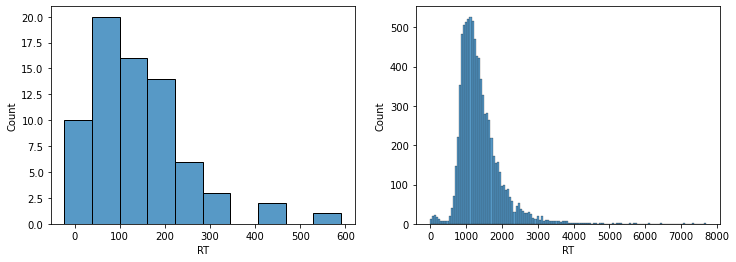

In [3]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df_RISE_raw.loc[df_RISE_raw["userID"].isin(flagged_ptc),"RT"], ax=axs[0])
sns.histplot(df_RISE_raw.loc[df_RISE_raw["RT"]<10000,"RT"], ax=axs[1])

plt.plot()

print('std:\n',df_RISE_raw[df_RISE_raw["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
df_RISE_raw[df_RISE_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean()

In [4]:
print(df_RISE_raw.mean()[["RT", "my_correct"]])
df_RISE_raw[df_RISE_raw['userID'].isin(set(suspects))].groupby(['userID']).mean()[["RT", "my_correct"]]


RT            1370.746215
my_correct       0.764807
dtype: float64


,RT,my_correct
userID,,
s_10,141.980000,0.527778
s_109,871.000000,0.527778
s_117,1398.682472,0.500000
s_124,1210.032306,0.527778
s_175,719.797611,0.500000
s_214,562.738750,0.527778
s_228,146.428361,0.416667
s_249,1326.950000,0.527778
s_27,1034.484861,0.472222


In [5]:
print(df_RISE_raw.groupby('pair_type').mean()[["RT", "my_correct"]])
df_RISE_raw[df_RISE_raw['userID'].isin(set(suspects))].groupby(['userID', 'pair_type']).mean()[["RT", "my_correct"]]


                    RT  my_correct
pair_type                         
New        1398.801545    0.817952
Old        1342.690885    0.711662


RT  my_correct
userID pair_type                         
s_10   New         152.852222    0.444444
       Old         131.107778    0.611111
s_109  New         881.277778    0.555556
       Old         860.722222    0.500000
s_117  New        1461.313389    0.555556
       Old        1336.051556    0.444444
s_124  New        1185.666556    0.388889
       Old        1234.398056    0.666667
s_175  New         763.315222    0.722222
       Old         676.280000    0.277778
s_214  New         525.848056    0.444444
       Old         599.629444    0.611111
s_228  New         149.555056    0.444444
       Old         143.301667    0.388889
s_249  New        1370.507778    0.888889
       Old        1283.392222    0.166667
s_27   New        1006.842111    0.666667
       Old        1062.127611    0.277778
s_36   New         875.691722    0.611111
       Old         895.146833    0.444444
s_62   New        1463.112389    0.555556
       Old        1320.475444    0.388889

In [6]:
print(f"""Removing {len(df_RISE_raw.loc[df_RISE_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_RISE_raw.loc[df_RISE_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_RISE_raw = df_RISE_raw.loc[df_RISE_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


# I think that all suspects are ok and real performance
exclude_ptc = []

df_RISE_raw = df_RISE_raw[~df_RISE_raw['userID'].isin(exclude_ptc)]


################
# save
df_RISE_raw.to_csv(os.path.join(csv_clean_data_path, "RISE-cleaned_data.csv"), index=False)


print(f'\nSaving {df_RISE_raw.userID.unique().size} participants.')

if flagged_ptc:
    pd.DataFrame({
        'task': 'RISE',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "RISE-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 242 participants.


In [7]:
df_RISE_raw.userID.value_counts()[df_RISE_raw.userID.value_counts()>36]#.keys()

Series([], Name: userID, dtype: int64)

In [8]:
df_RISE_raw.userID.value_counts()[df_RISE_raw.userID.value_counts()<36]

Series([], Name: userID, dtype: int64)

#### Purely my method of getting the correct answer

In [ ]:
## LOAD both pilot and data

# concat both full data and pilot data
df_RISE_raw = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'RISE_test_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "timestamp", "x",
                        "together_key", "apart_key","response", "pair_type",
                         "correct_response", "duration"
                         ]
                ).rename(columns={"user_id":"userID", "duration":"RT"}),
    # add also pilot data
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'RISE_test_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "timestamp", "x",
                        "together_key", "apart_key","response", "pair_type",
                         "correct_response", "duration"
                         ]
                ).rename(columns={"user_id":"userID", "duration":"RT"})
])


# check if someone accessed twice
check_double_access(df_RISE_raw)
    
# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_RISE_raw)


# There is a randomisation in place for right and left key so we need to get per participant what the correct answer is

# fillna for the keys -- that will then be used to get the correct/incorrect
df_RISE_raw["together_key"].fillna(method="ffill", inplace=True)
df_RISE_raw["apart_key"].fillna(method="ffill", inplace=True)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_RISE_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data

df_RISE_raw = df_RISE_raw[~df_RISE_raw["sender_id"].isna()]

## Normal way - just take the correct/incorrect
# all the real trials are denoted with 4_1 and only the Relational Trials
df_RISE_raw = df_RISE_raw[(df_RISE_raw["sender_id"].str.startswith("4_1"))&(df_RISE_raw["sender"]=='Relational Trial')]

# keep a log of who has missed trials
participants_with_missed = df_RISE_raw.loc[df_RISE_raw["correct"].isna(), 'userID'].unique()

# add labels for missed trials
df_RISE_raw.loc[df_RISE_raw["correct"].isna(), 'correct'] = 'missed'

# df_RISE_raw[df_RISE_raw["userID"]=='60bddc13bec08854c614d30b']
# drop all the nans which will merge the answers from late trials and fresh trials
df_RISE_raw = df_RISE_raw[~df_RISE_raw["correct"].isna()]

## Get the correct answer -- why?
# Catherine doesn't trust the labels were interpreted well so she doesn't trust the `correct` column
df_RISE_raw['my_correct'] = "missed"
df_RISE_raw.loc[df_RISE_raw["pair_type"] == "Old", "my_correct"] = df_RISE_raw.loc[df_RISE_raw["pair_type"] == "Old", "response"] == df_RISE_raw.loc[df_RISE_raw["pair_type"] == "Old", "together_key"]
df_RISE_raw.loc[df_RISE_raw["pair_type"] == "New", "my_correct"] = df_RISE_raw.loc[df_RISE_raw["pair_type"] == "New", "response"] == df_RISE_raw.loc[df_RISE_raw["pair_type"] == "New", "apart_key"]


# take care of missed trials
df_RISE_raw.loc[df_RISE_raw["correct"]=="missed", "my_correct"] = np.nan

# drop the participants who have missed trials (for now - TODO decide what to do with them)
df_RISE_raw = df_RISE_raw[~df_RISE_raw["userID"].isin(participants_with_missed)]

# df_RISE_raw.loc[df_RISE_raw["pair_type"] == "Old", ["observation", "together_key","apart_key", "response", "Catherine_correct"]]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_RISE_raw["userID"].value_counts()[df_RISE_raw["userID"].value_counts() != 36].keys()

if not double_visits.empty:
    relevant_observation = df_RISE_raw.loc[df_RISE_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_RISE_raw = df_RISE_raw[~df_RISE_raw["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_RISE_raw)

# do flag analysis
flagged_ptc, suspects = flag_participants(df_RISE_raw, RT_thr=10000, measure='my_correct')
# select only relevant
df_RISE_raw = df_RISE_raw[['observation', 'RT', 'userID', 'response', 'correct_response', 'correct', 'pair_type', 'my_correct']]

# sort the df to easily find changes in csv file when updated
df_RISE_raw.sort_values(by=["userID"], inplace=True)


################
# save
df_RISE_raw.to_csv(os.path.join(csv_clean_data_path, "RISE-cleaned_data.csv"), index=False)


print(f'\nSaving {df_RISE_raw.userID.unique().size} participants.')

if flagged_ptc:
    pd.DataFrame({
        'task': 'RISE',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "RISE-flagged_ptc.csv"), index=False)

#### Set 2 (May 2022)
[top](#top)

In [9]:
## LOAD data

# concat both full data and pilot data
df_RISE_raw_rep = pd.read_csv(os.path.join(csv_raw_data_path, 'PIM_RISE_standalone_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "timestamp", "x",
                        "together_key","apart_key","response", "pair_type",
                         "correct_response", "duration"
                         ]
                ).rename(columns={"user_id":"userID", "duration":"RT"})


# check if someone accessed twice
check_double_access(df_RISE_raw_rep)
    
# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_RISE_raw_rep)

# There is a randomisation in place for right and left key so we need to get per participant what the correct answer is
# -> CAREFUL, since one user can access a few times, one needs to take observation
# -> not needed for my way, only for Catherine's
df_keys_lookup = df_RISE_raw_rep[["userID", "observation", "together_key", "apart_key"]].dropna().copy()
# fillna for the keys -- that will then be used to get the correct/incorrect
df_RISE_raw_rep["together_key"].fillna(method="ffill", inplace=True)
df_RISE_raw_rep["apart_key"].fillna(method="ffill", inplace=True)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_RISE_raw_rep.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data

# take only RISE relevant part
df_RISE_raw_rep = df_RISE_raw_rep[(~df_RISE_raw_rep["sender_id"].isna())&(df_RISE_raw_rep["sender_id"].str.startswith("4_", na=False))]

## Normal way - just take the correct/incorrect
# all the real trials are denoted with 4_3 and only the Relational Trials
df_RISE_raw_rep = df_RISE_raw_rep[(df_RISE_raw_rep["sender_id"].str.startswith("4_3"))&(df_RISE_raw_rep["sender"]=='Relational Trial')]

# keep a log of who has missed trials
participants_with_missed = df_RISE_raw_rep.loc[df_RISE_raw_rep["correct"].isna(), 'userID'].unique()

# add labels for missed trials
df_RISE_raw_rep.loc[df_RISE_raw_rep["correct"].isna(), "correct"] = "missed"

# df_RISE_raw_rep[df_RISE_raw_rep["userID"]=='60bddc13bec08854c614d30b']
# drop all the nans which will merge the answers from late trials and fresh trials
df_RISE_raw_rep = df_RISE_raw_rep[~df_RISE_raw_rep["correct"].isna()]

## Catherine's way -- what she does and why, it gives a very different output
# Answer -- she doesn't trust the labels were interpreted well so she doesn't trust the `correct` column
df_RISE_raw_rep["Catherine_correct"] = 0
# update the correct values in the places where conditions are met, use the arrow labels per participant
for user in df_RISE_raw_rep["observation"].unique():
    df_RISE_raw_rep.loc[(df_RISE_raw_rep["observation"] == user) & (df_RISE_raw_rep["pair_type"] == "Old") & (df_RISE_raw_rep["response"] == df_keys_lookup.loc[df_keys_lookup["observation"]==user,"together_key"].values[0]), "Catherine_correct"] = 1
    df_RISE_raw_rep.loc[(df_RISE_raw_rep["observation"] == user) & (df_RISE_raw_rep["pair_type"] == "New") & (df_RISE_raw_rep["response"] == df_keys_lookup.loc[df_keys_lookup["observation"] == user, "apart_key"].values[0]), "Catherine_correct"] = 1


df_RISE_raw_rep['my_correct'] = "missed"
df_RISE_raw_rep.loc[df_RISE_raw_rep["pair_type"] == "Old", "my_correct"] = df_RISE_raw_rep.loc[df_RISE_raw_rep["pair_type"] == "Old", "response"] == df_RISE_raw_rep.loc[df_RISE_raw_rep["pair_type"] == "Old", "together_key"]
df_RISE_raw_rep.loc[df_RISE_raw_rep["pair_type"] == "New", "my_correct"] = df_RISE_raw_rep.loc[df_RISE_raw_rep["pair_type"] == "New", "response"] == df_RISE_raw_rep.loc[df_RISE_raw_rep["pair_type"] == "New", "apart_key"]

# check if my method is the same as Catherine's
assert (df_RISE_raw_rep["my_correct"]!=df_RISE_raw_rep["Catherine_correct"].astype(bool)).sum() == 0
# assert (df_RISE_raw_rep["my_correct"]!=df_RISE_raw_rep["Catherine_correct"]).sum() == 0

# take care of missed trials -- decided to be nan
df_RISE_raw_rep.loc[df_RISE_raw_rep["correct"]=="missed", "my_correct"] = np.nan
df_RISE_raw_rep.loc[df_RISE_raw_rep["correct"]=="missed", "Catherine_correct"] = np.nan

# drop the participants who have missed trials (for now - TODO decide what to do with them)
df_RISE_raw_rep = df_RISE_raw_rep[~df_RISE_raw_rep["userID"].isin(participants_with_missed)]

# df_RISE_raw_rep.loc[df_RISE_raw_rep["pair_type"] == "Old", ["observation", "together_key","apart_key", "response", "Catherine_correct"]]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_RISE_raw_rep["userID"].value_counts()[df_RISE_raw_rep["userID"].value_counts() != 70].keys()

if not double_visits.empty:
    relevant_observation = df_RISE_raw_rep.loc[df_RISE_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_RISE_raw_rep = df_RISE_raw_rep[~df_RISE_raw_rep["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_RISE_raw_rep)

# do flag analysis
flagged_ptc, suspects = flag_participants(df_RISE_raw_rep, RT_thr=10000, measure='my_correct')
# select only relevant
df_RISE_raw_rep = df_RISE_raw_rep[['observation', 'RT', 'userID', 'response', 'correct_response', 'pair_type', 'Catherine_correct', 'my_correct']]

# sort the df to easily find changes in csv file when updated
df_RISE_raw_rep.sort_values(by=["userID"], inplace=True)


There are 151 participants (observations) and 133 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 151 participants (observations) and 133 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


All is ok.
There are now 115 participants (observations) and 115 unique IDs.

Series([], Name: RT, dtype: float64)
In the task, there are 0 suspects.
No exclusions


In [10]:
print(f"""Removing {len(df_RISE_raw_rep.loc[df_RISE_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_RISE_raw_rep.loc[df_RISE_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_RISE_raw_rep = df_RISE_raw_rep.loc[df_RISE_raw_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


#
exclude_ptc = []

df_RISE_raw_rep = df_RISE_raw_rep[~df_RISE_raw_rep['userID'].isin(exclude_ptc)]


################
# save
df_RISE_raw_rep.to_csv(os.path.join(csv_clean_data_path, "RISE-cleaned_data_rep.csv"), index=False)


print(f'\nSaving {df_RISE_raw_rep.userID.unique().size} participants.')

if flagged_ptc:
    pd.DataFrame({
        'task': 'RISE_rep',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "RISE-flagged_ptc_rep.csv"), index=False)

Removing 1 subjects with not all data/consents
      ['s_284']

Saving 114 participants.


In [11]:
df_RISE_raw_rep.userID.value_counts()[df_RISE_raw_rep.userID.value_counts()>70]#.keys()

Series([], Name: userID, dtype: int64)

In [12]:
df_RISE_raw_rep.userID.value_counts()[df_RISE_raw_rep.userID.value_counts()<70]

Series([], Name: userID, dtype: int64)

## SCAP
[top](#top)

### Prepare and process SCAP
[top](#top)

#### Set 1

In [2]:
## LOAD both pilot and data

# concat both full data and pilot data
df_SCAP_raw = pd.concat([
    pd.read_csv(os.path.join(csv_raw_data_path, 'SCAP_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "ended_on", "response", "block",
                         "timestamp", "x",
                         "same_key", "diff_key", "set_size", "type",
                         "correct_response", "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"}),
    # add also pilot data
    pd.read_csv(os.path.join(csv_raw_pilot_data_path, 'SCAP_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "ended_on", "response", "block",
                         "timestamp", "x",
                         "same_key", "diff_key", "set_size", "type",
                         "correct_response", "duration"
                         ]
                ).rename(columns={"user_id": "userID", "duration": "RT"})
])

# check if someone accessed twice
check_double_access(df_SCAP_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_SCAP_raw)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_SCAP_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data

df_SCAP_raw = df_SCAP_raw[~df_SCAP_raw["sender_id"].isna()]

# all the real trials are starting with 11-15 but we can also just use the 'block' columns and only take the answers
df_SCAP_raw = df_SCAP_raw[(~df_SCAP_raw['block'].isna()) & (df_SCAP_raw['sender'] == 'Probe')].copy()

# keep a log of who has missed trials
participants_with_missed = df_SCAP_raw.loc[df_SCAP_raw["response"].isna(), 'userID'].unique()

# add labels for missed trials
df_SCAP_raw.loc[df_SCAP_raw["response"].isna(), 'correct'] = 'missed'

# remap true to false and vise versa
df_SCAP_raw['correct'] = df_SCAP_raw['correct'].map({"TRUE": 1, "FALSE": 0, 'missed': np.nan})

# # drop the participants who have missed trials (for now - TODO decide what to do with them)
# df_SCAP_raw = df_SCAP_raw[~df_SCAP_raw["userID"].isin(participants_with_missed)]

# drop participants (observations) who have missing trials -- NOTE this is not the same as missed trials
df_SCAP_raw = df_SCAP_raw[~df_SCAP_raw["observation"].isin(df_SCAP_raw["observation"].value_counts()[df_SCAP_raw["observation"].value_counts() < 72].index.values)]

# change type
df_SCAP_raw["set_size"] = df_SCAP_raw["set_size"].astype(int)

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_SCAP_raw["userID"].value_counts()[df_SCAP_raw["userID"].value_counts() != 72].keys()

if not double_visits.empty:
    relevant_observation = df_SCAP_raw.loc[df_SCAP_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_SCAP_raw = df_SCAP_raw[~df_SCAP_raw["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_SCAP_raw, RT_thr=10000)
# select only relevant
df_SCAP_raw = df_SCAP_raw[['observation', 'same_key', 'diff_key', 'RT', 'userID', 'response', 'set_size',
                           'correct', 'correct_response', 'type', 'block']]

# sort the df to easily find changes in csv file when updated
df_SCAP_raw.sort_values(by=["userID"], inplace=True)


There are 270 participants (observations) and 252 unique IDs! Check!



/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 270 participants (observations) and 252 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")


Series([], Name: RT, dtype: float64)
In the task, there are 18 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 5 and mean of max per subject is 8.44 +/- 3.78.
Series([], Name: response_conv, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)


In [3]:
print(df_SCAP_raw.mean()[["RT", "correct"]])
df_SCAP_raw[df_SCAP_raw['userID'].isin(suspects)].groupby(['userID']).mean()[["RT", "correct"]]

RT         1008.113614
correct       0.859064
dtype: float64


,RT,correct
userID,,
s_10,1995.051944,0.533333
s_118,1044.086819,0.591549
s_120,1229.177528,0.652778
s_125,1085.017750,0.611111
s_137,1041.690847,0.657143
s_174,1439.741181,0.557377
s_19,2276.719167,0.516667
s_200,1273.464722,0.650794
s_206,1165.964375,0.628571


In [4]:
print(df_SCAP_raw.groupby(['block']).mean()[["RT", "correct"]])
df_SCAP_raw[df_SCAP_raw['userID'].isin(suspects)].groupby(['userID', 'block']).mean()[["RT", "correct"]]

                RT   correct
block                       
1.0    1020.507878  0.850282
2.0     999.432199  0.874887
3.0    1004.020210  0.857498
4.0    1008.494168  0.853659


RT   correct
userID block                       
s_10   1.0    1249.113333  0.562500
       2.0    2324.327778  0.625000
       3.0    2527.257778  0.571429
       4.0    1879.508889  0.428571
s_118  1.0     943.312611  0.500000
...                   ...       ...
s_79   4.0    1589.886000  0.555556
s_88   1.0    1295.216889  0.777778
       2.0    1143.537278  0.500000
       3.0    1281.854056  0.777778
       4.0    1057.359667  0.611111

[72 rows x 2 columns]

In [5]:
print(f"""Removing {len(df_SCAP_raw.loc[df_SCAP_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_SCAP_raw.loc[df_SCAP_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_SCAP_raw = df_SCAP_raw.loc[df_SCAP_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


# s_228 low acc and way too short RT in many trials
exclude_ptc = ['s_228']

df_SCAP_raw = df_SCAP_raw[~df_SCAP_raw['userID'].isin(exclude_ptc)]


################
# save
df_SCAP_raw.to_csv(os.path.join(csv_clean_data_path, "SCAP-cleaned_data.csv"), index=False)

print(f'\nSaving {df_SCAP_raw.userID.unique().size} participants.')

if flagged_ptc:
    pd.DataFrame({
        'task': 'SCAP',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "SCAP-flagged_ptc.csv"), index=False)

Removing 1 subjects with not all data/consents
      ['s_277']

Saving 247 participants.


In [6]:
df_SCAP_raw.block.value_counts()

4.0    4446
2.0    4446
3.0    4446
1.0    4446
Name: block, dtype: int64

In [7]:
df_SCAP_raw.userID.value_counts()[df_SCAP_raw.userID.value_counts()>72]#.keys()

Series([], Name: userID, dtype: int64)

In [8]:
df_SCAP_raw.userID.value_counts()[df_SCAP_raw.userID.value_counts()<72].index.values

array([], dtype=object)

#### Set 2 (Feb2022)

In [9]:
## LOAD data
df_SCAP_raw_rep = pd.read_csv(os.path.join(csv_raw_data_path, 'SCAP_standalone_data.csv'),
                usecols=["user_id", "sender_id", "sender", "observation", "correct",
                         "ended_on","response", "block",
                         "timestamp", "x",
                        "same_key", "diff_key", "set_size", "type",
                         "correct_response", "duration"
                         ]
                ).rename(columns={"user_id":"userID", "duration":"RT"})

# check if someone accessed twice
check_double_access(df_SCAP_raw_rep)
    
# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_SCAP_raw_rep)

#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_SCAP_raw_rep.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


################
# Clean the data

df_SCAP_raw_rep = df_SCAP_raw_rep[~df_SCAP_raw_rep["sender_id"].isna()]

# all the real trials are starting with 11-15 but we can also just use the 'block' columns and only take the answers
df_SCAP_raw_rep = df_SCAP_raw_rep[(~df_SCAP_raw_rep['block'].isna())&(df_SCAP_raw_rep['sender']=='Probe')].copy()

# keep a log of who has missed trials
participants_with_missed = df_SCAP_raw_rep.loc[df_SCAP_raw_rep["response"].isna(), 'userID'].unique()

# add labels for missed trials
df_SCAP_raw_rep.loc[df_SCAP_raw_rep["response"].isna(), 'correct'] = 'missed'

# remap true to false and vise versa
df_SCAP_raw_rep['correct'] = df_SCAP_raw_rep['correct'].map({"TRUE":1, "FALSE":0, 'missed':np.nan})

# # drop the participants who have missed trials (for now - TODO decide what to do with them)
# df_SCAP_raw_rep = df_SCAP_raw_rep[~df_SCAP_raw_rep["userID"].isin(participants_with_missed)]

# drop participants (observations) who have missing trials -- NOTE this is not the same as missed trials
df_SCAP_raw_rep = df_SCAP_raw_rep[~df_SCAP_raw_rep["observation"].isin(df_SCAP_raw_rep["observation"].value_counts()[df_SCAP_raw_rep["observation"].value_counts() < 72].index.values)]

# change type
df_SCAP_raw_rep["set_size"] = df_SCAP_raw_rep["set_size"].astype(int)


#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_SCAP_raw_rep["userID"].value_counts()[df_SCAP_raw_rep["userID"].value_counts() != 72].keys()

if not double_visits.empty:
    relevant_observation = df_SCAP_raw_rep.loc[df_SCAP_raw_rep["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_SCAP_raw_rep = df_SCAP_raw_rep[~df_SCAP_raw_rep["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_SCAP_raw_rep, RT_thr=10000)
# select only relevant
df_SCAP_raw_rep = df_SCAP_raw_rep[['observation', 'same_key', 'diff_key', 'RT', 'userID', 'response', 'set_size', 
                           'correct', 'correct_response', 'type', 'block']]

# sort the df to easily find changes in csv file when updated
df_SCAP_raw_rep.sort_values(by=["userID"], inplace=True)



There are 171 participants (observations) and 164 unique IDs! Check!

Series([], Name: RT, dtype: float64)
In the task, there are 15 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 5 and mean of max per subject is 7.60 +/- 2.61.
userID
s_36    13
Name: response_conv, dtype: int64

--> Flagging 1 subjects for too long consecutive answers.

In total flagging 1 participants:
('s_36',)


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 171 participants (observations) and 164 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:971: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suspects["response_conv"] = df_suspects["response"].map(resp_dict)


In [10]:
print(df_SCAP_raw_rep.mean()[["RT", "correct"]])
df_SCAP_raw_rep[df_SCAP_raw_rep['userID'].isin(suspects)].groupby(['userID']).mean()[["RT", "correct"]]

RT         1062.936442
correct       0.864057
dtype: float64


,RT,correct
userID,,
s_108,931.012917,0.690141
s_120,1460.497806,0.600000
s_140,1456.583764,0.625000
s_144,1472.125389,0.617647
s_160,1061.493667,0.633803
s_171,1234.745681,0.459016
s_187,993.680903,0.619718
s_198,1246.856444,0.666667
s_206,1215.951847,0.647887


In [11]:
print(df_SCAP_raw_rep.groupby(['block']).mean()[["RT", "correct"]])
df_SCAP_raw_rep[df_SCAP_raw_rep['userID'].isin(suspects)].groupby(['userID', 'block']).mean()[["RT", "correct"]]

                RT   correct
block                       
1.0    1071.350263  0.854025
2.0    1079.983994  0.876976
3.0    1050.981640  0.865845
4.0    1049.429872  0.859450


RT   correct
userID block                       
s_108  1.0     930.360111  0.611111
       2.0     863.094000  0.722222
       3.0    1097.253000  0.647059
       4.0     833.344556  0.777778
s_120  1.0    1220.519056  0.611111
       2.0    1789.349167  0.562500
       3.0    1287.755556  0.500000
       4.0    1544.367444  0.722222
s_140  1.0    1242.071000  0.611111
       2.0    1554.630778  0.722222
       3.0    1556.307389  0.555556
       4.0    1473.325889  0.611111
s_144  1.0    1320.819000  0.611111
       2.0    1368.985389  0.705882
       3.0    1349.772833  0.666667
       4.0    1848.924333  0.466667
s_160  1.0     820.862000  0.722222
       2.0    1134.776111  0.722222
       3.0     933.908778  0.611111
       4.0    1356.427778  0.470588
s_171  1.0     946.330167  0.647059
       2.0    1033.493444  0.470588
       3.0    1371.363500  0.375000
       4.0    1587.795611  0.272727
s_187  1.0     926.963500  0.500000
       2.0    1059.304667  0.777778
       3.0    1049.830667  0.611111
       4.0     938.624778  0.588235
s_198  1.0    1112.423833  0.666667
       2.0    1085.013500  0.722222
       3.0    1189.380333  0.722222
       4.0    1600.608111  0.533333
s_206  1.0    1180.095889  0.666667
       2.0    1297.393389  0.555556
       3.0    1340.614833  0.647059
       4.0    1045.703278  0.722222
s_214  1.0    1012.447667  0.588235
       2.0    1008.368611  0.647059
       3.0    1184.193389  0.470588
       4.0     755.933444  0.555556
s_217  1.0    1085.018667  0.611111
       2.0    1256.090611  0.705882
       3.0    1500.811222  0.611111
       4.0    1698.682722  0.411765
s_252  1.0    1236.967889  0.647059
       2.0    1473.875056  0.705882
       3.0    1417.582944  0.750000
       4.0    1196.339833  0.647059
s_36   1.0    1318.083333  0.411765
       2.0     999.919833  0.611111
       3.0    1214.253667  0.555556
       4.0    1130.817778  0.722222
s_73   1.0    1127.650444  0.611111
       2.0    1813.830778  0.500000
       3.0    1101.093167  0.647059
       4.0     883.605167  0.666667
s_88   1.0    1335.819278  0.647059
       2.0    1117.513667  0.611111
       3.0    1057.537333  0.555556
       4.0    1095.099833  0.555556

In [12]:
print(f"""Removing {len(df_SCAP_raw_rep.loc[df_SCAP_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_SCAP_raw_rep.loc[df_SCAP_raw_rep['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_SCAP_raw_rep = df_SCAP_raw_rep.loc[df_SCAP_raw_rep['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


#
exclude_ptc = []

df_SCAP_raw_rep = df_SCAP_raw_rep[~df_SCAP_raw_rep['userID'].isin(exclude_ptc)]


################
# save
df_SCAP_raw_rep.to_csv(os.path.join(csv_clean_data_path, "SCAP-cleaned_data_rep.csv"), index=False)

print(f'\nSaving {df_SCAP_raw_rep.userID.unique().size} participants.')

if flagged_ptc:
    pd.DataFrame({
        'task': 'SCAP_rep',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "SCAP-flagged_ptc_rep.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 164 participants.


In [13]:
print(df_SCAP_raw_rep.block.value_counts())

print(df_SCAP_raw_rep.userID.value_counts()[df_SCAP_raw_rep.userID.value_counts()>72])#.keys()

print(df_SCAP_raw_rep.userID.value_counts()[df_SCAP_raw_rep.userID.value_counts()<72])#.index.values

4.0    2952
1.0    2952
2.0    2952
3.0    2952
Name: block, dtype: int64
Series([], Name: userID, dtype: int64)
Series([], Name: userID, dtype: int64)


## n back
[top](#top)

### Prepare and process n back
[top](#top)

#### Set 1 and 2, February-March 2022

Caution
--
I recommend checking RT (using `block`) as well since they can just let it run and get quite high accuracy

In [2]:
pd.set_option('display.max_rows', None)

# define what keys we consider as a correct answer (to account for typos)
accepted_keys = ['b', 'n', 'm']

# run both days
for day in ["day1", "day2"]:

    # concat both full data and pilot data
    df_nback_raw = pd.read_csv(os.path.join(csv_raw_data_path, f'nback_standalone_{day}_data.csv'),
                    usecols=["user_id", "sender_id", "sender", "observation", "response", "correct_response",
                             "timestamp", "x",
                             "time_show", "reaction_time"
                             ]
                    ).rename(columns={"user_id": "userID"})

    # check if someone accessed twice
    check_double_access(df_nback_raw)

    # fill in userID everywhere based on observation, see FMP processing for more
    fill_in_userID(df_nback_raw)

    #################
    # Deal with people accessing multiple times - take only the first visit

    # x is there just to select only the lines with the first timestamp
    df_first_visit = df_nback_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()

    # sort by user and date, sort from earliest
    df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)
    

    ################
    # Clean the data

    # no filtering of when they should answer since we are calculating d' and need all
    # df_nback_raw = df_nback_raw[(df_nback_raw["sender"]=="Fractal")&(df_nback_raw["correct_response"]=="n")] # and filter out only trials when they should answer
    # take only fractal data
    df_nback_raw = df_nback_raw[(df_nback_raw["sender"]=="Fractal")]
    
    #control for upper/lower case
    df_nback_raw["response"] = df_nback_raw["response"].str.lower()

    # set all wrong keys to be none
    df_nback_raw.loc[~df_nback_raw["response"].isin(accepted_keys), "response"] = np.nan
    
    # fill missing answers as 'y' to be able to compare
    # df_nback_raw["response"] = df_nback_raw["response"].fillna('y')
    df_nback_raw["response"].fillna('y', inplace=True)

    # compute RT -> it's not duration because for this task, it’s set so the page doesn't advance on button press, so it needs a little jiggering
    df_nback_raw["RT"] = df_nback_raw["reaction_time"] - df_nback_raw["time_show"]

    # add block
    df_nback_raw["block"] = df_nback_raw["sender_id"].str.split('_').str[0].astype(int)

    # add repetition, https://stackoverflow.com/questions/54653356/case-when-function-from-r-to-python
    df_nback_raw["rep"] = np.select([(df_nback_raw["block"].isin([3,5,7])), (df_nback_raw["block"].isin([9,11,13])), (df_nback_raw["block"].isin([15,17,19]))], [1,2,3])

    # add label for n back -> the same as above, the order is fixed and there is no other label for knowing the level
    # note that there is not the same number of trials per level
    df_nback_raw["level"] = np.select([(df_nback_raw["block"].isin([3,13,17])), (df_nback_raw["block"].isin([5,9,19])), (df_nback_raw["block"].isin([7,11,15]))], [0,1,2])

    # compute correct answers
    df_nback_raw["correct"] = df_nback_raw["response"] == df_nback_raw["correct_response"]

    # add flags to easily compute d'; consider 'm' and 'b' as a typo for 'n'
    df_nback_raw["response_type"] = np.select([((df_nback_raw["response"].str.lower().isin(accepted_keys))&(df_nback_raw["correct_response"]=="n")),
                                               ((df_nback_raw["response"].str.lower()=="y")&(df_nback_raw["correct_response"]=="n")),
                                               ((df_nback_raw["response"].str.lower()=="y")&(df_nback_raw["correct_response"]=="y")),
                                               ((df_nback_raw["response"].str.lower().isin(accepted_keys))&(df_nback_raw["correct_response"]=="y")),
                                               ], ["hit","FA","CR", "miss"]) # False Alarm, Correct Rejection

    # TODO - check
    # drop the people who don't have a full dataset
    # not_full_participants = df_nback_raw.userID.value_counts()[df_nback_raw.userID.value_counts()<45].keys() # only answer trials
    not_full_participants = df_nback_raw["observation"].value_counts()[df_nback_raw["observation"].value_counts()<138].keys() # 48 + 45 + 45
    # drop excluded people
    df_nback_raw = df_nback_raw[~df_nback_raw["observation"].isin(not_full_participants)]

    #################
    # Deal with people accessing multiple times - take only the first full visit (continue previous code)

    # find if someone has two full datasets
    double_visits = df_nback_raw["userID"].value_counts()[df_nback_raw["userID"].value_counts() != 138].keys()

    if not double_visits.empty:
        relevant_observation = df_nback_raw.loc[df_nback_raw["userID"].isin(double_visits), "observation"].unique()

        # drop duplicates based on the user, get the observation values
        first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

        # update the df - remove the observations that are not first
        df_nback_raw = df_nback_raw[~df_nback_raw["observation"].isin(set(relevant_observation)-set(first_user_entry))]


    # check again if someone accessed twice
    check_double_access(df_nback_raw)

    ### Quality checks - TODO decide which but maybe this is ok
    if df_nback_raw.loc[:,['userID', 'block', 'RT']].groupby(['userID', 'block']).mean().isna().any().any():
        print('Check RTs for each participant because there are blocks with no RT -> someone let it run.')
        warnings.warn('Check RTs for each participant because there are blocks with no RT -> someone let it run.')
    
    # find people with low acc on the first level - border line
    suspects_level1 = df_nback_raw[df_nback_raw["level"] == 0].groupby(['userID']).mean()['correct'][
        df_nback_raw[df_nback_raw["level"] == 0].groupby(['userID']).mean()['correct'] < \
        (df_nback_raw[df_nback_raw["level"] == 0]['correct'].mean() - 2 * df_nback_raw[df_nback_raw["level"] == 0][
            'correct'].std())
        ].index.tolist()

    # exclude all that have less than 3SD
    exclude_ptc_level1 = df_nback_raw[df_nback_raw["level"] == 0].groupby(['userID']).mean()['correct'][
        df_nback_raw[df_nback_raw["level"] == 0].groupby(['userID']).mean()['correct'] < \
        (df_nback_raw[df_nback_raw["level"] == 0]['correct'].mean() - 3 * df_nback_raw[df_nback_raw["level"] == 0][
            'correct'].std())
        ].index.tolist()
    
    # exclude the low acc on level 1
    df_nback_raw = df_nback_raw[~df_nback_raw['userID'].isin(exclude_ptc_level1)]

    # df_nback_raw[df_nback_raw['userID'].isin(exclude_ptc_level1)].groupby(['userID', 'level']).mean() TODO

    # # exclude all that have less
    # exclude_ptc_level1 = df_nback_raw[df_nback_raw["level"] == 0].groupby(['userID']).mean()['correct'][
    #     df_nback_raw.loc[df_nback_raw["level"] == 0].groupby(['userID']).mean()['correct'] < 38/48
    #     ].index.tolist()
    #
#     # exclude the low acc on level 1
#     df_nback_raw = df_nback_raw[~df_nback_raw['userID'].isin(exclude_ptc_level1)]
    #
    # # find people with low acc on the first level - border line
    # suspects_level1 = df_nback_raw[df_nback_raw["level"] == 0].groupby(['userID']).mean()['correct'][
    #     df_nback_raw.loc[df_nback_raw["level"] == 0].groupby(['userID']).mean()['correct'] == 43/48
    #     ].index.tolist()
    #
    suspects_level1 = list(set(suspects_level1) - set(exclude_ptc_level1))

    print(f'!--> There are {len(suspects_level1)} suspects with low acc on 1st level and {len(exclude_ptc_level1)} excluded.\n')
    
    # do flag analysis
    flagged_ptc, suspects = flag_participants(df_nback_raw, RT_thr=10000)
    # select only relevant
    df_nback_raw = df_nback_raw[['observation', 'userID', 'response', 'correct_response', 'RT', 'block', 'rep', 
                                 'level', 'correct', 'response_type']]

    # sort the df to easily find changes in csv file when updated
    df_nback_raw.sort_values(by=["userID"], inplace=True)

    if suspects_level1:
        print('Suspects from level 0 and their scores:\n')
        print(df_nback_raw[df_nback_raw['userID'].isin(suspects_level1)].groupby(['userID']).mean()[["RT", "correct"]])
        print(df_nback_raw[df_nback_raw['userID'].isin(suspects_level1)].groupby(['userID', 'level']).mean()[["RT", "correct"]])

    if set(suspects)-set(suspects_level1):
        print('Suspects and their scores:\n')
        print(df_nback_raw[df_nback_raw['userID'].isin(set(suspects)-set(suspects_level1))].groupby(['userID']).mean()[["RT", "correct"]])
        print(df_nback_raw[df_nback_raw['userID'].isin(set(suspects)-set(suspects_level1))].groupby(['userID', 'level']).mean()[["RT", "correct"]])
    
    print(df_nback_raw.userID.value_counts()[df_nback_raw.userID.value_counts()>138])#.keys()
    print(df_nback_raw.userID.value_counts()[df_nback_raw.userID.value_counts()<138])
    
    # check for responses that have used another letter
    print(df_nback_raw.loc[df_nback_raw["response_type"]=='0',["userID", "response", "correct_response"]])
    
    
    # exclude subjects
    if day == "day1":
        # s_112 - didn't answer one level
        exclude_ptc = ['s_112']
    elif day == "day2":
        exclude_ptc = ['s_112', 's_116']
        
    # remove them
    df_nback_raw = df_nback_raw[~df_nback_raw["userID"].isin(exclude_ptc)]
    
    print(f"""Removing {len(df_nback_raw.loc[df_nback_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
          {df_nback_raw.loc[df_nback_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
    # remove subjects that would not have demographics and thus not all data 
    df_nback_raw = df_nback_raw.loc[df_nback_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]


    print(f"\nSaving {df_nback_raw.userID.unique().size} participants.")
    ################
    # save
    df_nback_raw.to_csv(os.path.join(csv_clean_data_path, f"nback-cleaned_data_{day}.csv"), index=False)
    if flagged_ptc:
        pd.DataFrame({
            'task': 'nback',
            'flagged_participants': flagged_ptc,
        }).to_csv(os.path.join(csv_clean_data_path, f"nback-flagged_ptc_{day}.csv"), index=False)
    print(f'\n------------------------------------------------\n\t\tEnd of {day}.\n------------------------------------------------\n')

There are 185 participants (observations) and 169 unique IDs! Check!

All is ok.
There are now 166 participants (observations) and 166 unique IDs.

Check RTs for each participant because there are blocks with no RT -> someone let it run.


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 185 participants (observations) and 169 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_34261/1666277068.py:103: UserWarning: Check RTs for each participant because there are blocks with no RT -> someone let it run.
  warnings.warn('Check RTs for each participant because there are blocks with no RT -> someone let it run.')


!--> There are 0 suspects with low acc on 1st level and 1 excluded.

Series([], Name: RT, dtype: float64)
In the task, there are 8 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 5 and mean of max per subject is 26.00 +/- 17.86.
userID
s_112    63
Name: response, dtype: int64

--> Flagging 1 subjects for too long consecutive answers.

In total flagging 1 participants:
('s_112',)
Suspects and their scores:

                 RT   correct
userID                       
s_110    906.117361  0.775362
s_112    641.737889  0.789855
s_116   1183.030690  0.840580
s_134    770.807625  0.847826
s_144   1047.162556  0.847826
s_187    801.236062  0.855072
s_232    836.933895  0.811594
s_45     555.825655  0.775362
                       RT   correct
userID level                       
s_110  0       716.769765  0.979167
       1       833.740500  0.622222
       2      1251.383182  0.711111
s_112  0       628.841625  1.000000
       1              NaN  0.666667
       

/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 98 participants (observations) and 97 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_34261/1666277068.py:103: UserWarning: Check RTs for each participant because there are blocks with no RT -> someone let it run.
  warnings.warn('Check RTs for each participant because there are blocks with no RT -> someone let it run.')


!--> There are 0 suspects with low acc on 1st level and 1 excluded.

Series([], Name: RT, dtype: float64)
In the task, there are 6 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 5 and mean of max per subject is 28.33 +/- 27.19.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()
Suspects and their scores:

                 RT   correct
userID                       
s_110    858.751071  0.760870
s_112    689.937900  0.789855
s_116    710.288778  0.789855
s_232   1002.139353  0.811594
s_45     989.935480  0.775362
s_55    1090.313675  0.811594
                       RT   correct
userID level                       
s_110  0       650.566600  0.979167
       1      1059.422000  0.622222
       2      1132.857000  0.666667
s_112  0       722.786375  1.000000
       1              NaN  0.666667
       2       558.544000  0.688889
s_116  0       699.289313  1.000000
       1  

## VET birds
[top](#top)



### Prepare and process VET-birds
[top](#top)


Catch trials for VET: looks like there are 3 per form -
```
Leaves:
29_trial_sect3_cor3_durNA_fdbkNA.jpg
46_trial_sect3_cor1_durNA_fdbkNA.jpg
54_trial_sect3_cor2_durNA_fdbkNA.jpg
Planes:
26_trial_sect3_cor1_durNA_fdbkNA.jpg
41_trial_sect3_cor2_durNA_fdbkNA.jpg
54_trial_sect3_cor2_durNA_fdbkNA.jpg
Birds:
26_trial_sect3_cor1_durNA_fdbkNA.jpg
41_trial_sect3_cor3_durNA_fdbkNA.jpg
54_trial_sect3_cor2_durNA_fdbkNA.jpg
```

all stimuli are available on the gauthier lab website - http://gauthier.psy.vanderbilt.edu/resources/.

Exclusion -- if they miss more than 1 (their score on those is less than 2/3).

In [4]:
# # possibly all the three can be done in loop if one uses this dict
# vet_dic = {"1_0":"birds", "1_2":"leaves", "1_4":"planes"}
rev_vet_dic = {'birds': '1_0', 'leaves': '1_2', 'planes': '1_4'}
vet_tsk = 'birds'

# load all the data and tasks but take only relevant columns
df_raw = pd.read_csv(os.path.join(csv_raw_data_path, 'VET_IQ_data.csv'),
                         usecols=["user_id", "sender_id", "sender", "observation", "correct", "file",
                                  "timestamp", "x",
                                  "response", "correct_response", "duration",
                              ]
                         ).rename(columns={"user_id": "userID", "duration": "RT"})


# check if someone accessed twice
check_double_access(df_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_raw)


# clean up the observations that we do not want to have -- see Catherine's notes for details
# # adjust id list to grab first instance of trials for VET - Birds, Letter Sets, VET - Leaves
#
# # add in IDs who got stuck at number series (so only have VET - Birds, Letter Sets, VET - Leaves)
#

# get all observations of those subjects, then remove the one we want from this set, and remove the rest from the data
df_raw = df_raw[~df_raw["observation"].isin(
    set(df_raw.loc[df_raw['userID'].isin(["s_181", "s_138", "s_57", "s_53", "s_225",
                                          "s_134"]+["s_209", "s_124", "s_65", "s_144"]),
                   "observation"]) - set(["90860", "82a96", "56656", "8219d", "5506c", "0c860"]+["0f953", "7367a", "14743", "46b63"]))]


#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()
# take only one row
df_first_visit = df_first_visit[df_first_visit["x"]=="Continue"]
# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


########### Cleaning
# take only vet and select only real trials
# df_vet_raw = df_raw.loc[(df_raw["sender_id"].str.startswith("1_0", na=False))&(df_raw["sender"].str.startswith("Stim"))]
df_vet_raw = df_raw.loc[(df_raw["sender_id"].str.startswith(rev_vet_dic[vet_tsk], na=False))&(df_raw["sender"].str.startswith("Stim"))]

# convert values to bool
df_vet_raw['correct'] = df_vet_raw['correct'].map({'FALSE':False, 'TRUE':True})

# drop the people who don't have a full dataset
not_full_participants = df_vet_raw["observation"].value_counts()[df_vet_raw["observation"].value_counts() < 51].keys()
df_vet_raw = df_vet_raw[~df_vet_raw["observation"].isin(not_full_participants)]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_vet_raw["userID"].value_counts()[df_vet_raw["userID"].value_counts() > 51].keys()

if not double_visits.empty:
    relevant_observation = df_vet_raw.loc[df_vet_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_vet_raw = df_vet_raw[~df_vet_raw["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_vet_raw)

# drop the people who have poor accuracy on catch trials
tmp_exclude = df_vet_raw.loc[df_vet_raw["file"].isin(catch_trials_dic[vet_tsk]), ["userID", "correct"]].groupby(["userID"]).sum().reset_index()
exclude_catch = tmp_exclude.loc[tmp_exclude["correct"]<2,"userID"].values
print(f'Excluding {len(exclude_catch)} participants for having more than 1 error on catch trials:\n{exclude_catch}')
df_vet_raw = df_vet_raw[~df_vet_raw["userID"].isin(exclude_catch)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_vet_raw, RT_thr=10000)
# select only relevant
df_vet_raw = df_vet_raw[["observation", "userID", "correct", "RT"]]

# sort the df to easily find changes in csv file when updated
df_vet_raw.sort_values(by=["userID"], inplace=True)

There are 138 participants (observations) and 119 unique IDs! Check!

All is ok.
There are now 119 participants (observations) and 119 unique IDs.

Excluding 1 participants for having more than 1 error on catch trials:
['s_155']
Series([], Name: RT, dtype: float64)
In the task, there are 10 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 4 and mean of max per subject is 3.70 +/- 0.67.
Series([], Name: response, dtype: int64)

--> Flagging 0 subjects for too long consecutive answers.

In total flagging 0 participants:
()


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 138 participants (observations) and 119 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_34293/1269684296.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vet_raw['correct'] = df_vet_raw['correct'].map({'FALSE':False, 'TRUE':True})


In [5]:
print('std:\n',df_vet_raw[df_vet_raw["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
print(df_vet_raw[df_vet_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean())

df_vet_raw[df_vet_raw["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()

std:
 Empty DataFrame
Columns: [correct, RT]
Index: [] 

mean:

Empty DataFrame
Columns: [correct, RT]
Index: []


,correct,RT
userID,,
s_124,0.431373,1188.151176
s_130,0.372549,2946.381863
s_132,0.372549,1561.321549
s_197,0.392157,1083.652000
s_206,0.450980,1923.785490
s_223,0.431373,2133.347980
s_232,0.431373,2331.588255
s_3,0.450980,3133.004706
s_48,0.450980,2100.096608


In [6]:
print(f"""Removing {len(df_vet_raw.loc[df_vet_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_vet_raw.loc[df_vet_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_vet_raw = df_vet_raw.loc[df_vet_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_vet_raw = df_vet_raw[~df_vet_raw['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_vet_raw.userID.unique().size} participants.")
################
# save
df_vet_raw.to_csv(os.path.join(csv_clean_data_path, "VET_birds-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'VET_birds',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "VET_birds-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 118 participants.


## VET leaves
[top](#top)

### Prepare and process VET-leaves
[top](#top)


In [2]:
# # possibly all the three can be done in loop if one uses this dict
# vet_dic = {"1_0":"birds", "1_2":"leaves", "1_4":"planes"}
rev_vet_dic = {'birds': '1_0', 'leaves': '1_2', 'planes': '1_4'}
vet_tsk = 'leaves'

# load all the data and tasks but take only relevant columns
df_raw = pd.read_csv(os.path.join(csv_raw_data_path, 'VET_IQ_data.csv'),
                         usecols=["user_id", "sender_id", "sender", "observation", "correct", "file",
                                  "timestamp", "x",
                                  "response", "correct_response", "duration",
                              ]
                         ).rename(columns={"user_id": "userID", "duration": "RT"})


# check if someone accessed twice
check_double_access(df_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_raw)


# clean up the observations that we do not want to have -- see Catherine's notes for details
# # adjust id list to grab first instance of trials for VET - Birds, Letter Sets, VET - Leaves
#
# # add in IDs who got stuck at number series (so only have VET - Birds, Letter Sets, VET - Leaves)
#

# get all observations of those subjects, then remove the one we want from this set, and remove the rest from the data
df_raw = df_raw[~df_raw["observation"].isin(
    set(df_raw.loc[df_raw['userID'].isin(["s_181", "s_138", "s_57", "s_53", "s_225",
                                          "s_134"]+["s_209", "s_124", "s_65", "s_144"]),
                   "observation"]) - set(["90860", "82a96", "56656", "8219d", "5506c", "0c860"]+["0f953", "7367a", "14743", "46b63"]))]



#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()
# take only one row
df_first_visit = df_first_visit[df_first_visit["x"]=="Continue"]
# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


########### Cleaning
# take only vet and select only real trials
# df_vet_raw = df_raw.loc[(df_raw["sender_id"].str.startswith("1_2", na=False))&(df_raw["sender"].str.startswith("Stim"))]
df_vet_raw = df_raw.loc[(df_raw["sender_id"].str.startswith(rev_vet_dic[vet_tsk], na=False))&(df_raw["sender"].str.startswith("Stim"))]

# convert values to bool
df_vet_raw['correct'] = df_vet_raw['correct'].map({'FALSE':False, 'TRUE':True})

# drop the people who don't have a full dataset
not_full_participants = df_vet_raw["observation"].value_counts()[df_vet_raw["observation"].value_counts() < 51].keys()
df_vet_raw = df_vet_raw[~df_vet_raw["observation"].isin(not_full_participants)]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_vet_raw["userID"].value_counts()[df_vet_raw["userID"].value_counts() > 51].keys()

if not double_visits.empty:
    relevant_observation = df_vet_raw.loc[df_vet_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_vet_raw = df_vet_raw[~df_vet_raw["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_vet_raw)

# drop the people who have poor accuracy on catch trials
tmp_exclude = df_vet_raw.loc[df_vet_raw["file"].isin(catch_trials_dic[vet_tsk]), ["userID", "correct"]].groupby(["userID"]).sum().reset_index()
exclude_catch = tmp_exclude.loc[tmp_exclude["correct"]<2,"userID"].values
print(f'Excluding {len(exclude_catch)} participants for having more than 1 error on catch trials:\n{exclude_catch}')
df_vet_raw = df_vet_raw[~df_vet_raw["userID"].isin(exclude_catch)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_vet_raw, RT_thr=10000)
# select only relevant
df_vet_raw = df_vet_raw[["observation", "userID", "correct", "RT"]]

# sort the df to easily find changes in csv file when updated
df_vet_raw.sort_values(by=["userID"], inplace=True)

There are 138 participants (observations) and 119 unique IDs! Check!

All is ok.
There are now 119 participants (observations) and 119 unique IDs.

Excluding 0 participants for having more than 1 error on catch trials:
[]
Series([], Name: RT, dtype: float64)
In the task, there are 0 suspects.
No exclusions


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 138 participants (observations) and 119 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_34332/4179611806.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vet_raw['correct'] = df_vet_raw['correct'].map({'FALSE':False, 'TRUE':True})


In [3]:
print('std:\n',df_vet_raw[df_vet_raw["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
print(df_vet_raw[df_vet_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean())

df_vet_raw[df_vet_raw["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()

# df_vet_raw[df_vet_raw['userID']=='']

std:
 Empty DataFrame
Columns: [correct, RT]
Index: [] 

mean:

Empty DataFrame
Columns: [correct, RT]
Index: []


,correct,RT
userID,,


In [4]:
print(f"""Removing {len(df_vet_raw.loc[df_vet_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_vet_raw.loc[df_vet_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_vet_raw = df_vet_raw.loc[df_vet_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = ['']

df_vet_raw = df_vet_raw[~df_vet_raw['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_vet_raw.userID.unique().size} participants.")
################
# save
df_vet_raw.to_csv(os.path.join(csv_clean_data_path, "VET_leaves-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'VET_leaves',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "VET_leaves-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 119 participants.


## VET planes
[top](#top)

### Prepare and process VET-planes
[top](#top)


In [2]:
# # possibly all the three can be done in loop if one uses this dict
# vet_dic = {"1_0":"birds", "1_2":"leaves", "1_4":"planes"}
rev_vet_dic = {'birds': '1_0', 'leaves': '1_2', 'planes': '1_4'}
vet_tsk = 'planes'

# load all the data and tasks but take only relevant columns
df_raw = pd.read_csv(os.path.join(csv_raw_data_path, 'VET_IQ_data.csv'),
                         usecols=["user_id", "sender_id", "sender", "observation", "correct", "file",
                                  "timestamp", "x",
                                  "response", "correct_response", "duration",
                              ]
                         ).rename(columns={"user_id": "userID", "duration": "RT"})


# check if someone accessed twice
check_double_access(df_raw)

# fill in userID everywhere based on observation, see FMP processing for more
fill_in_userID(df_raw)


# clean up the observations that we do not want to have -- see Catherine's notes for details
# # adjust id list to grab first instance of trials for VET - Birds, Letter Sets, VET - Leaves
#
# # add in IDs who got stuck at number series (so only have VET - Birds, Letter Sets, VET - Leaves)
#

# get all observations of those subjects, then remove the one we want from this set, and remove the rest from the data
df_raw = df_raw[~df_raw["observation"].isin(
    set(df_raw.loc[df_raw['userID'].isin(["s_181", "s_138", "s_57", "s_53", "s_225",
                                          "s_134"]+["s_209", "s_124", "s_65", "s_144"]),
                   "observation"]) - set(["90860", "82a96", "56656", "8219d", "5506c", "0c860"]+["0f953", "7367a", "14743", "46b63"]))]


#################
# Deal with people accessing multiple times - take only the first visit

# x is there just to select only the lines with the first timestamp
df_first_visit = df_raw.loc[:, ["observation", "userID", "timestamp", "x"]].dropna()
# take only one row
df_first_visit = df_first_visit[df_first_visit["x"]=="Continue"]
# sort by user and date, sort from earliest
df_first_visit.sort_values(by=["userID", "timestamp"], inplace=True, ascending=True)


########### Cleaning
# take only vet and select only real trials
# df_vet_raw = df_raw.loc[(df_raw["sender_id"].str.startswith("1_4", na=False))&(df_raw["sender"].str.startswith("Stim"))]
df_vet_raw = df_raw.loc[(df_raw["sender_id"].str.startswith(rev_vet_dic[vet_tsk], na=False))&(df_raw["sender"].str.startswith("Stim"))]

# convert values to bool
df_vet_raw['correct'] = df_vet_raw['correct'].map({'FALSE':False, 'TRUE':True})

# drop the people who don't have a full dataset
not_full_participants = df_vet_raw["observation"].value_counts()[df_vet_raw["observation"].value_counts() < 51].keys()
df_vet_raw = df_vet_raw[~df_vet_raw["observation"].isin(not_full_participants)]

#################
# Deal with people accessing multiple times - take only the first full visit (continue previous code)

# find if someone has two full datasets
double_visits = df_vet_raw["userID"].value_counts()[df_vet_raw["userID"].value_counts() > 51].keys()

if not double_visits.empty:
    relevant_observation = df_vet_raw.loc[df_vet_raw["userID"].isin(double_visits), "observation"].unique()

    # drop duplicates based on the user, get the observation values
    first_user_entry = df_first_visit[df_first_visit['observation'].isin(relevant_observation)].drop_duplicates(subset=['userID']).observation.values

    # update the df - remove the observations that are not first
    df_vet_raw = df_vet_raw[~df_vet_raw["observation"].isin(set(relevant_observation) - set(first_user_entry))]

# check again if someone accessed twice
check_double_access(df_vet_raw)

# drop the people who have poor accuracy on catch trials
tmp_exclude = df_vet_raw.loc[df_vet_raw["file"].isin(catch_trials_dic[vet_tsk]), ["userID", "correct"]].groupby(["userID"]).sum().reset_index()
exclude_catch = tmp_exclude.loc[tmp_exclude["correct"]<2,"userID"].values
print(f'Excluding {len(exclude_catch)} participants for having more than 1 error on catch trials:\n{exclude_catch}')
df_vet_raw = df_vet_raw[~df_vet_raw["userID"].isin(exclude_catch)]

# do flag analysis
flagged_ptc, suspects = flag_participants(df_vet_raw, RT_thr=10000)
# select only relevant
df_vet_raw = df_vet_raw[["observation", "userID", "correct", "RT"]]

# sort the df to easily find changes in csv file when updated
df_vet_raw.sort_values(by=["userID"], inplace=True)

There are 138 participants (observations) and 119 unique IDs! Check!

All is ok.
There are now 108 participants (observations) and 108 unique IDs.

Excluding 1 participants for having more than 1 error on catch trials:
['s_116']
Series([], Name: RT, dtype: float64)
In the task, there are 8 suspects.

--> Flagging 0 subjects for RT.

Max naturally occurring answers is 4 and mean of max per subject is 3.75 +/- 1.04.
userID
s_88    6
Name: response, dtype: int64

--> Flagging 1 subjects for too long consecutive answers.

In total flagging 1 participants:
('s_88',)


/Users/jan/Documents/GitHub/UCLA/Face_perception_memory_code/functions/reliability_functions.py:245: UserWarning: There are 138 participants (observations) and 119 unique IDs! Check!

  warnings.warn(f"There are {df['observation'].unique().size} participants (observations) and {df['userID'].dropna().unique().size} unique IDs! Check!\n")
/var/folders/bx/tb4883l53hdd3zp2y0nyy_4m0000gp/T/ipykernel_34339/3210779067.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_vet_raw['correct'] = df_vet_raw['correct'].map({'FALSE':False, 'TRUE':True})


In [3]:
print('std:\n',df_vet_raw[df_vet_raw["userID"].isin(flagged_ptc)].groupby(['userID']).std(), '\n\nmean:\n')
print(df_vet_raw[df_vet_raw["userID"].isin(flagged_ptc)].groupby(['userID']).mean())

df_vet_raw[df_vet_raw["userID"].isin(set(suspects)-set(flagged_ptc))].groupby(['userID']).mean()

# df_vet_raw[df_vet_raw['userID']=='']

std:
         correct           RT
userID                      
s_88    0.49705  1009.076029 

mean:

         correct           RT
userID                       
s_88    0.411765  2840.593196


,correct,RT
userID,,
s_132,0.333333,1215.236902
s_173,0.372549,3302.601902
s_197,0.411765,1091.414745
s_223,0.411765,3440.402000
s_232,0.294118,1865.816020
s_27,0.411765,1822.971412
s_48,0.313725,1982.997294


In [4]:
print(f"""Removing {len(df_vet_raw.loc[df_vet_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique())} subjects with not all data/consents
      {df_vet_raw.loc[df_vet_raw['userID'].str.split('_').str[-1].astype(int)>highest_ID, 'userID'].unique()}""")
# remove subjects that would not have demographics and thus not all data 
df_vet_raw = df_vet_raw.loc[df_vet_raw['userID'].str.split('_').str[-1].astype(int)<=highest_ID]

#
exclude_ptc = []

df_vet_raw = df_vet_raw[~df_vet_raw['userID'].isin(exclude_ptc)]

print(f"\nSaving {df_vet_raw.userID.unique().size} participants.")
################
# save
df_vet_raw.to_csv(os.path.join(csv_clean_data_path, "VET_planes-cleaned_data.csv"), index=False)
if flagged_ptc:
    pd.DataFrame({
        'task': 'VET_planes',
        'flagged_participants': flagged_ptc,
    }).to_csv(os.path.join(csv_clean_data_path, "VET_planes-flagged_ptc.csv"), index=False)

Removing 0 subjects with not all data/consents
      []

Saving 107 participants.


---

In [5]:
%load_ext watermark

%watermark -a 'Jan Kadlec' -nmvu --iv

Author: Jan Kadlec

Last updated: Wed Jun 07 2023

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.26.0

Compiler    : Clang 10.0.0 
OS          : Darwin
Release     : 22.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 16
Architecture: 64bit

matplotlib: 3.6.2
seaborn   : 0.11.1
pandas    : 1.2.4
numpy     : 1.19.1
sys       : 3.8.11 (default, Aug  6 2021, 08:56:27) 
[Clang 10.0.0 ]



[top](#top)